In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# data partition
from sklearn.model_selection import train_test_split

# Imputing
from sklearn.impute import KNNImputer

#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler


# embedded methods
from sklearn.linear_model import LassoCV

# Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Modelling and report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Imbalanced dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.inspection import permutation_importance

from sklearn.model_selection import GridSearchCV, KFold

import warnings
warnings.filterwarnings('ignore')

# Exploration

In [116]:
data_train_val = pd.read_csv('train.csv')

In [117]:
data_test = pd.read_csv('test.csv')

In [118]:
# data_train_val.set_index('encounter_id', inplace = True)
# data_test.set_index('encounter_id', inplace = True)

In [119]:
# replace ? with nan
data_train_val.replace('?', np.nan, inplace = True)
data_test.replace('?', np.nan, inplace = True)

In [120]:
# train and validation set
data_train, data_val = train_test_split(data_train_val, test_size = 0.2, random_state = 42, stratify=data_train_val['readmitted_binary'])

In [121]:
data_train_multi = data_train.copy()

In [122]:
# Checking for missing values and their proportions in the dataset
def missing_values(data):
    missing = pd.DataFrame(data.isnull().sum())
    missing.columns = ['count']
    missing['percentage'] = (missing['count']/len(data))*100
    missing.sort_values(by = 'percentage', ascending = False, inplace = True)
    return missing

In [123]:
# print missing values for each dataset
print('Missing values in train set')
print(missing_values(data_train))
print('Missing values in validation set')
print(missing_values(data_val))
print('Missing values in test set')
print(missing_values(data_test))

Missing values in train set
                                       count  percentage
weight                                 55206   96.873026
glucose_test_result                    54023   94.797150
a1c_test_result                        47444   83.252615
medical_specialty                      27881   48.924335
payer_code                             22604   39.664491
race                                    4006    7.029550
admission_source                        3816    6.696147
admission_type                          2982    5.232681
age                                     2811    4.932617
discharge_disposition                   2063    3.620060
additional_diagnosis                     822    1.442409
secondary_diagnosis                      213    0.373763
primary_diagnosis                         13    0.022812
number_of_medications                      0    0.000000
prescribed_diabetes_meds                   0    0.000000
number_diagnoses                           0    0.000000
med

In [124]:
# replace readmitted binary and multiclass with numerical values
data_train['readmitted_binary'] = data_train['readmitted_binary'].replace({'Yes':1, 'No':0})
data_val['readmitted_binary'] = data_val['readmitted_binary'].replace({'Yes':1, 'No':0})

data_train['readmitted_multiclass'] = data_train['readmitted_multiclass'].replace({'No': 0, '<30 days': 1, '>30 days': 2})
data_val['readmitted_multiclass'] = data_val['readmitted_multiclass'].replace({'No': 0, '<30 days': 1, '>30 days': 2})


# PreProcessing

## Functions

In [125]:
def plot_categorical_distribution(df, col):
    """
    Plots the percentage and distribution of a categorical variable against 
    both 'readmitted_binary' and 'readmitted_multiclass', with increased figure size for better visibility.

    Parameters:
    df (DataFrame): The dataframe containing the data.
    col (str): The name of the categorical column to plot.
    """
    target_cols = ['readmitted_binary', 'readmitted_multiclass']
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 16))  # Increased figure size for better visibility

    fig.suptitle(f'Distribution and Percentage of {col} for Readmission Types', fontsize=16)

    for i, target_col in enumerate(target_cols):
        # Plotting the percentage distribution
        ax = axes[0, i]
        (df.groupby([col, target_col]).size().groupby(level=0)
         .apply(lambda x: 100 * x / x.sum()).unstack()
         .plot(kind='bar', stacked=True, ax=ax))
        ax.set_title(f'Percentage of {target_col} for {col}')
        ax.set_ylabel('Percentage')
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelbottom=False)  # Hides x-axis labels for the upper plots

        # Plotting the count distribution
        ax = axes[1, i]
        (df.groupby([col, target_col]).size().unstack()
         .plot(kind='bar', stacked=True, ax=ax))
        ax.set_title(f'Distribution of {target_col} for {col}')
        ax.set_ylabel('Count')
        ax.set_xlabel(col)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [126]:
def plot_continuous_distribution(df, feature_name):
    """
    Plots the distribution and boxplot of a continuous feature with respect to both 
    'readmitted_binary' and 'readmitted_multiclass' target variables using a vibrant color palette.

    Parameters:
    df (DataFrame): The pandas DataFrame containing the data.
    feature_name (str): The name of the continuous feature.
    """
    target_cols = ['readmitted_binary', 'readmitted_multiclass']
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex='col', sharey='row')
    fig.suptitle(f'Distribution and Boxplot of {feature_name} for Readmission Types', fontsize=16)

    # Vibrant color palette
    palette = sns.color_palette("bright")

    for i, target_col in enumerate(target_cols):
        # Create a KDE plot in the first row
        sns.kdeplot(data=df, x=feature_name, hue=target_col, fill=True, palette=palette, ax=axes[0, i])
        axes[0, i].set_title(f'Distribution of {feature_name} by {target_col}')
        axes[0, i].set_xlabel(feature_name)
        axes[0, i].set_ylabel('Density')

        # Create a boxplot in the second row
        sns.boxplot(data=df, x=target_col, y=feature_name, palette=palette, ax=axes[1, i])
        axes[1, i].set_title(f'Boxplot of {feature_name} by {target_col}')
        axes[1, i].set_xlabel(target_col)
        axes[1, i].set_ylabel(feature_name)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [127]:
def cap_outliers(df, feature, percentile_cap):
    cap_value = df[feature].quantile(percentile_cap)
    df[feature] = df[feature].clip(upper=cap_value)
    return cap_value

## Columns

#### patient_id

In [128]:
# Calculate admission counts for train data
train_admission_counts = data_train.groupby('patient_id')['patient_id'].count().to_dict()

# Define a function to calculate admission count
def calculate_admission_count(row, dataset_type):
    patient_id = row['patient_id']
    encounter_id = row['encounter_id']

    # Count in train_data
    train_count = train_admission_counts.get(patient_id, 0)

    if dataset_type == 'train':
        return train_count
    elif dataset_type == 'val':
        val_count = data_val[data_val['patient_id'] == patient_id].shape[0]
        return train_count + val_count
    elif dataset_type == 'test':
        test_count = data_test[data_test['patient_id'] == patient_id].shape[0]
        return train_count + test_count

# Apply the function to each dataset
data_train['admission_count'] = data_train.apply(lambda row: calculate_admission_count(row, 'train'), axis=1)
data_val['admission_count'] = data_val.apply(lambda row: calculate_admission_count(row, 'val'), axis=1)
data_test['admission_count'] = data_test.apply(lambda row: calculate_admission_count(row, 'test'), axis=1)

In [129]:
# drop patient_id
# data_train.drop('patient_id', axis = 1, inplace = True)
# data_val.drop('patient_id', axis = 1, inplace = True)
# data_test.drop('patient_id', axis = 1, inplace = True)

In [130]:
# we will now set the index to encounter_id
data_train.set_index('encounter_id', inplace = True)
data_val.set_index('encounter_id', inplace = True)
data_test.set_index('encounter_id', inplace = True)

#### country

In [131]:
# delete country column since there is only one country
data_train.drop(['country'], axis=1, inplace=True)
data_val.drop(['country'], axis=1, inplace=True)
data_test.drop(['country'], axis=1, inplace=True)

#### race

In [132]:
def impute_missing_race(data_train, data_val, data_test):
    # Dictionary for most common value for each patient
    race_dict = data_train.groupby('patient_id')['race'].agg(lambda x: pd.Series.mode(x).iloc[0] if not x.mode().empty else None).to_dict()

    # Function inside to impute missing values in 'race'
    def impute_race(row):
        if pd.isna(row['race']):
            return race_dict.get(row['patient_id'], row['race'])
        return row['race']

    # Apply the inside to each dataset
    data_train['race'] = data_train.apply(impute_race, axis=1)
    data_val['race'] = data_val.apply(impute_race, axis=1)
    data_test['race'] = data_test.apply(impute_race, axis=1)

    return data_train, data_val, data_test

# Apply the outer function to each dataset
data_train, data_val, data_test = impute_missing_race(data_train, data_val, data_test)

In [133]:
# Replace remaining missing values with new category 'Unknown' as the other imputation techniques might not be meaningful or giving a bias to the model
data_train['race'] = data_train['race'].fillna('Unknown')
data_val['race'] = data_val['race'].fillna('Unknown')
data_test['race'] = data_test['race'].fillna('Unknown')

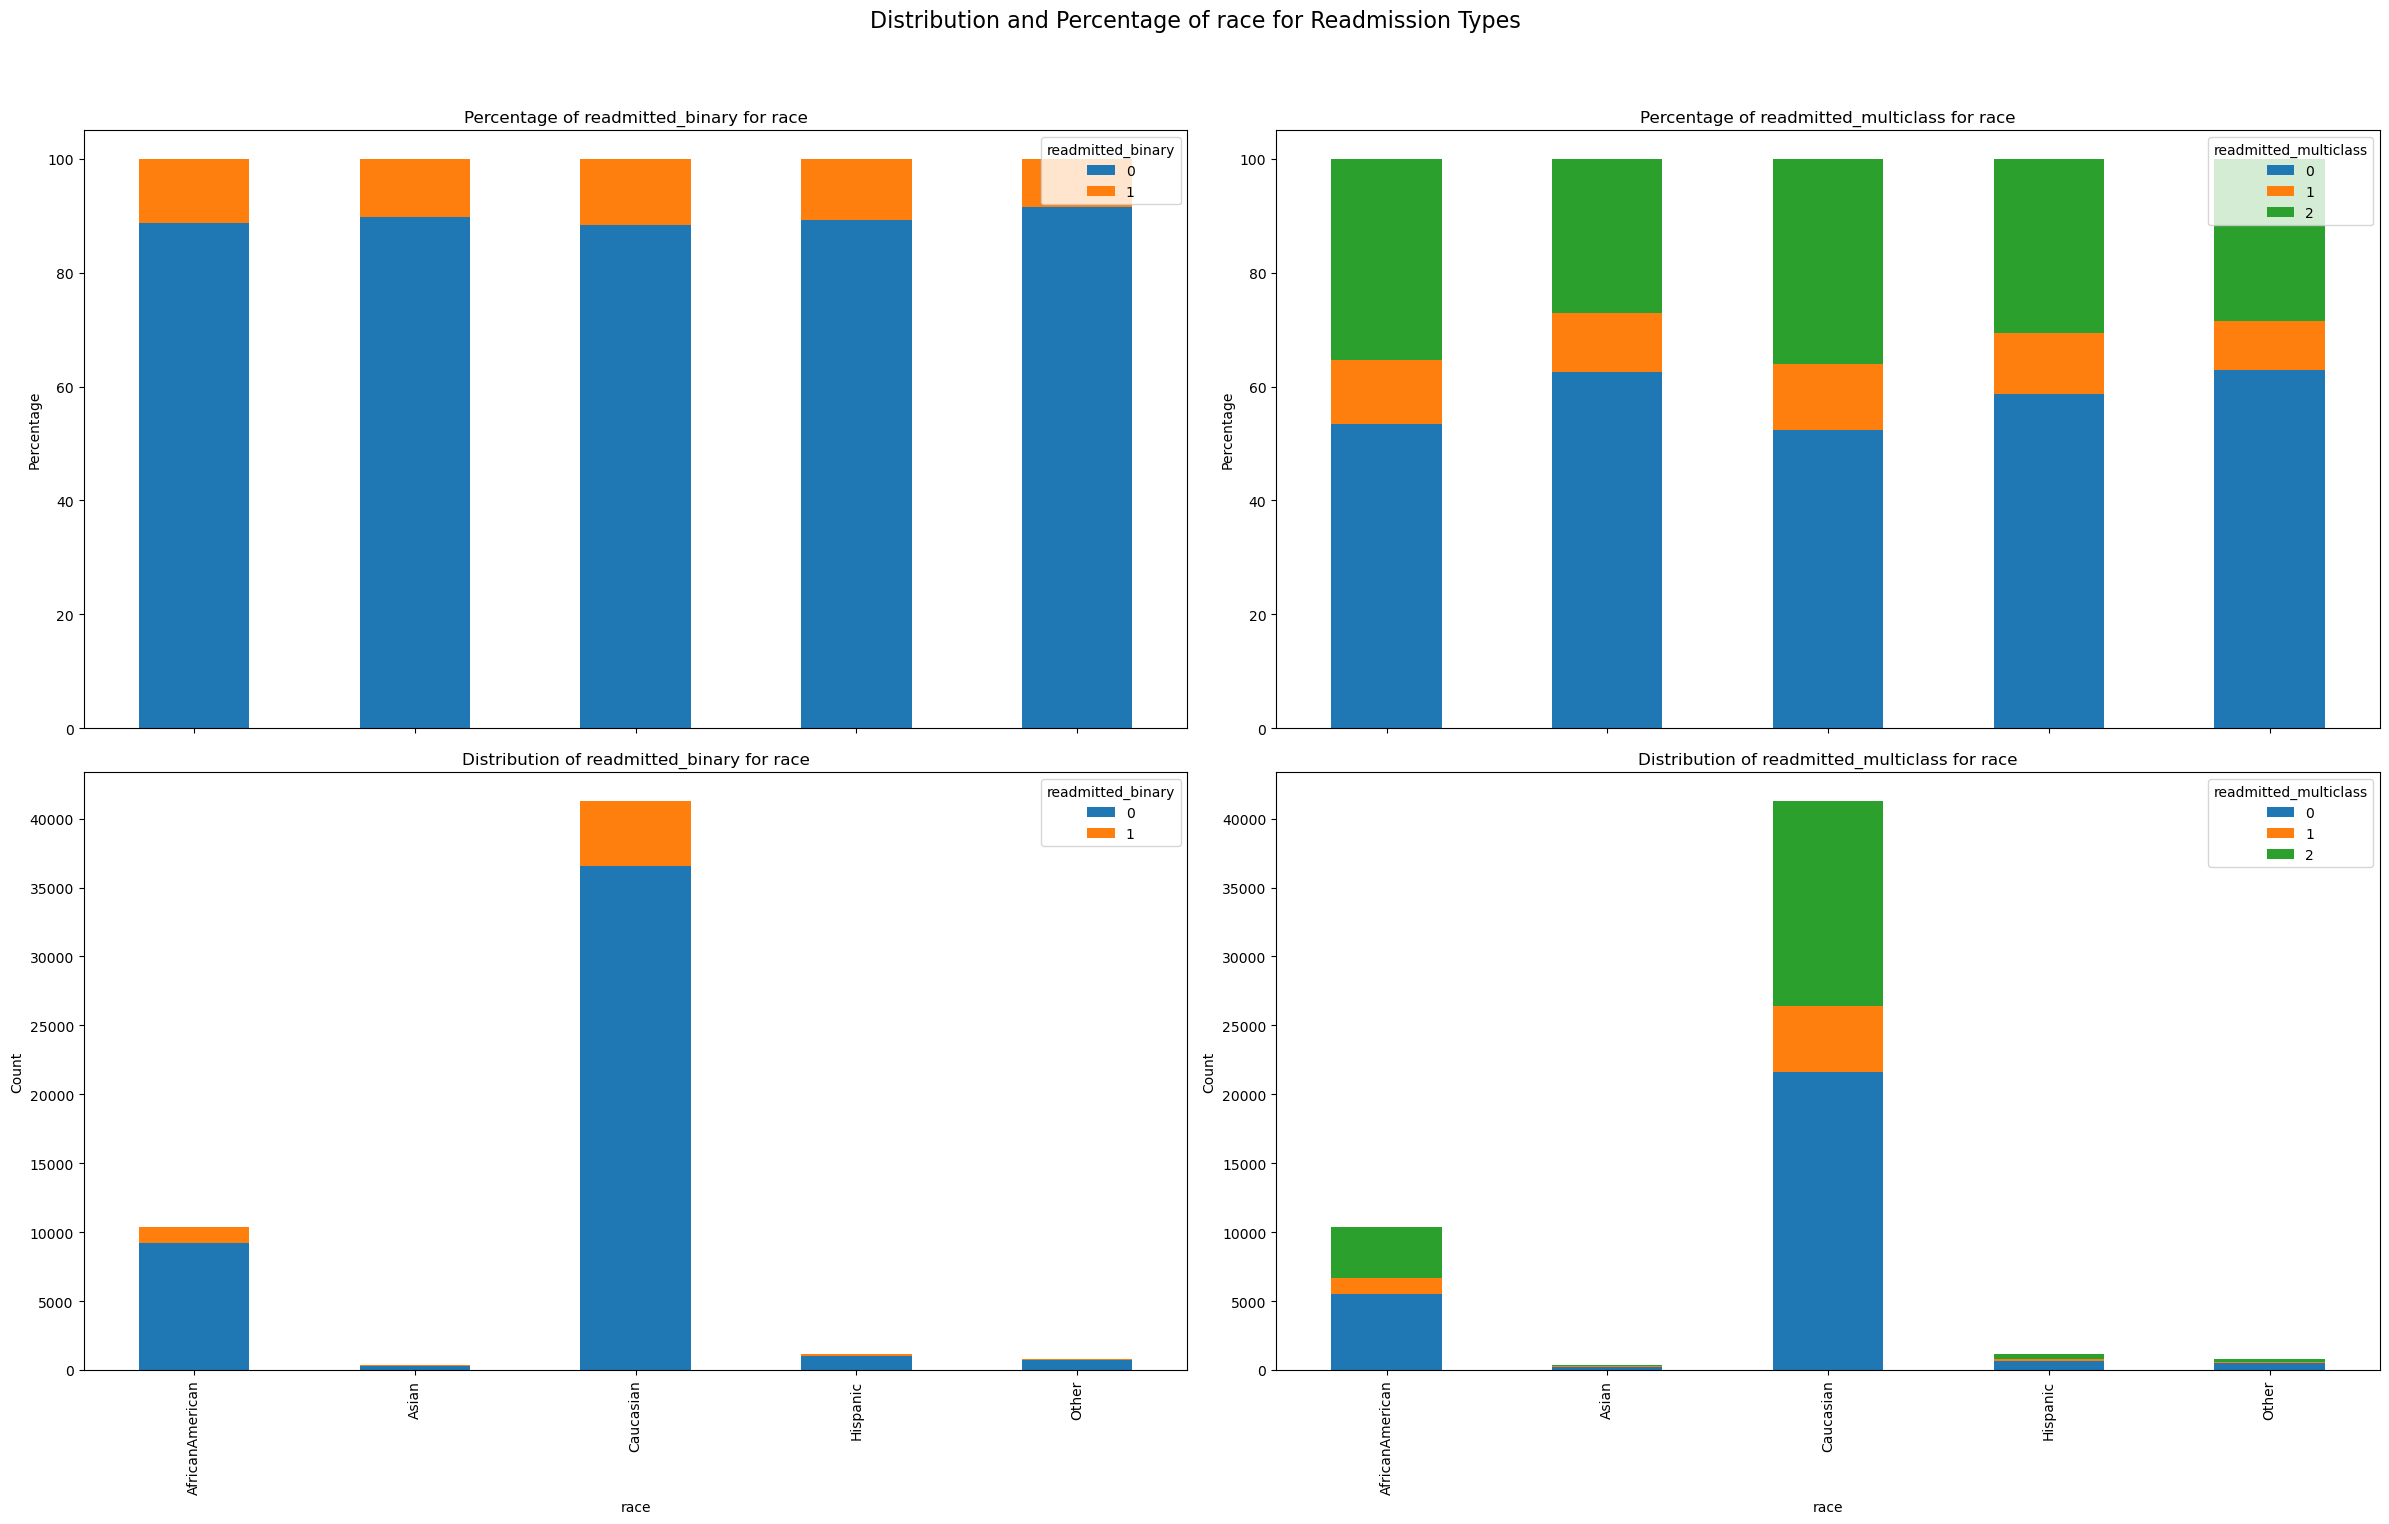

In [135]:
plot_categorical_distribution(data_train, 'race')

#### gender

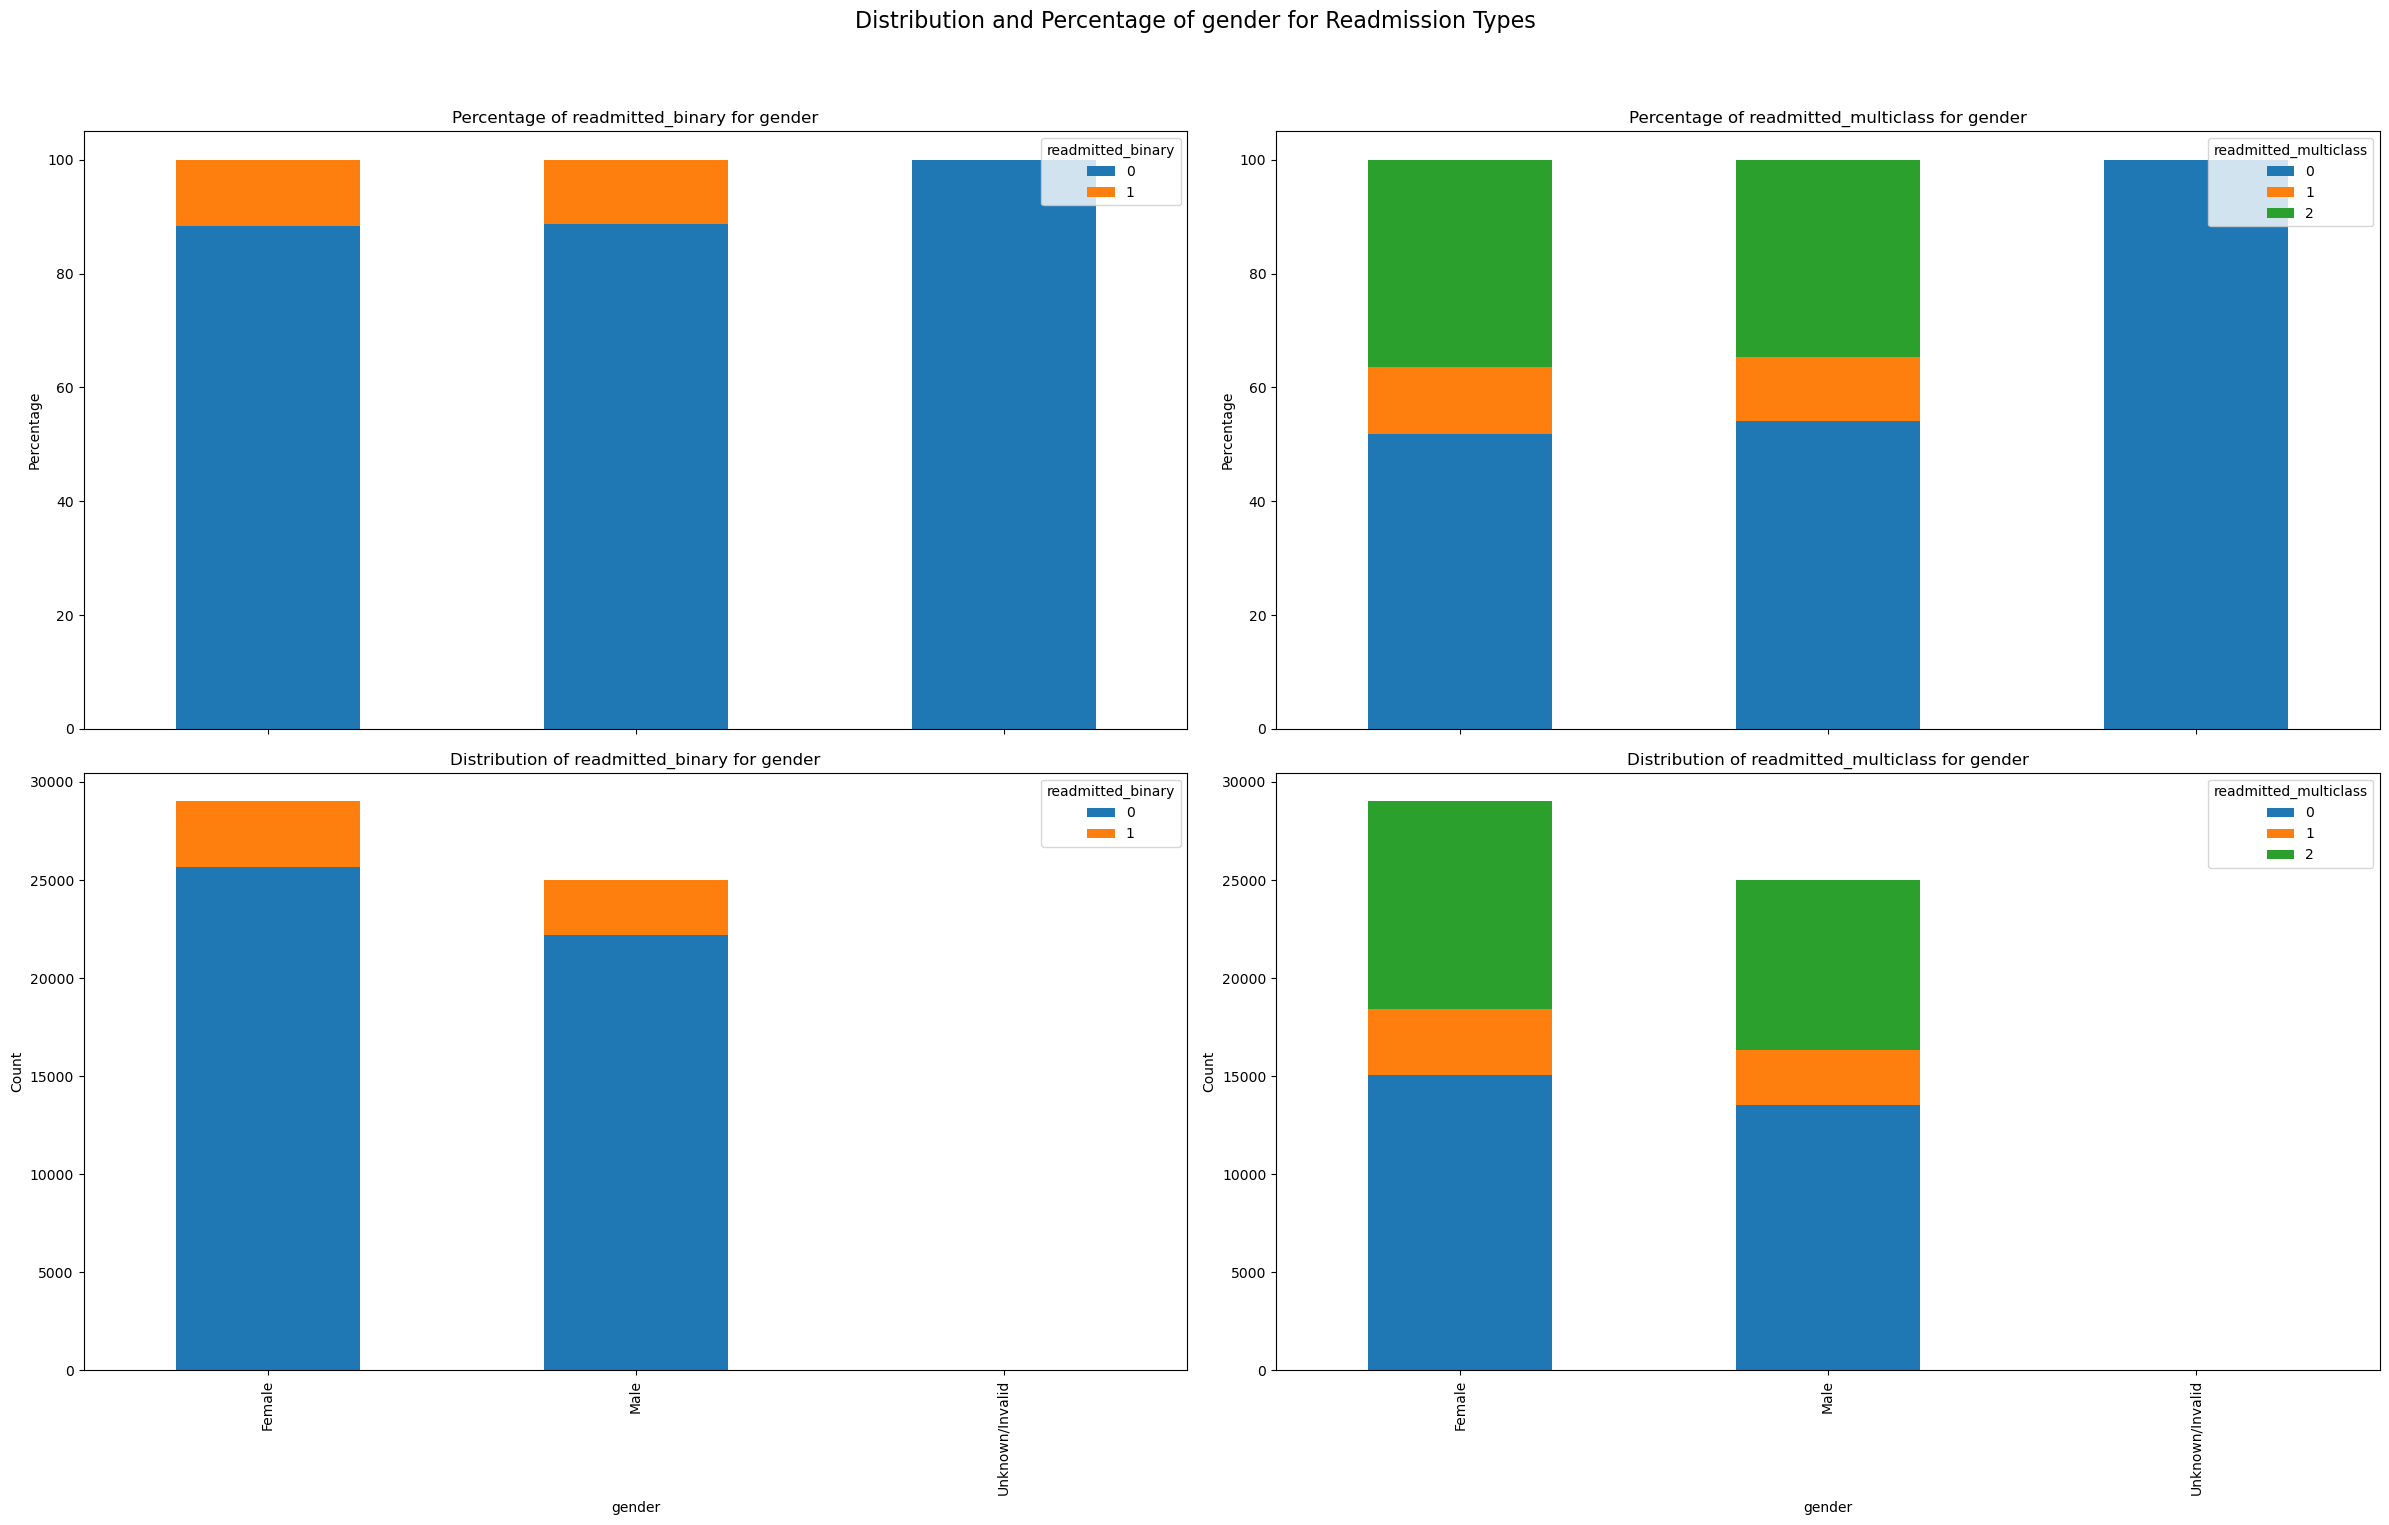

In [136]:
plot_categorical_distribution(data_train, 'gender')

In [137]:
# replace the few 'Unknown/Invalid' values with the mode in data_train
mode_gender_train = data_train['gender'].mode()[0]
data_train['gender'] = data_train['gender'].replace('Unknown/Invalid', mode_gender_train)

# Replace 'Unknown/Invalid' with the mode in data_val and data_test
data_val['gender'] = data_val['gender'].replace('Unknown/Invalid', mode_gender_train)
data_test['gender'] = data_test['gender'].replace('Unknown/Invalid', mode_gender_train)

In [138]:
# make gender column numeric
data_train['gender'] = data_train['gender'].map({'Male': 1, 'Female': 0})
data_val['gender'] = data_val['gender'].map({'Male': 1, 'Female': 0})
data_test['gender'] = data_test['gender'].map({'Male': 1, 'Female': 0})

#### age

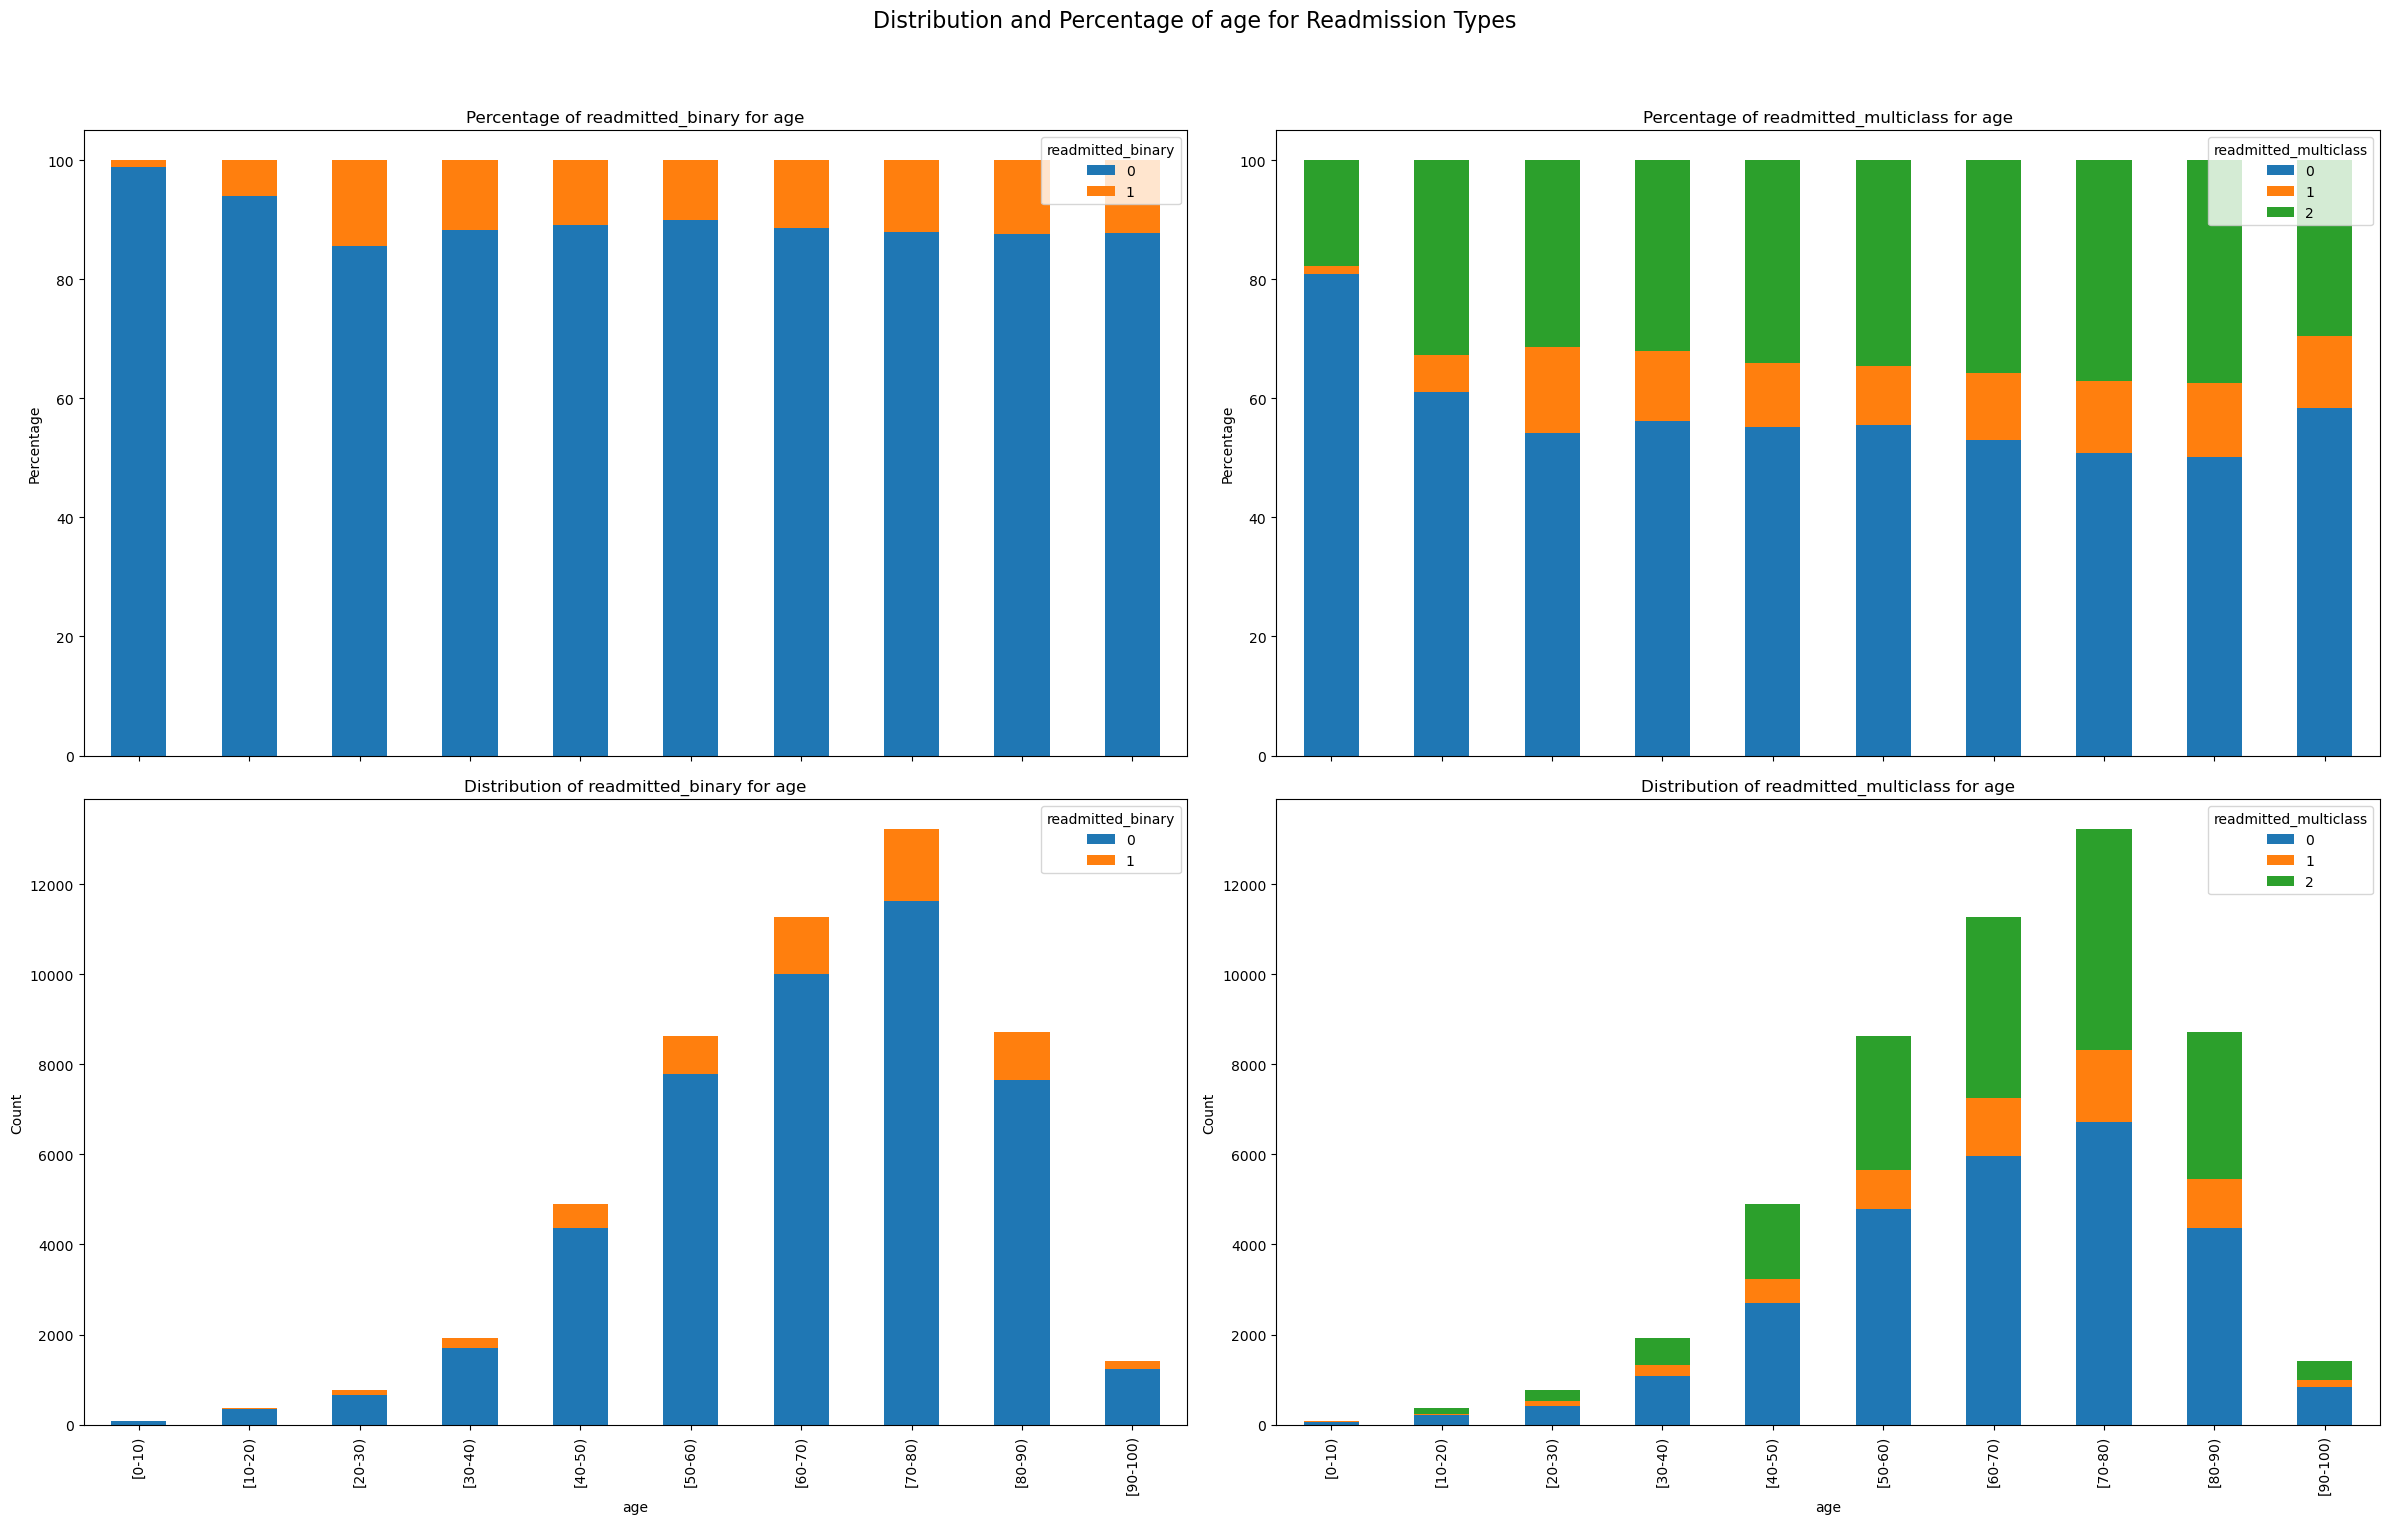

In [139]:
plot_categorical_distribution(data_train, 'age')

In [140]:
## Encode age seperate

# Define the mapping
age_mapping = {
    '[0-10)': 1,
    '[10-20)': 2,
    '[20-30)': 3,
    '[30-40)': 4,
    '[40-50)': 5,
    '[50-60)': 6,
    '[60-70)': 7,
    '[70-80)': 8,
    '[80-90)': 9,
    '[90-100)': 10
}

# Apply the mapping to the 'age' column
data_train['age'] = data_train['age'].map(age_mapping)
data_val['age'] = data_val['age'].map(age_mapping)
data_test['age'] = data_test['age'].map(age_mapping)

#### weight

In [141]:
# drop weight column since it has too many missing values
data_train.drop(['weight'], axis=1, inplace=True)
data_val.drop(['weight'], axis=1, inplace=True)
data_test.drop(['weight'], axis=1, inplace=True)

#### payer_code

In [142]:
# fill nan with 'Missing' in data_train
data_train['payer_code'] = data_train['payer_code'].fillna('Missing')

# fill nan with 'Missing' in data_val and data_test
data_val['payer_code'] = data_val['payer_code'].fillna('Missing')
data_test['payer_code'] = data_test['payer_code'].fillna('Missing')


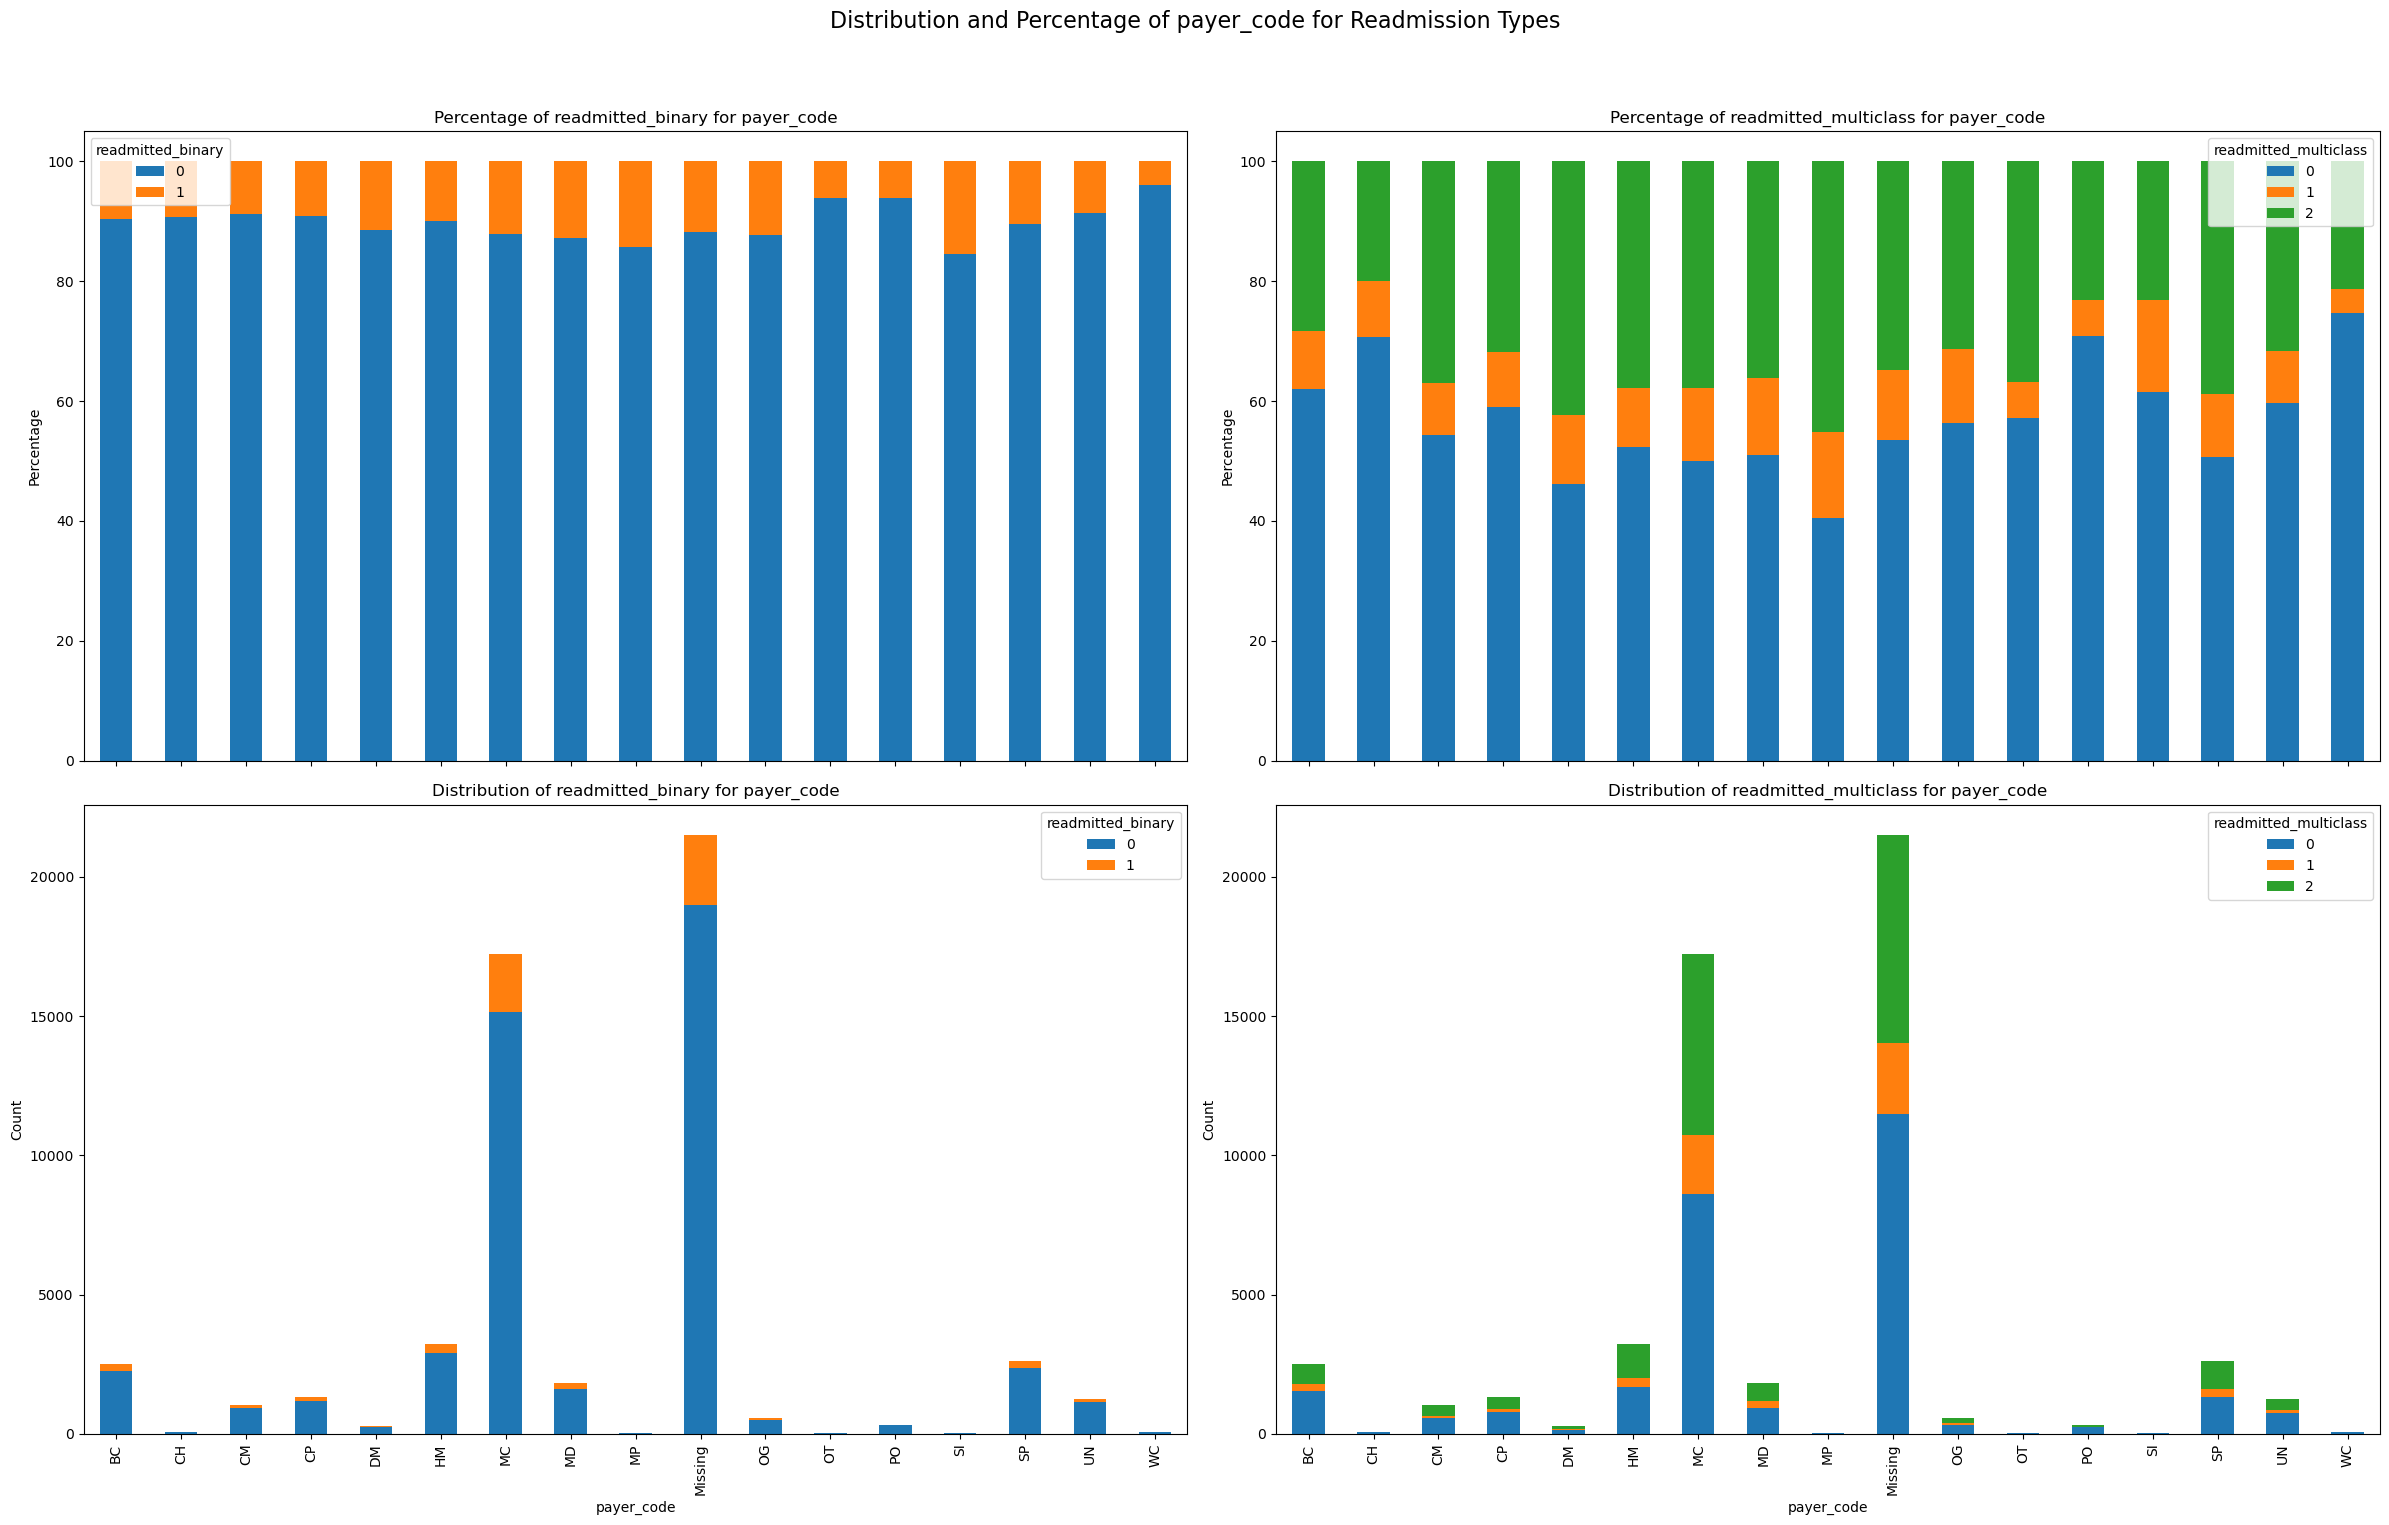

In [143]:
plot_categorical_distribution(data_train, 'payer_code')

In [144]:
data_train['payer_code'].value_counts()

payer_code
Missing    21514
MC         17222
HM          3240
SP          2632
BC          2495
MD          1842
CP          1315
UN          1258
CM          1037
OG           558
PO           329
DM           279
WC            75
CH            75
OT            49
MP            42
SI            39
Name: count, dtype: int64

#### outpatient_visits_in_previous_year

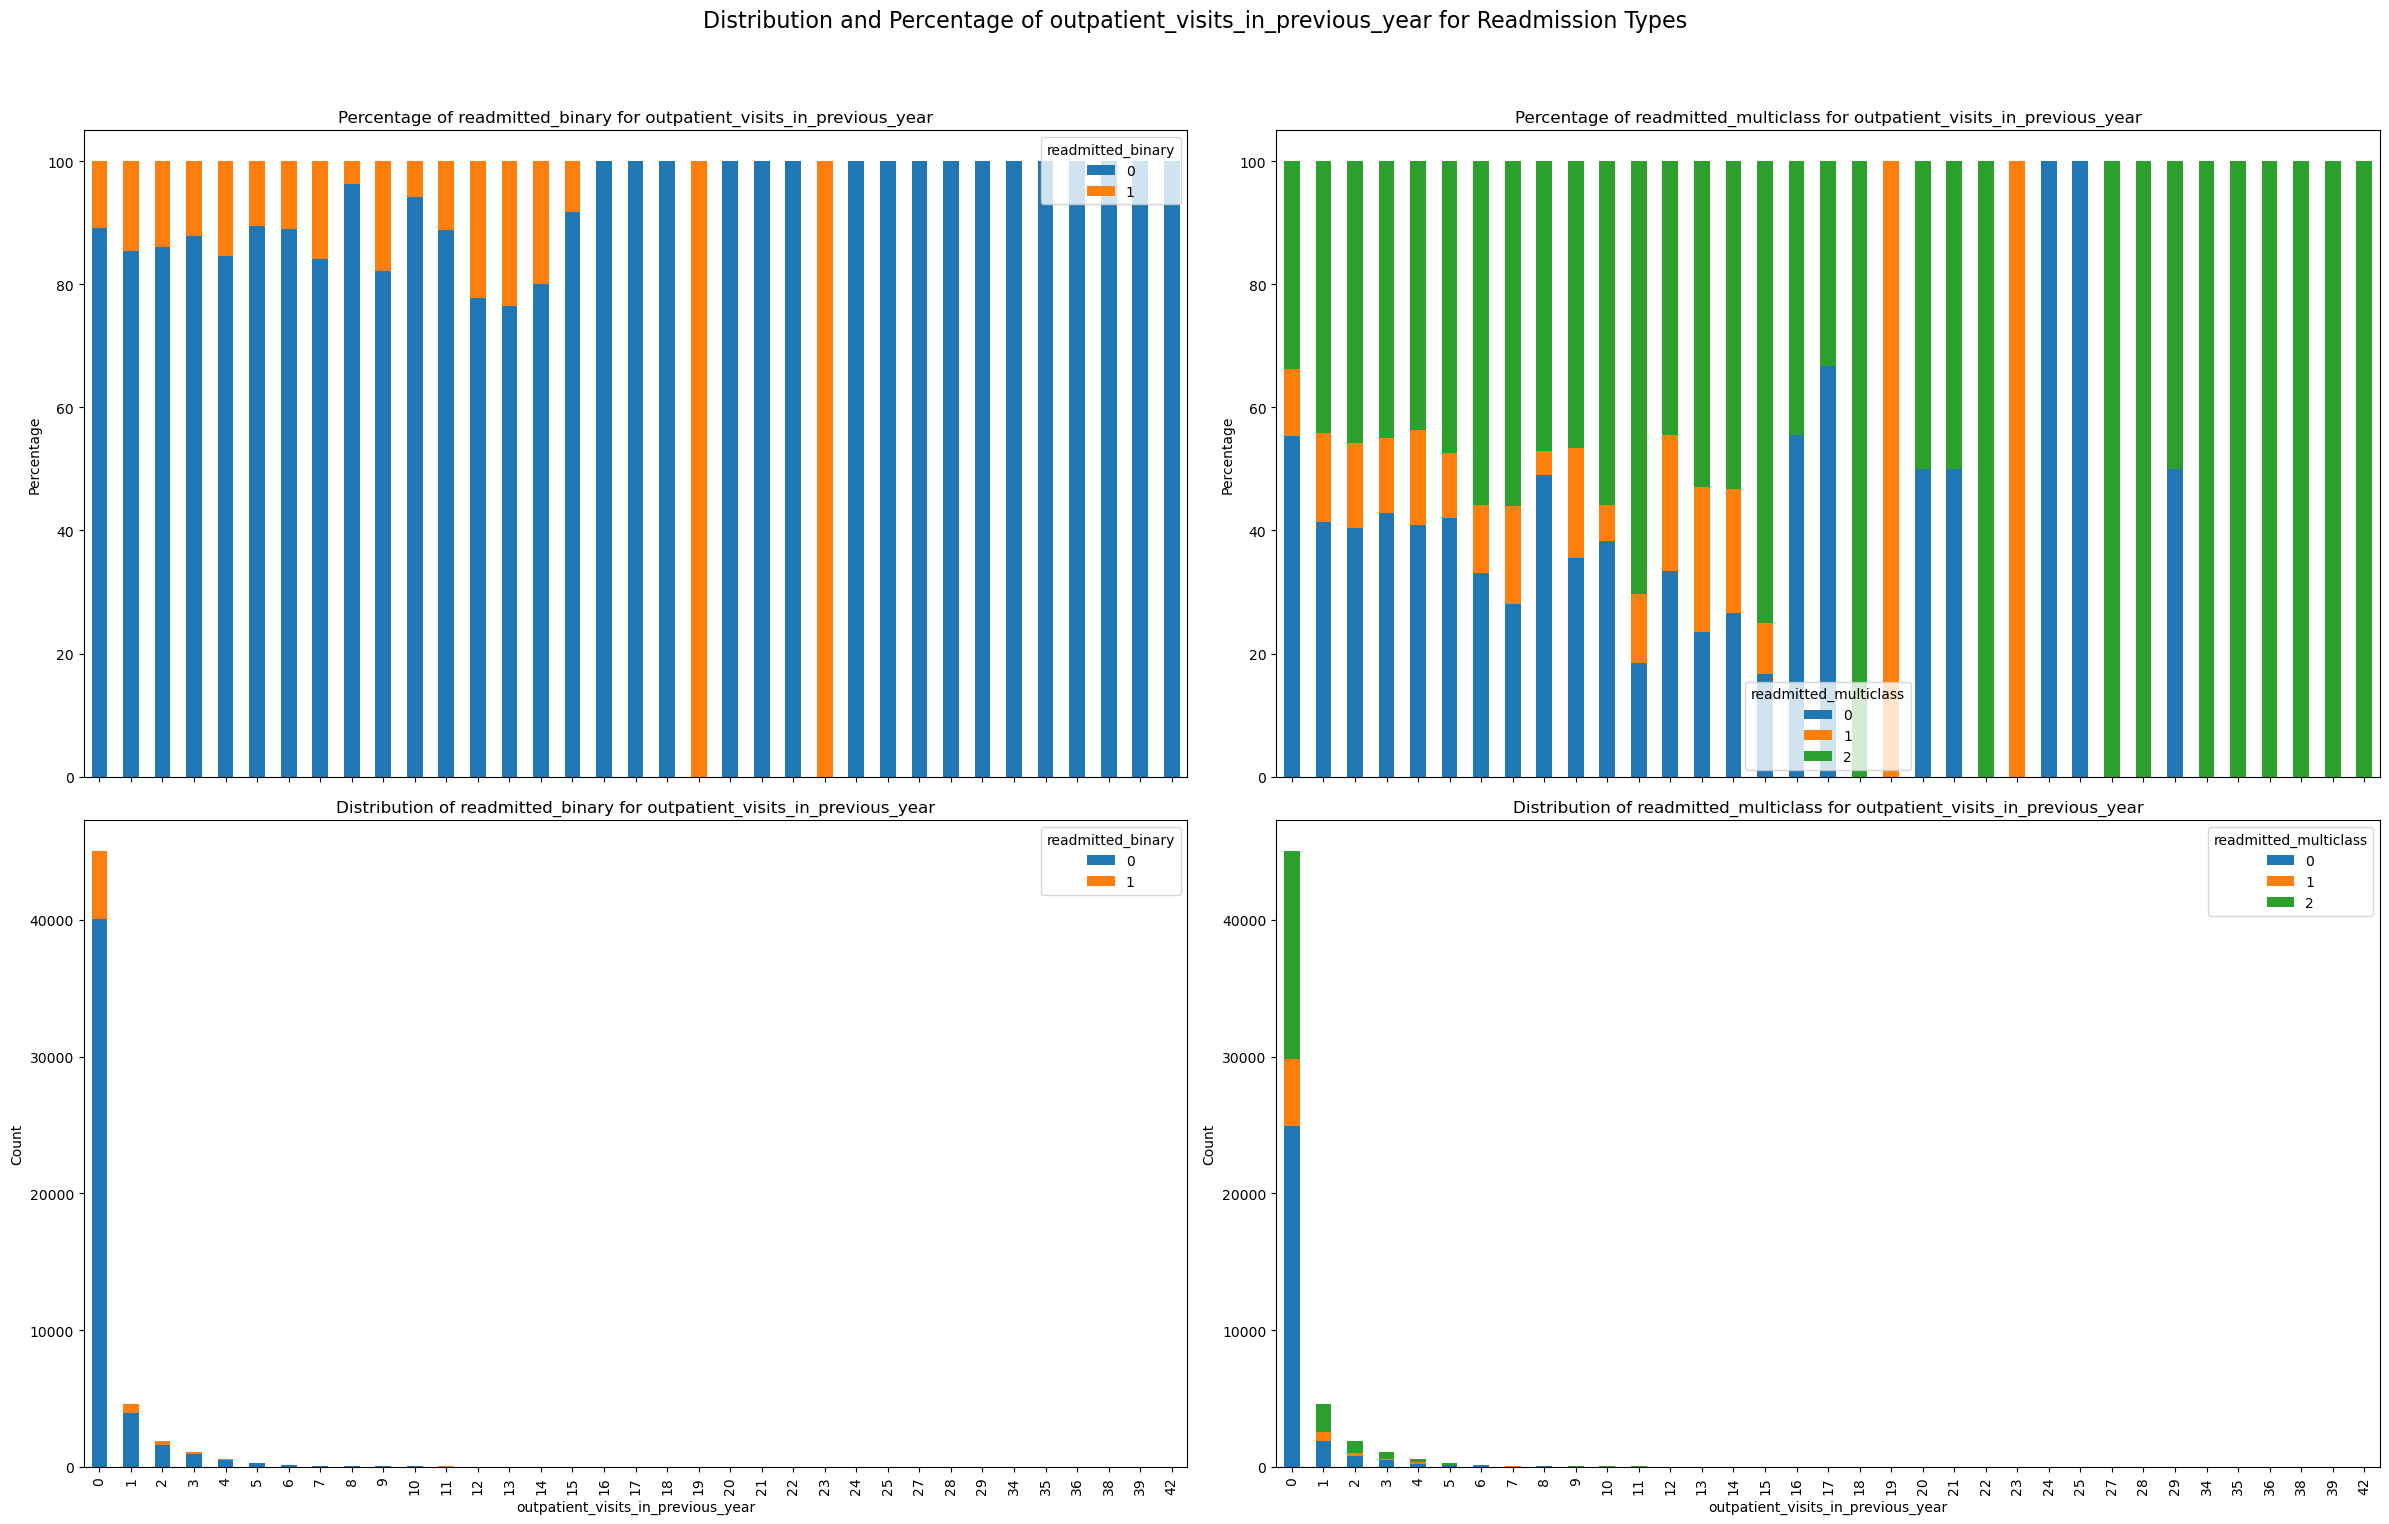

In [145]:
plot_categorical_distribution(data_train, 'outpatient_visits_in_previous_year')

In [146]:
# clip outliers at 23 for outpatient_visits_in_previous_year as we will only have 0 readmission after 23 visits
data_train['outpatient_visits_in_previous_year'] = data_train['outpatient_visits_in_previous_year'].clip(upper=24)
data_val['outpatient_visits_in_previous_year'] = data_val['outpatient_visits_in_previous_year'].clip(upper=24)
data_test['outpatient_visits_in_previous_year'] = data_test['outpatient_visits_in_previous_year'].clip(upper=24)


In [147]:
# # Outpatient Visits
# cap_outpatient = cap_outliers(data_train, 'outpatient_visits_in_previous_year', 0.99)
# data_val['outpatient_visits_in_previous_year'] = data_val['outpatient_visits_in_previous_year'].clip(upper=cap_outpatient)
# data_test['outpatient_visits_in_previous_year'] = data_test['outpatient_visits_in_previous_year'].clip(upper=cap_outpatient)

#### inpatient_visits_in_previous_year

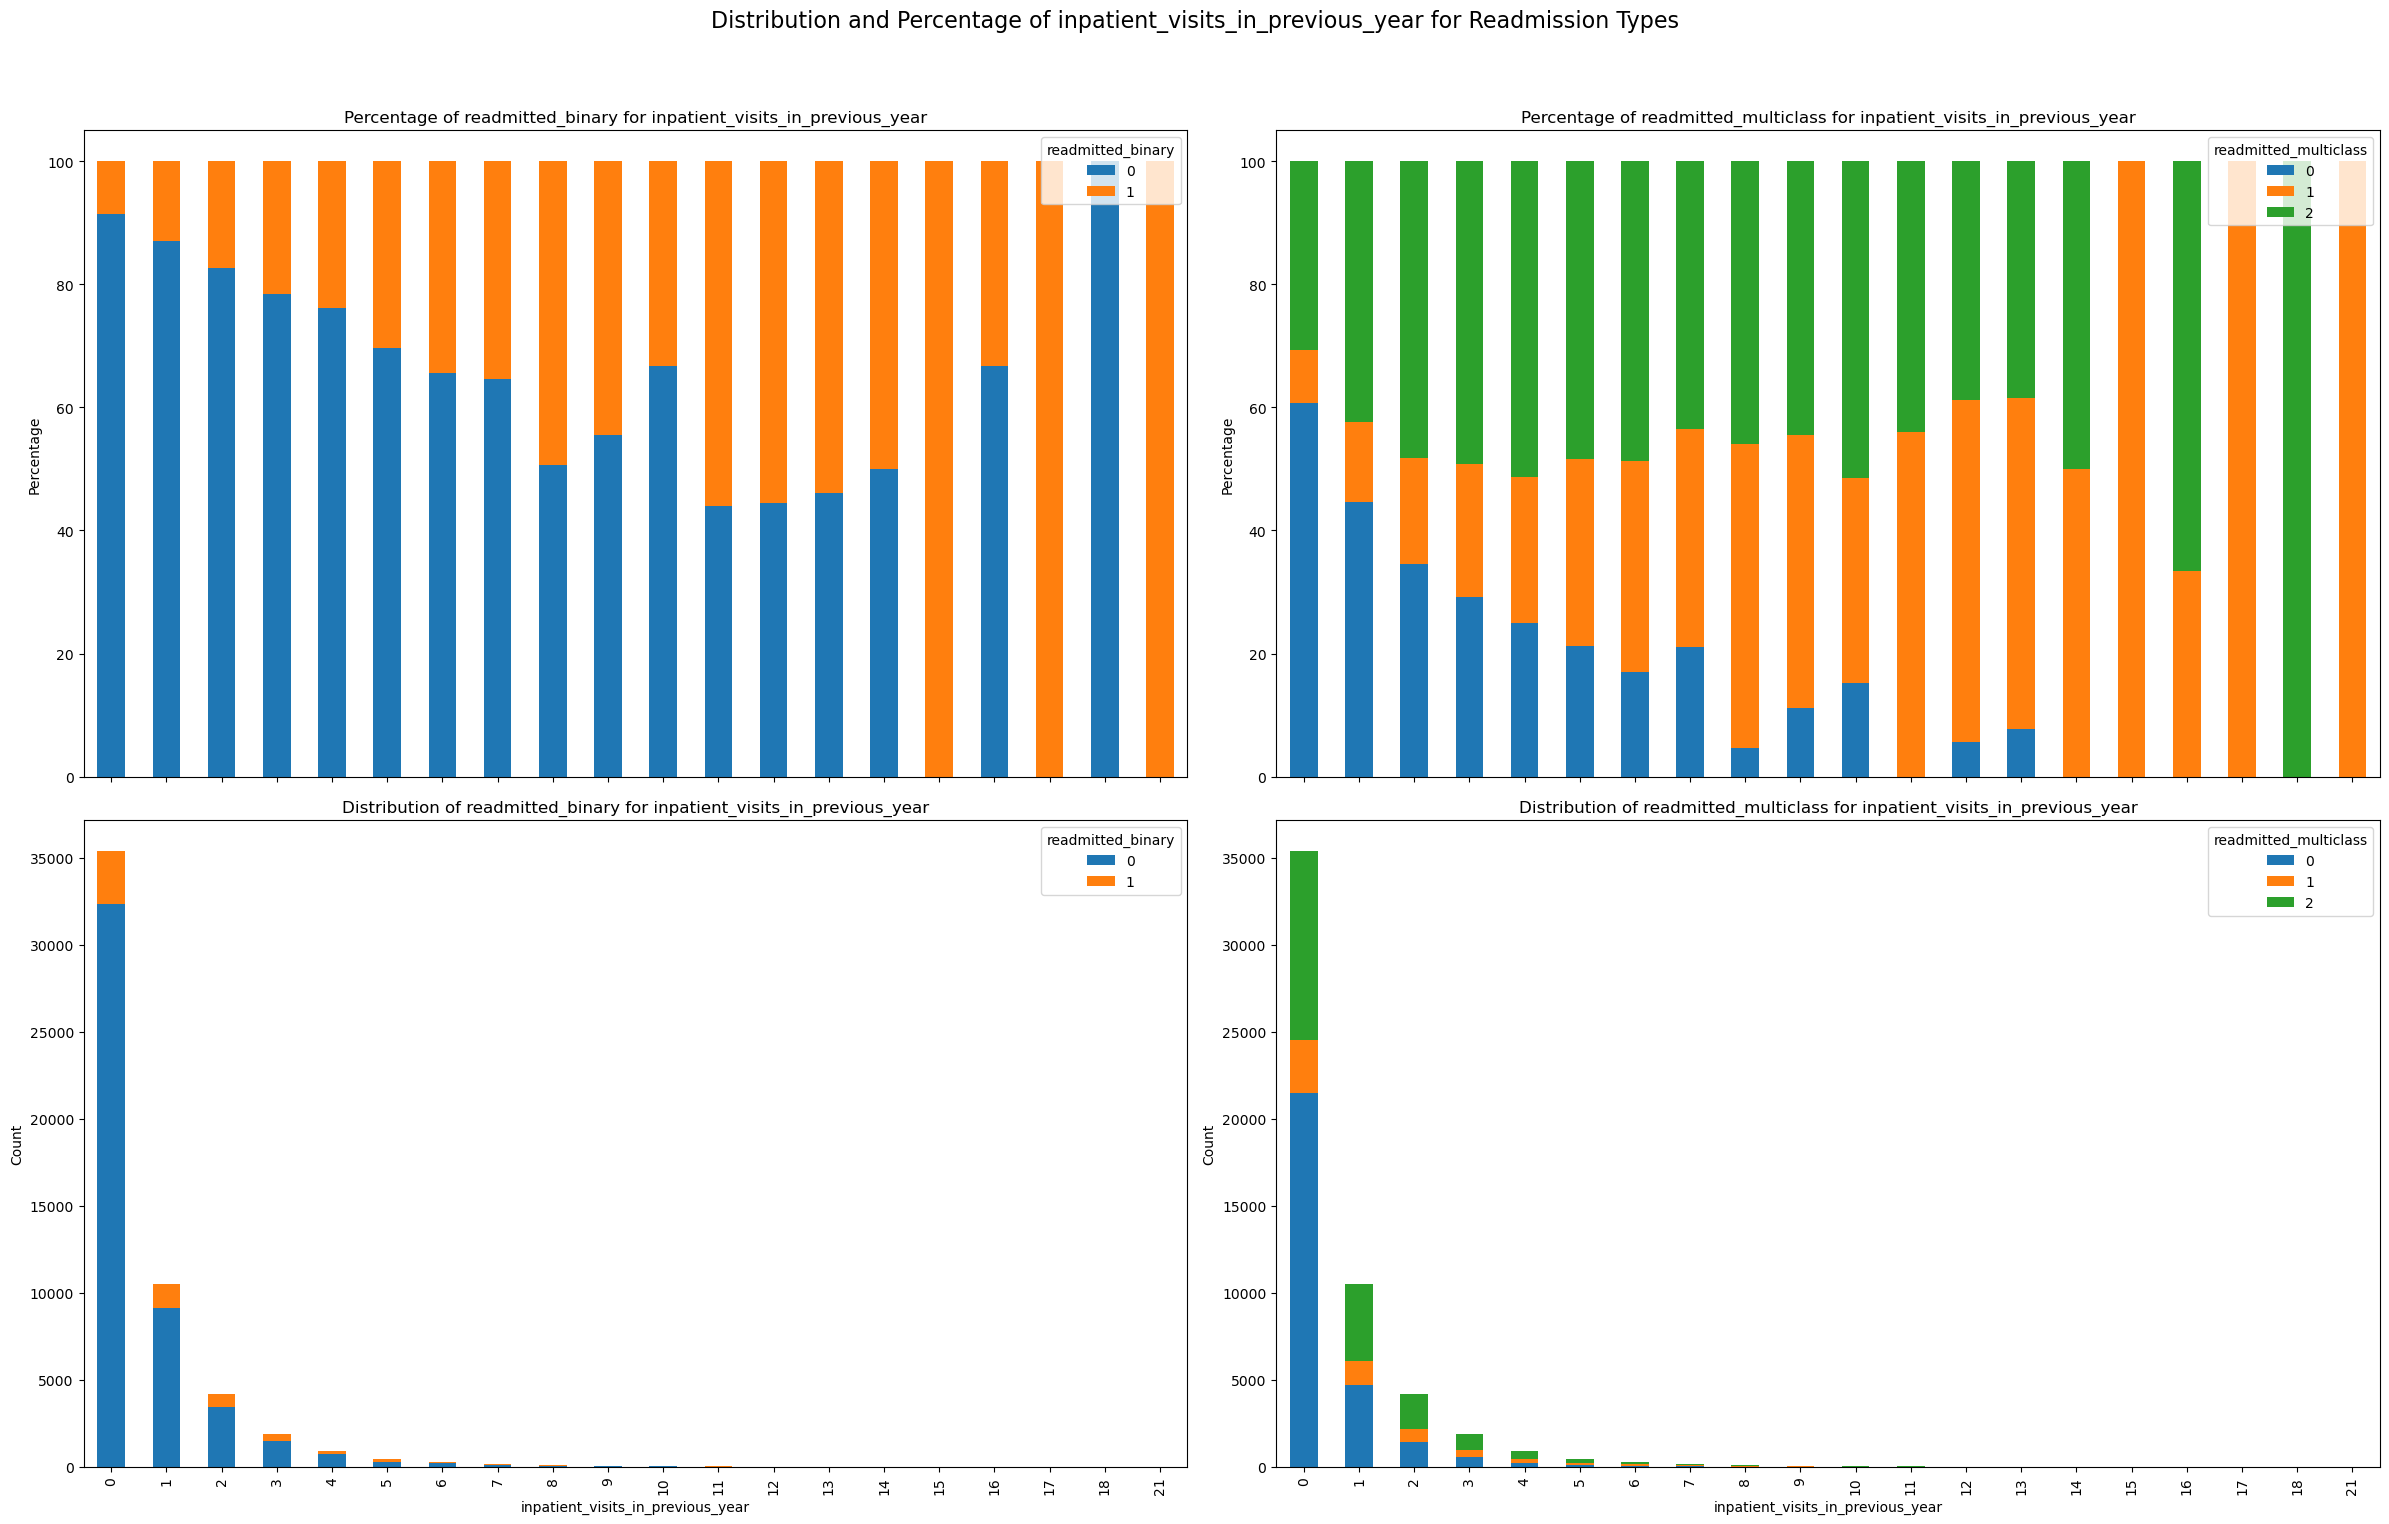

In [148]:
plot_categorical_distribution(data_train, 'inpatient_visits_in_previous_year')

In [149]:
# we are not clipping inpatient_visits_in_previous_year as we will don't see a good value. Too big inequality between 0 and 1 readmission in higher values.

#### emergency_visits_in_previous_year

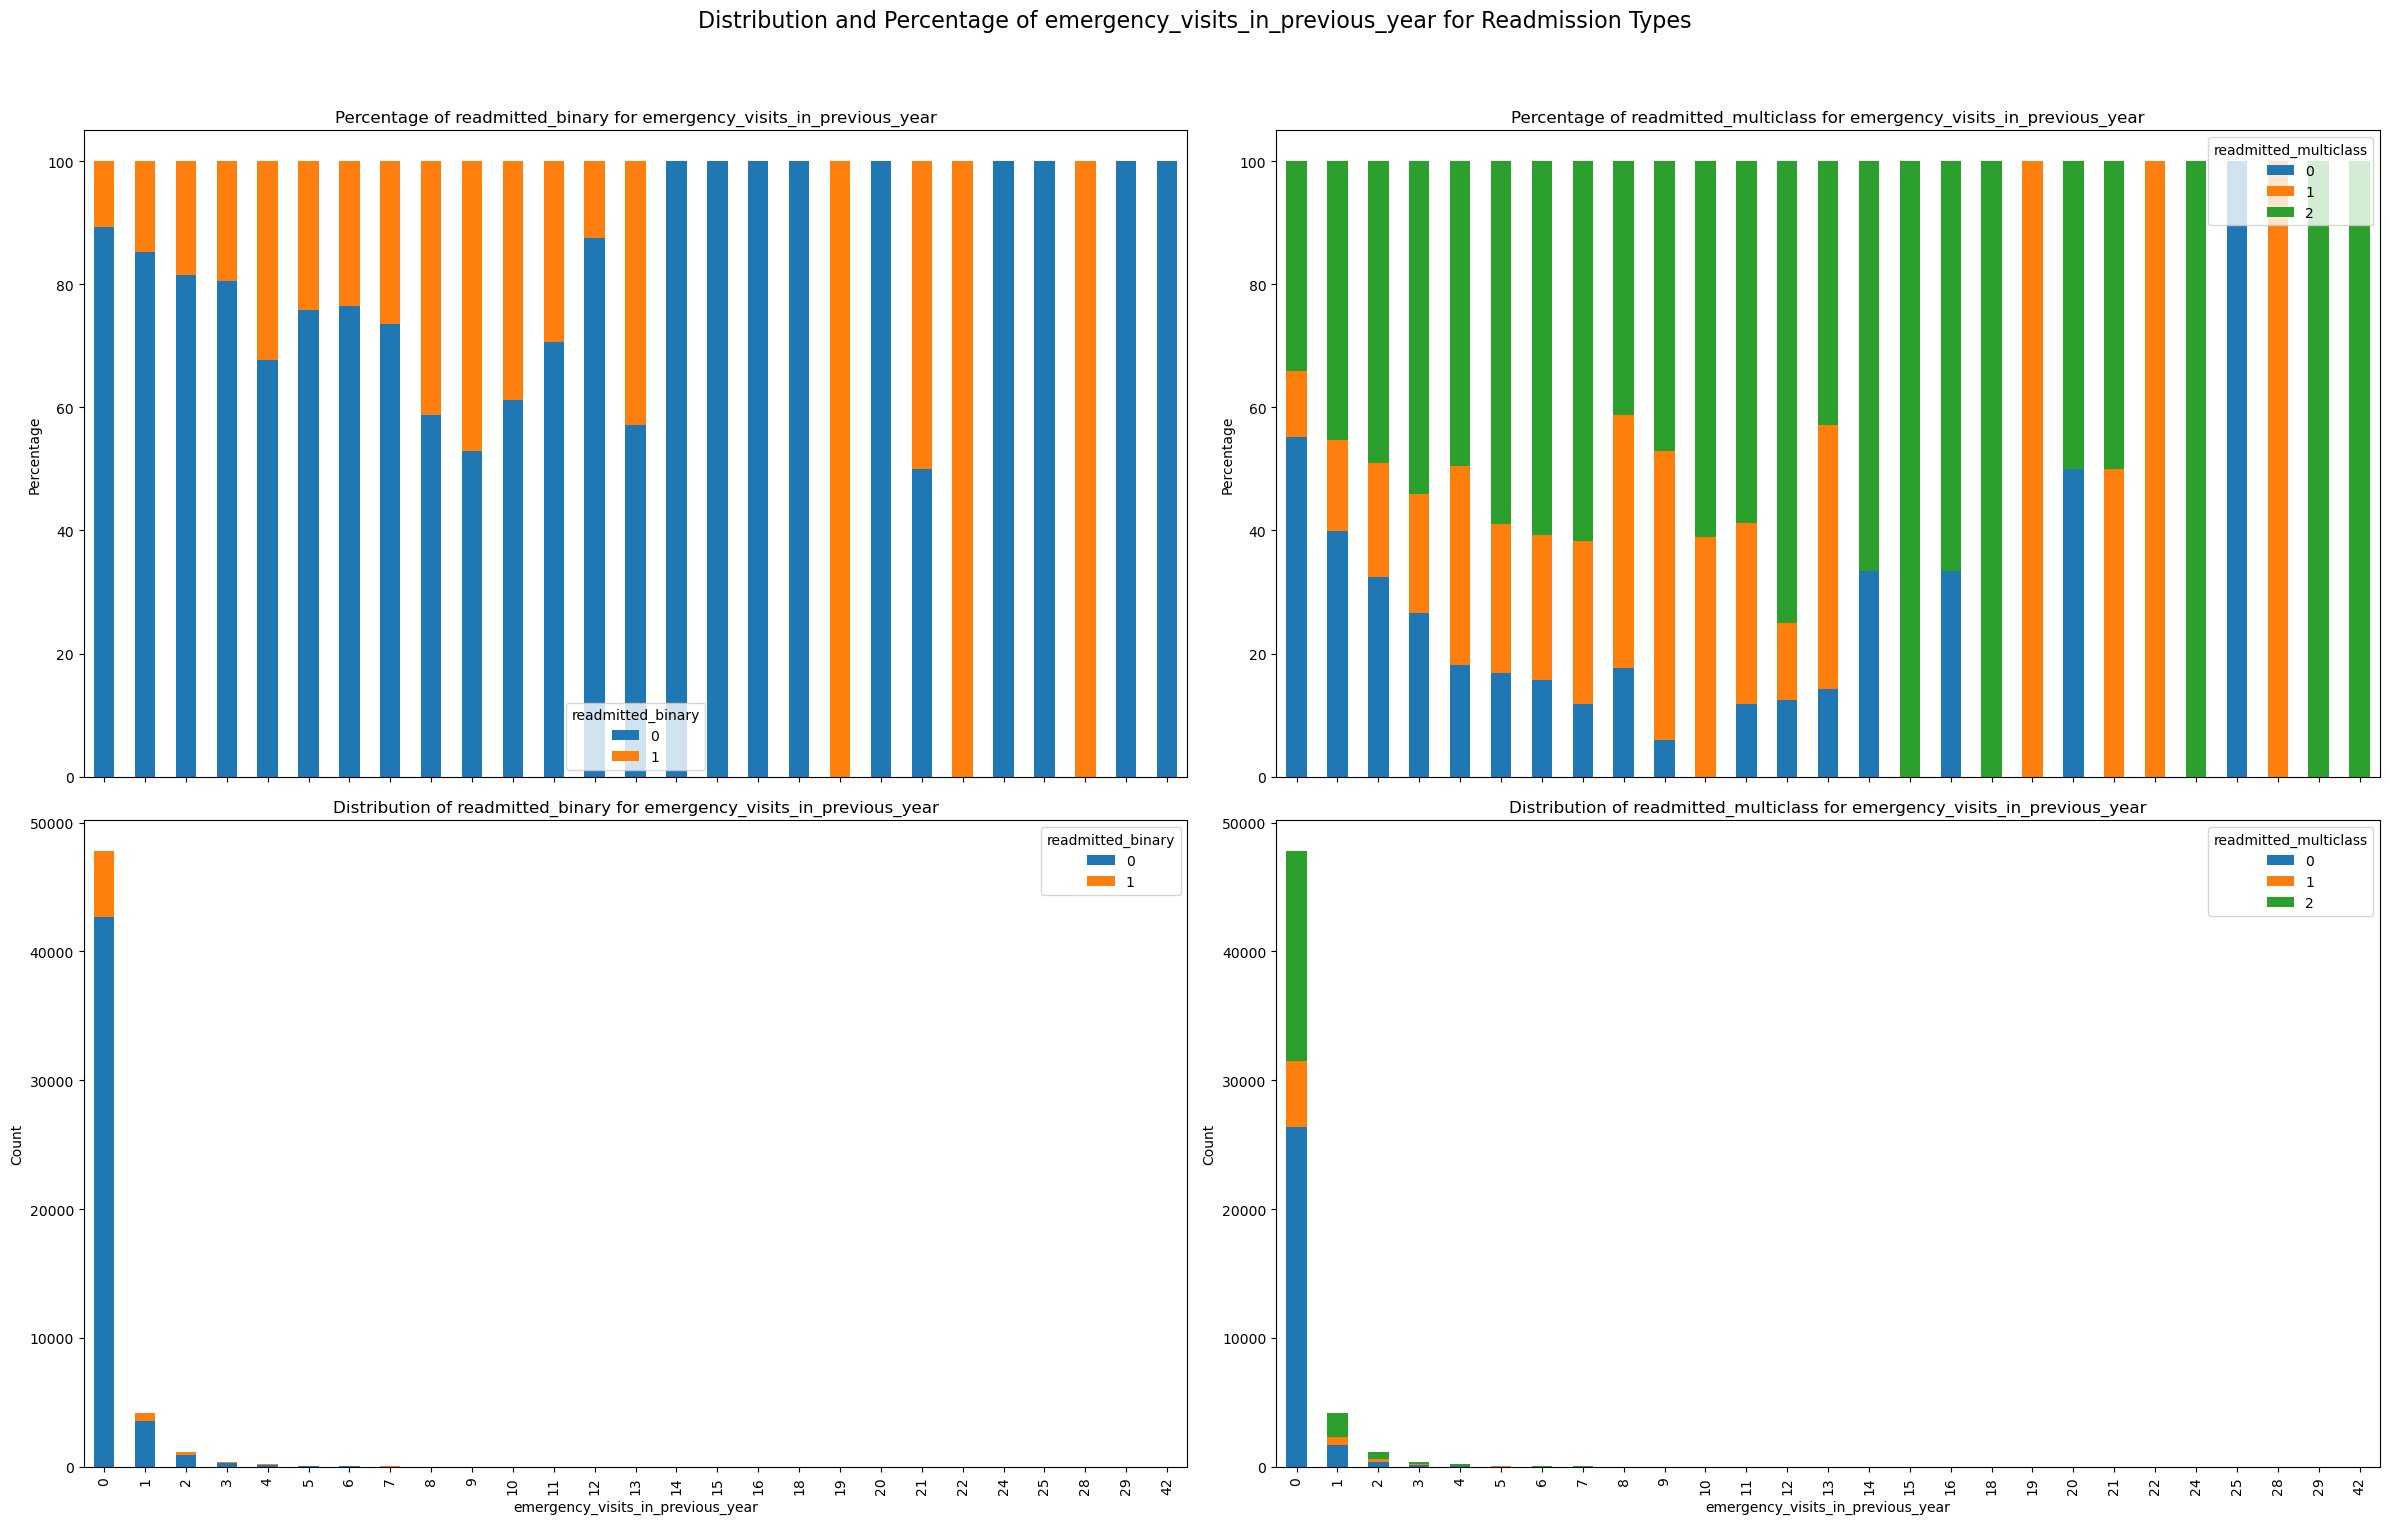

In [150]:
plot_categorical_distribution(data_train, 'emergency_visits_in_previous_year')

In [151]:
# clip at 29 for emergency_visits_in_previous_year as we will only have 0 readmission after 29 visits
data_train['emergency_visits_in_previous_year'] = data_train['emergency_visits_in_previous_year'].clip(upper=29)
data_val['emergency_visits_in_previous_year'] = data_val['emergency_visits_in_previous_year'].clip(upper=29)
data_test['emergency_visits_in_previous_year'] = data_test['emergency_visits_in_previous_year'].clip(upper=29)

#### admission_type

In [152]:
# fill nan with 'Missing' in data_train admission_type
data_train['admission_type'] = data_train['admission_type'].fillna('Missing')

# fill nan with 'Missing' in data_val and data_test admission_type
data_val['admission_type'] = data_val['admission_type'].fillna('Missing')
data_test['admission_type'] = data_test['admission_type'].fillna('Missing')

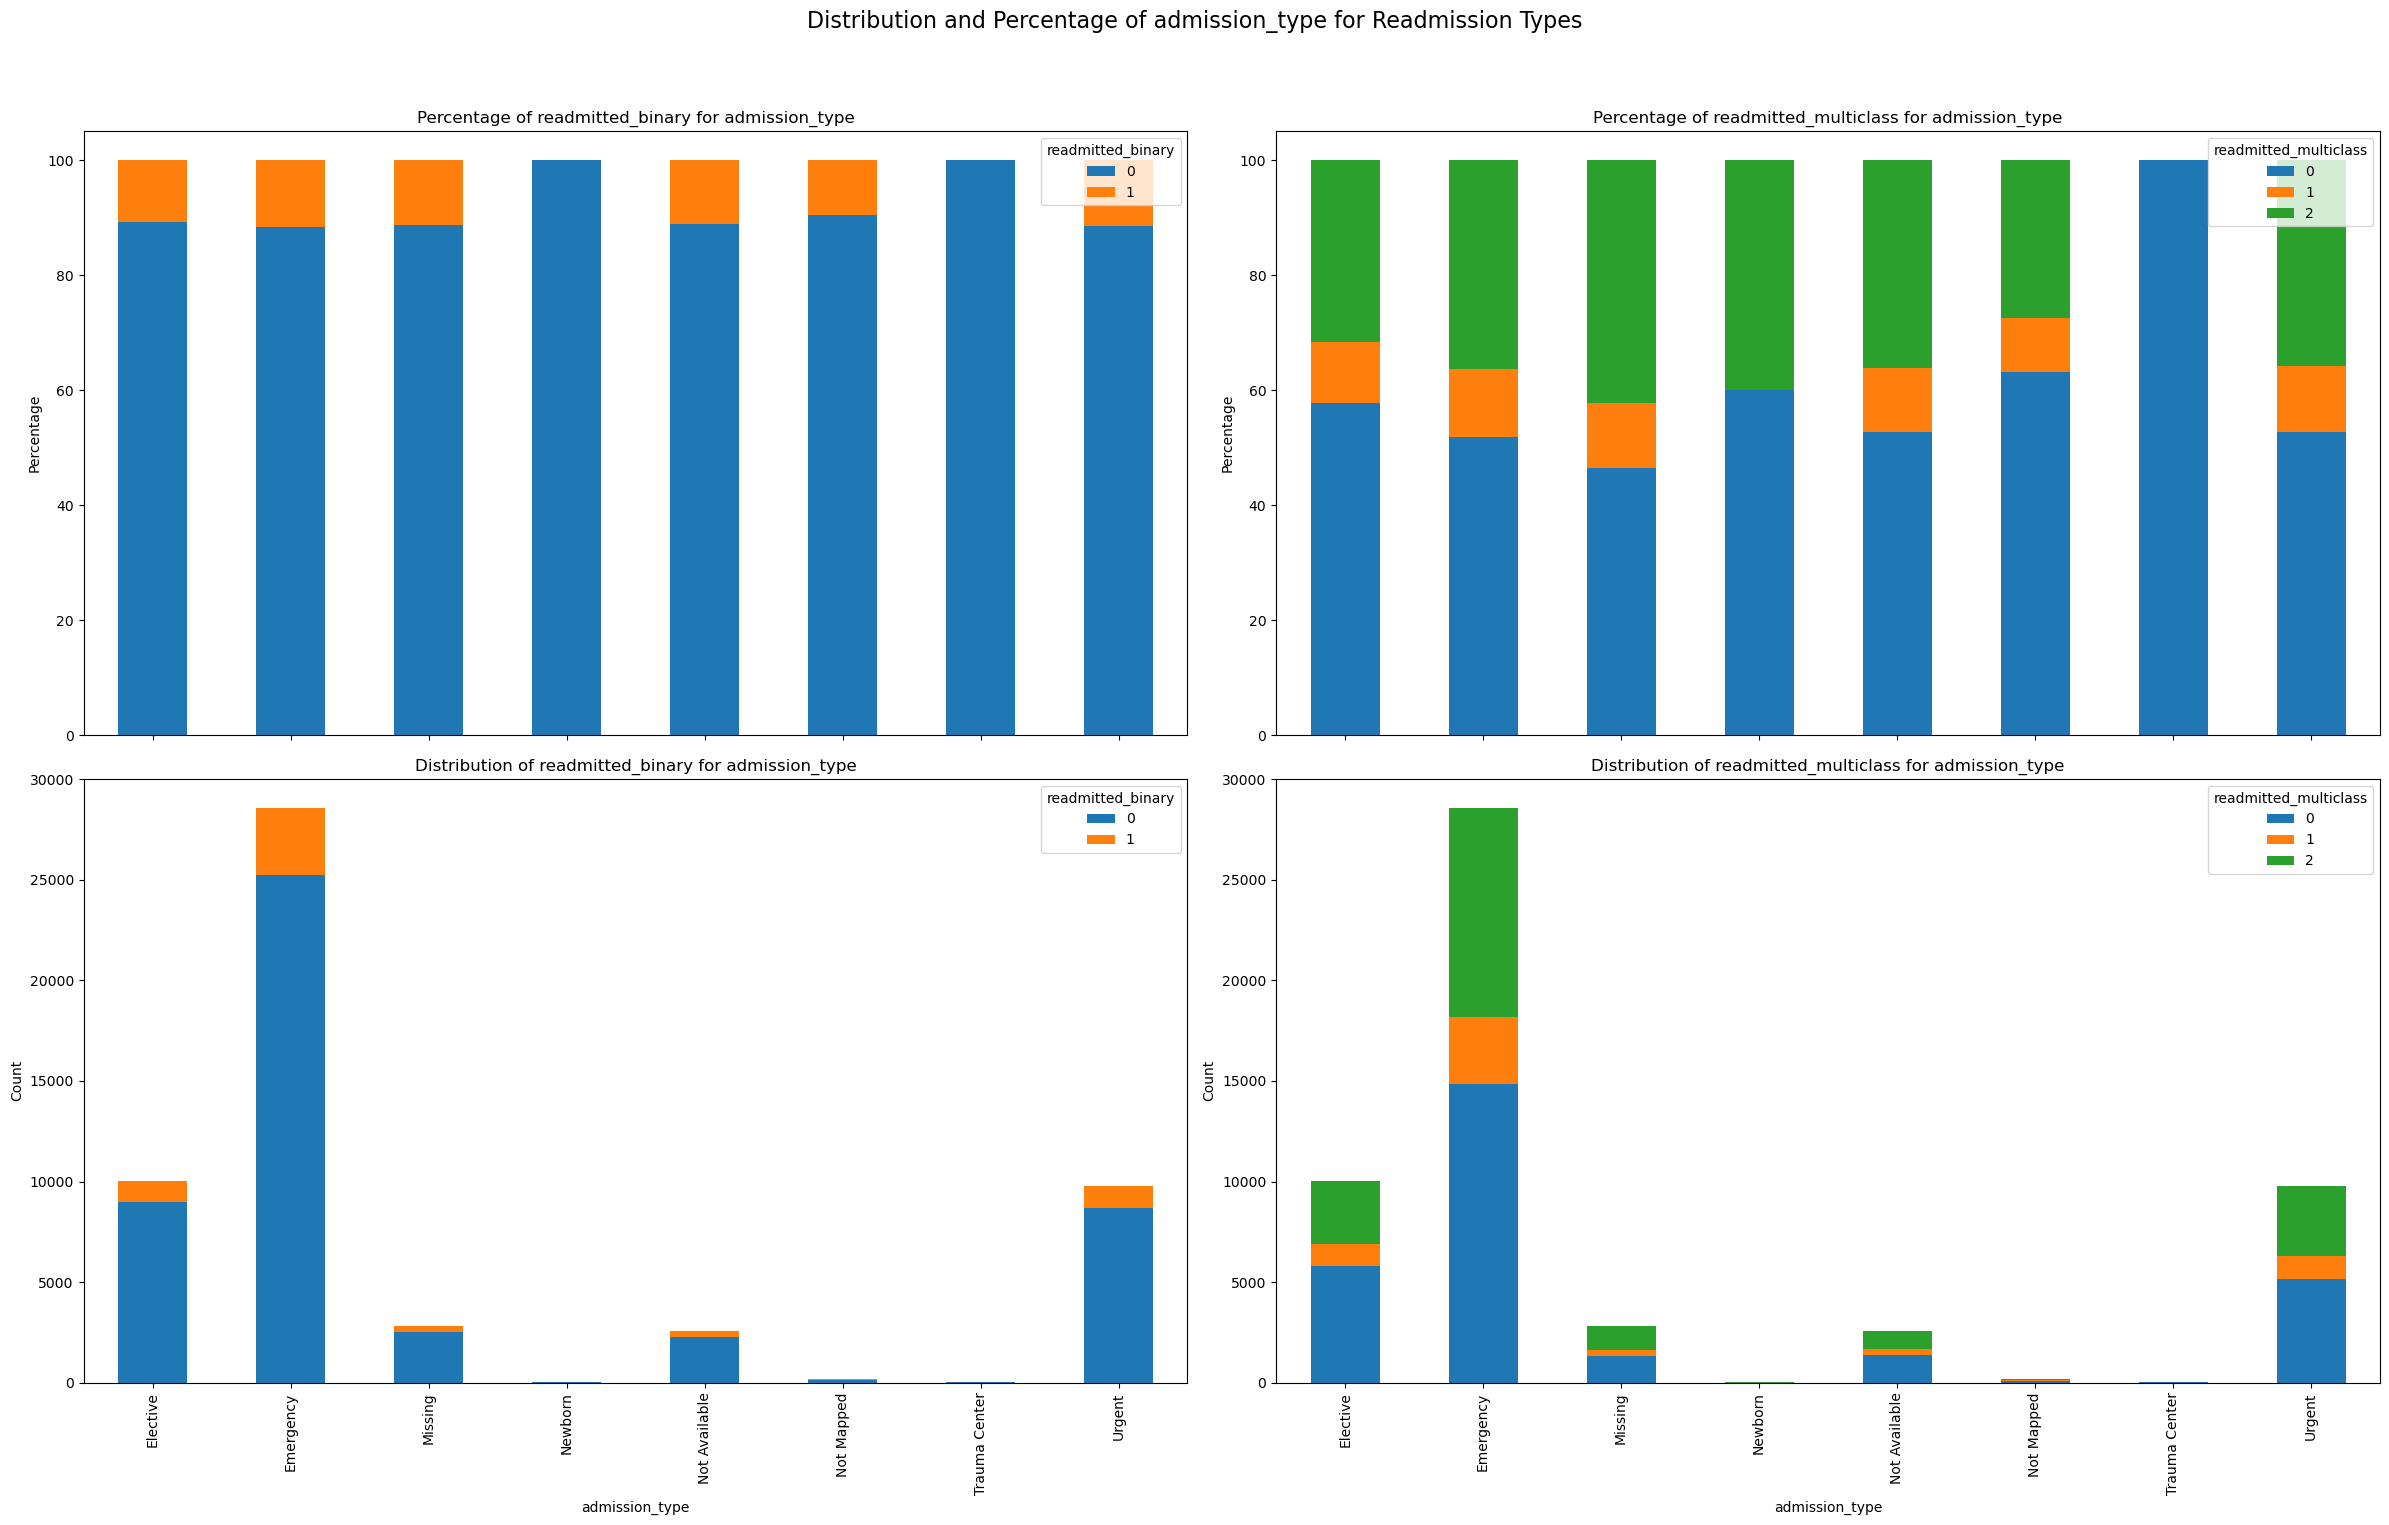

In [153]:
plot_categorical_distribution(data_train, 'admission_type')

In [154]:
data_train.groupby(['admission_type', 'readmitted_binary']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack()

,readmitted_binary,0,1
admission_type,admission_type,,
Elective,Elective,89.231995,10.768005
Emergency,Emergency,88.302560,11.697440
Missing,Missing,88.691953,11.308047
Newborn,Newborn,100.000000,NaN
Not Available,Not Available,88.867339,11.132661
Not Mapped,Not Mapped,90.445860,9.554140
Trauma Center,Trauma Center,100.000000,NaN
Urgent,Urgent,88.483920,11.516080


In [155]:
# since many categories will do almost the same prediction, we will group them together
data_train['admission_type'] = data_train['admission_type'].replace(['Trauma Center', 'Newborn'], 'No Readmission')
data_val['admission_type'] = data_val['admission_type'].replace(['Trauma Center', 'Newborn'], 'No Readmission')
data_test['admission_type'] = data_test['admission_type'].replace(['Trauma Center', 'Newborn'], 'No Readmission')

# since missing, not mapped and not available have similar readmission rate, we will group them together

data_train['admission_type'] = data_train['admission_type'].replace(['Missing', 'Not Available', 'Not Mapped'], 'Not Available/Not Mapped')
data_val['admission_type'] = data_val['admission_type'].replace(['Missing', 'Not Available', 'Not Mapped'], 'Not Available/Not Mapped')
data_test['admission_type'] = data_test['admission_type'].replace(['Missing', 'Not Available', 'Not Mapped'], 'Not Available/Not Mapped')

#### medical_specialty

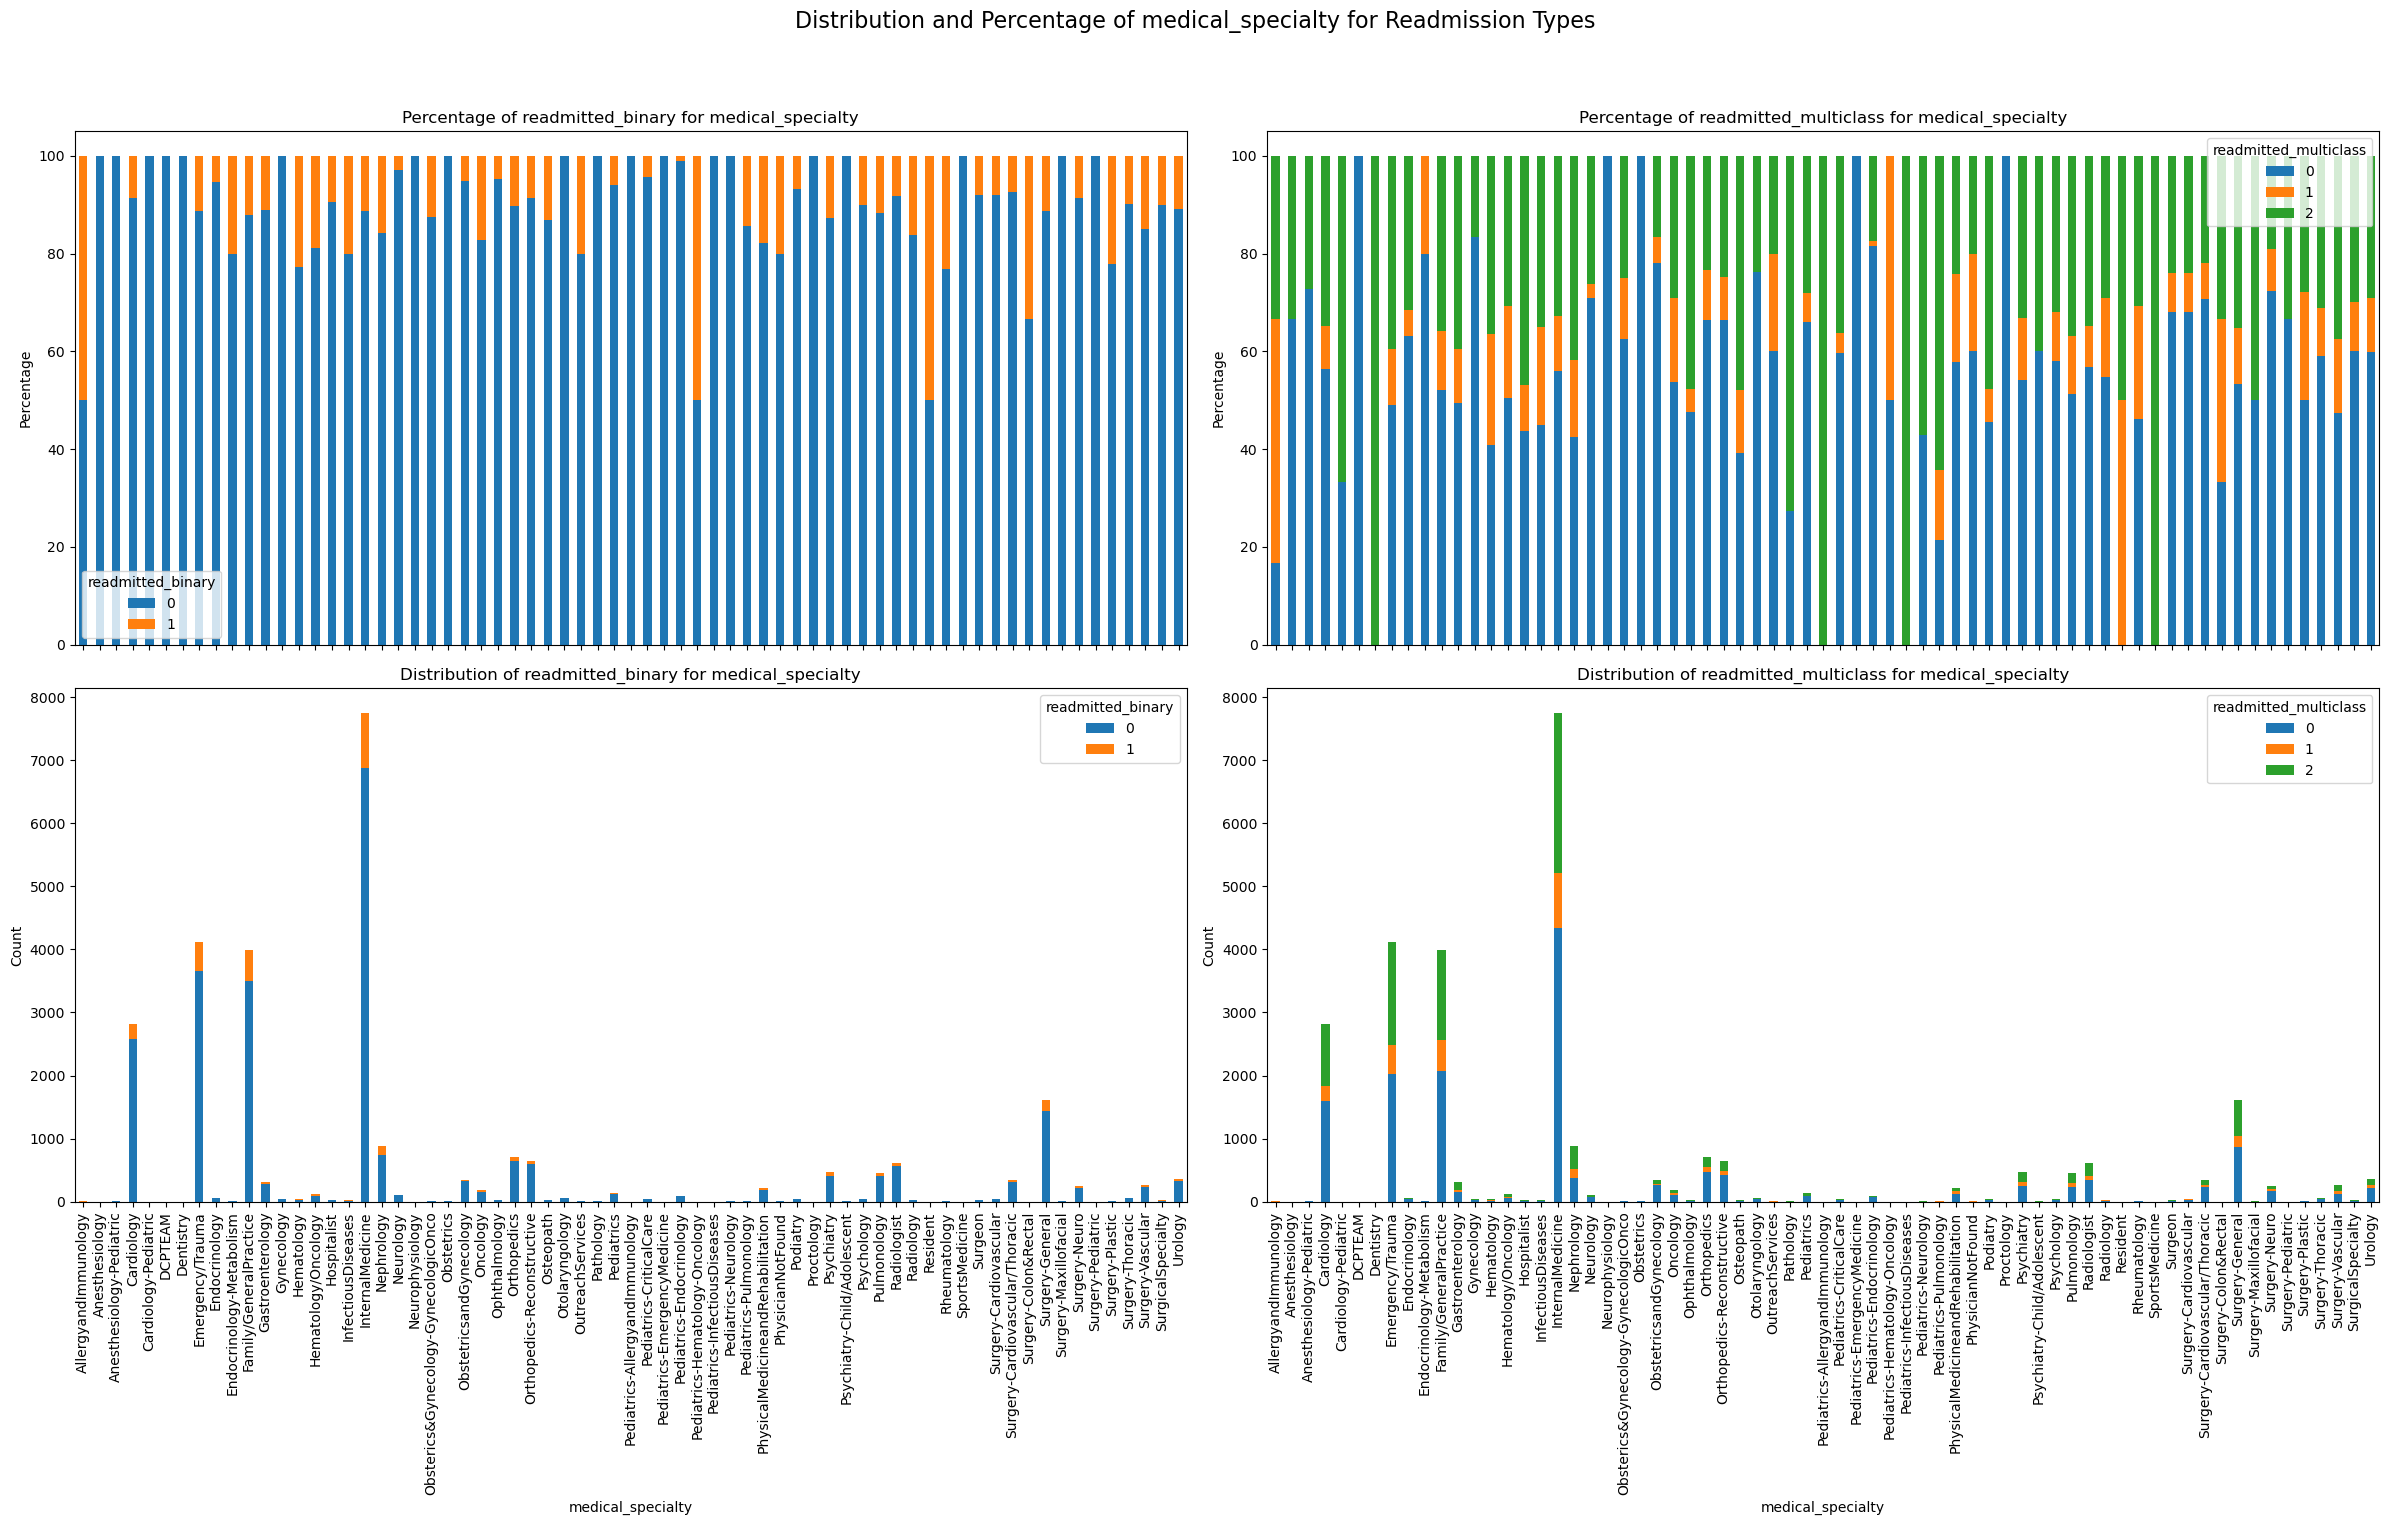

In [156]:
plot_categorical_distribution(data_train, 'medical_specialty')

In [157]:
# drop medical_specialty column since it has too many missing values
data_train.drop(['medical_specialty'], axis=1, inplace=True)
data_val.drop(['medical_specialty'], axis=1, inplace=True)
data_test.drop(['medical_specialty'], axis=1, inplace=True)


In [158]:
# tried and it is better to drop

#### average_pulse_bpm

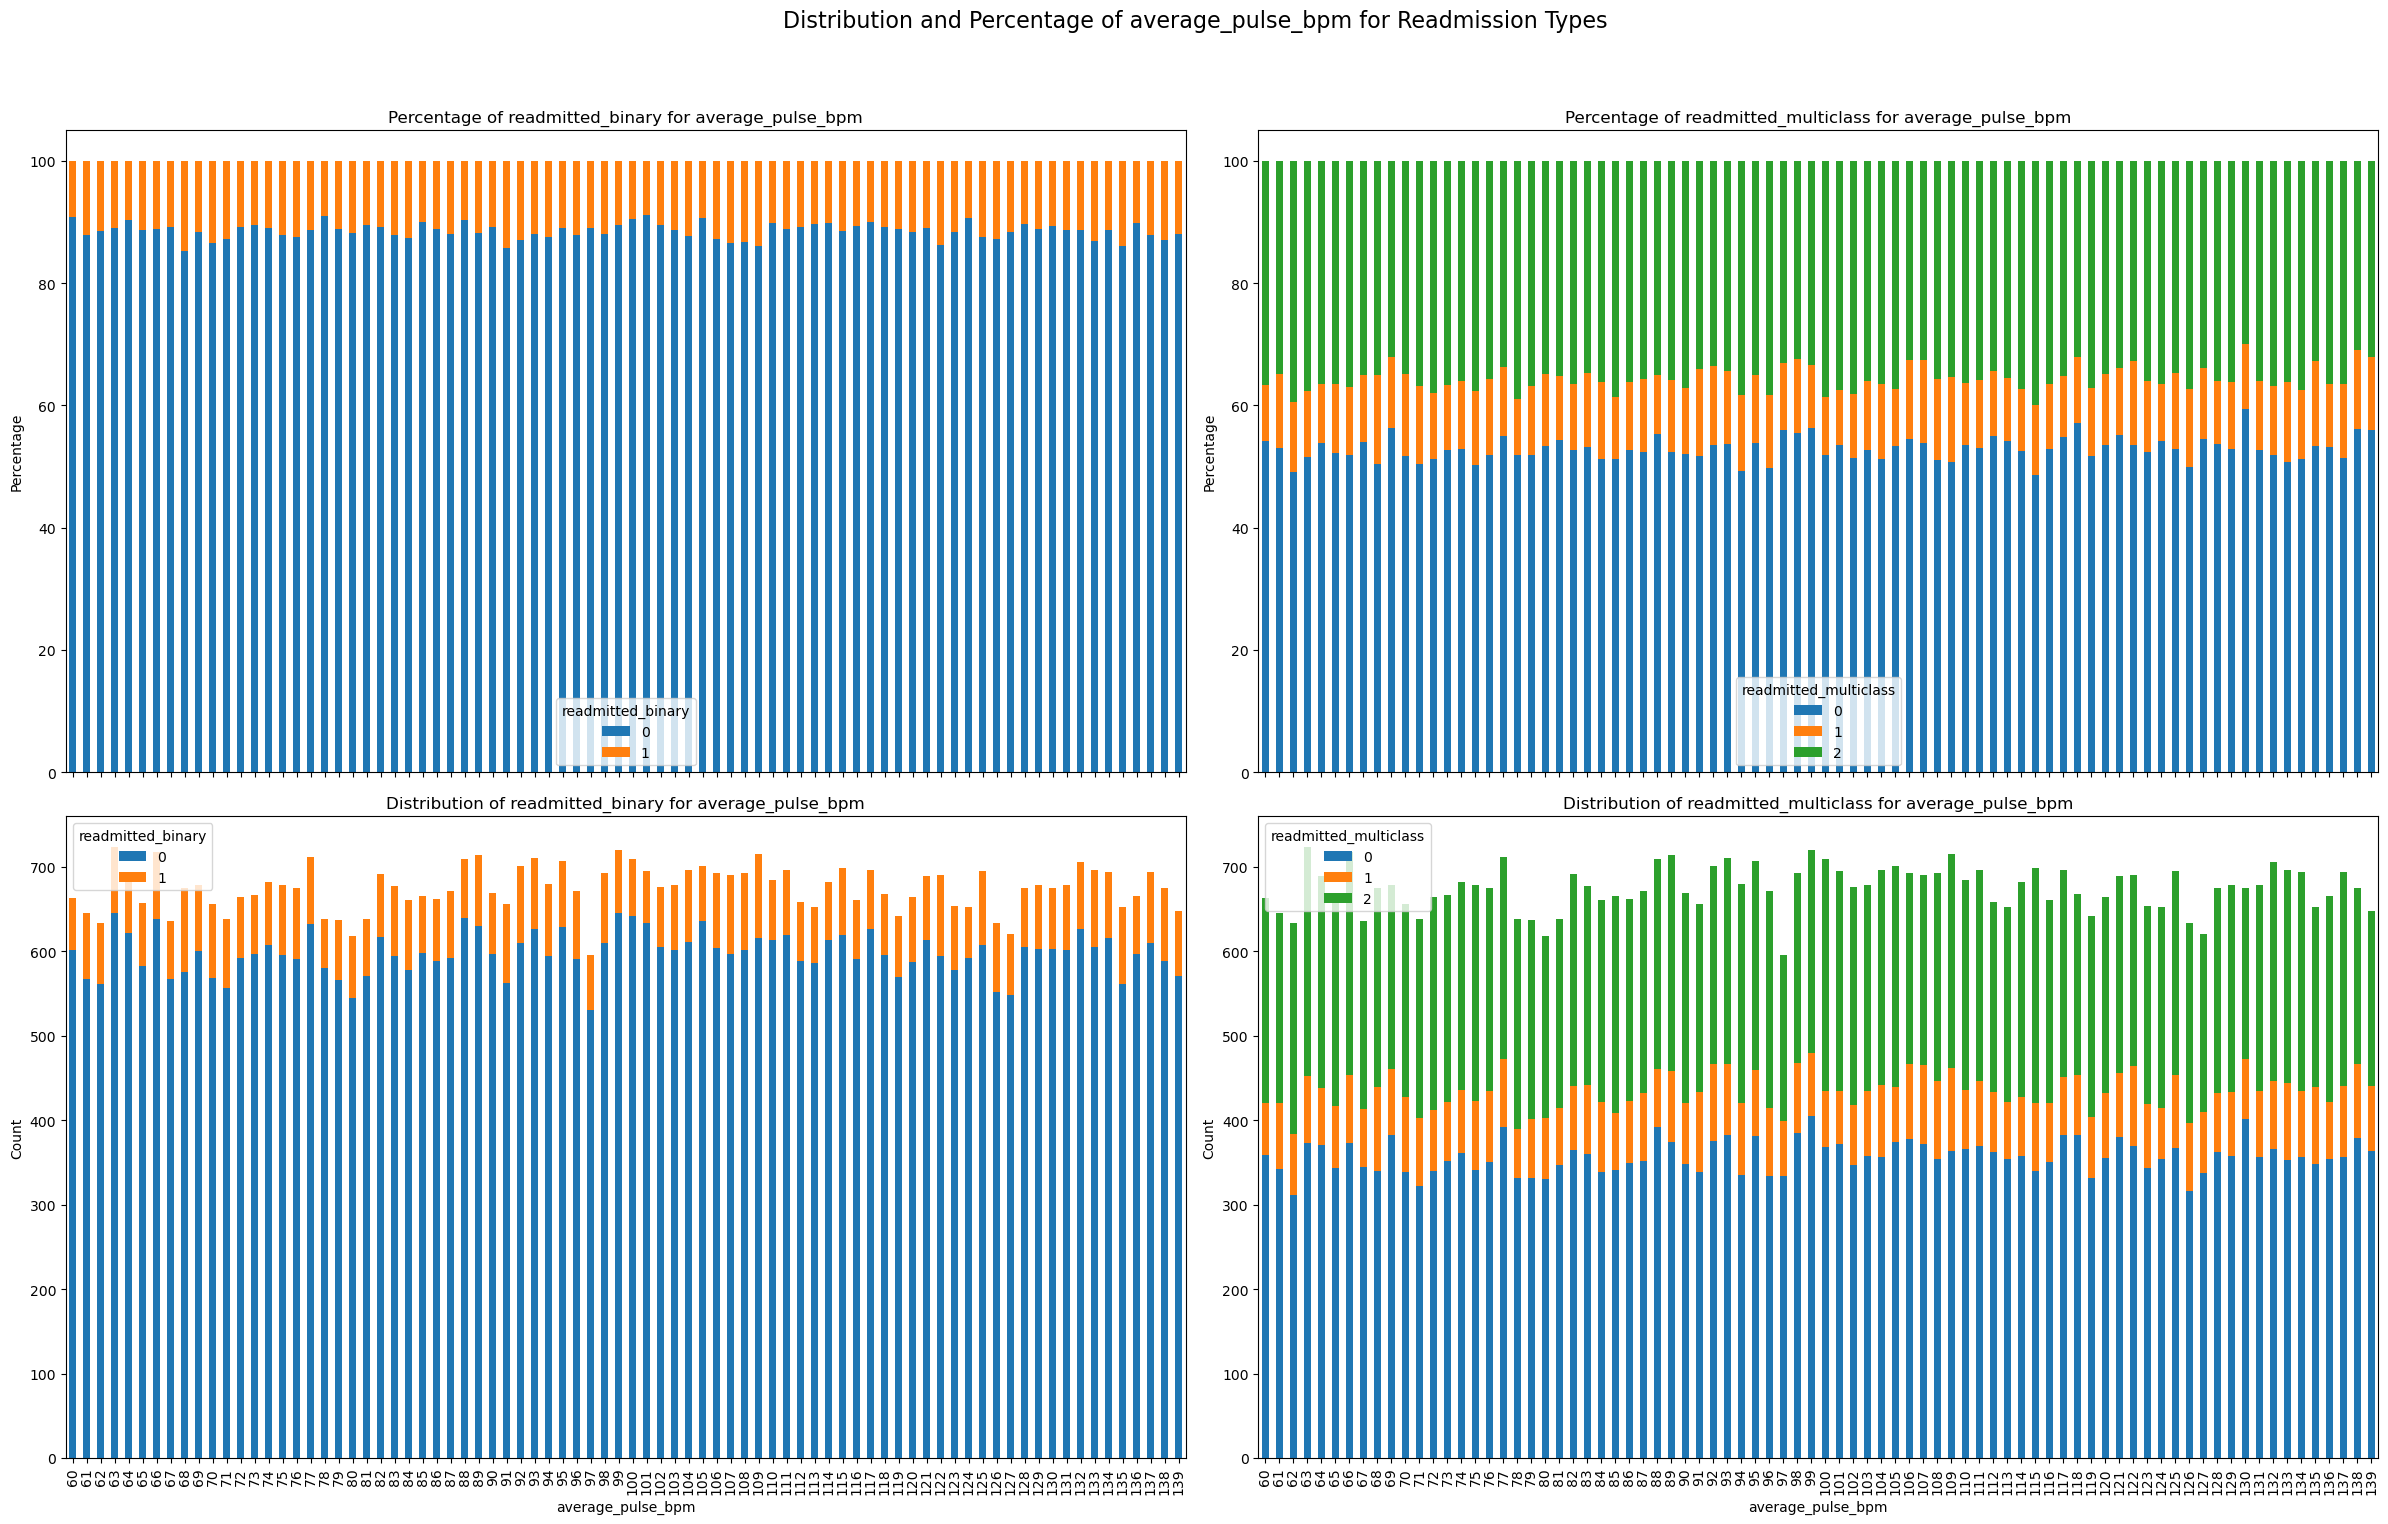

In [159]:
plot_categorical_distribution(data_train, 'average_pulse_bpm')

In [160]:
# as there is almost no variance in the data, we will drop
# data_train.drop(['average_pulse_bpm'], axis=1, inplace=True)
# data_val.drop(['average_pulse_bpm'], axis=1, inplace=True)
# data_test.drop(['average_pulse_bpm'], axis=1, inplace=True)

#### discharge_disposition

In [161]:
data_train['discharge_disposition'].value_counts()

discharge_disposition
Discharged to home                                                                                           31920
Discharged/transferred to SNF                                                                                 7346
Discharged/transferred to home with home health service                                                       6940
Discharged/transferred to another short term hospital                                                         1126
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1082
Expired                                                                                                        854
Discharged/transferred to another type of inpatient care institution                                           624
Not Mapped                                                                                                     528
Discharged/transferred to ICF                             

In [162]:
# fill missing values with 'Not Mapped'
data_train['discharge_disposition'] = data_train['discharge_disposition'].fillna('Missing')
data_val['discharge_disposition'] = data_val['discharge_disposition'].fillna('Missing')
data_test['discharge_disposition'] = data_test['discharge_disposition'].fillna('Missing')

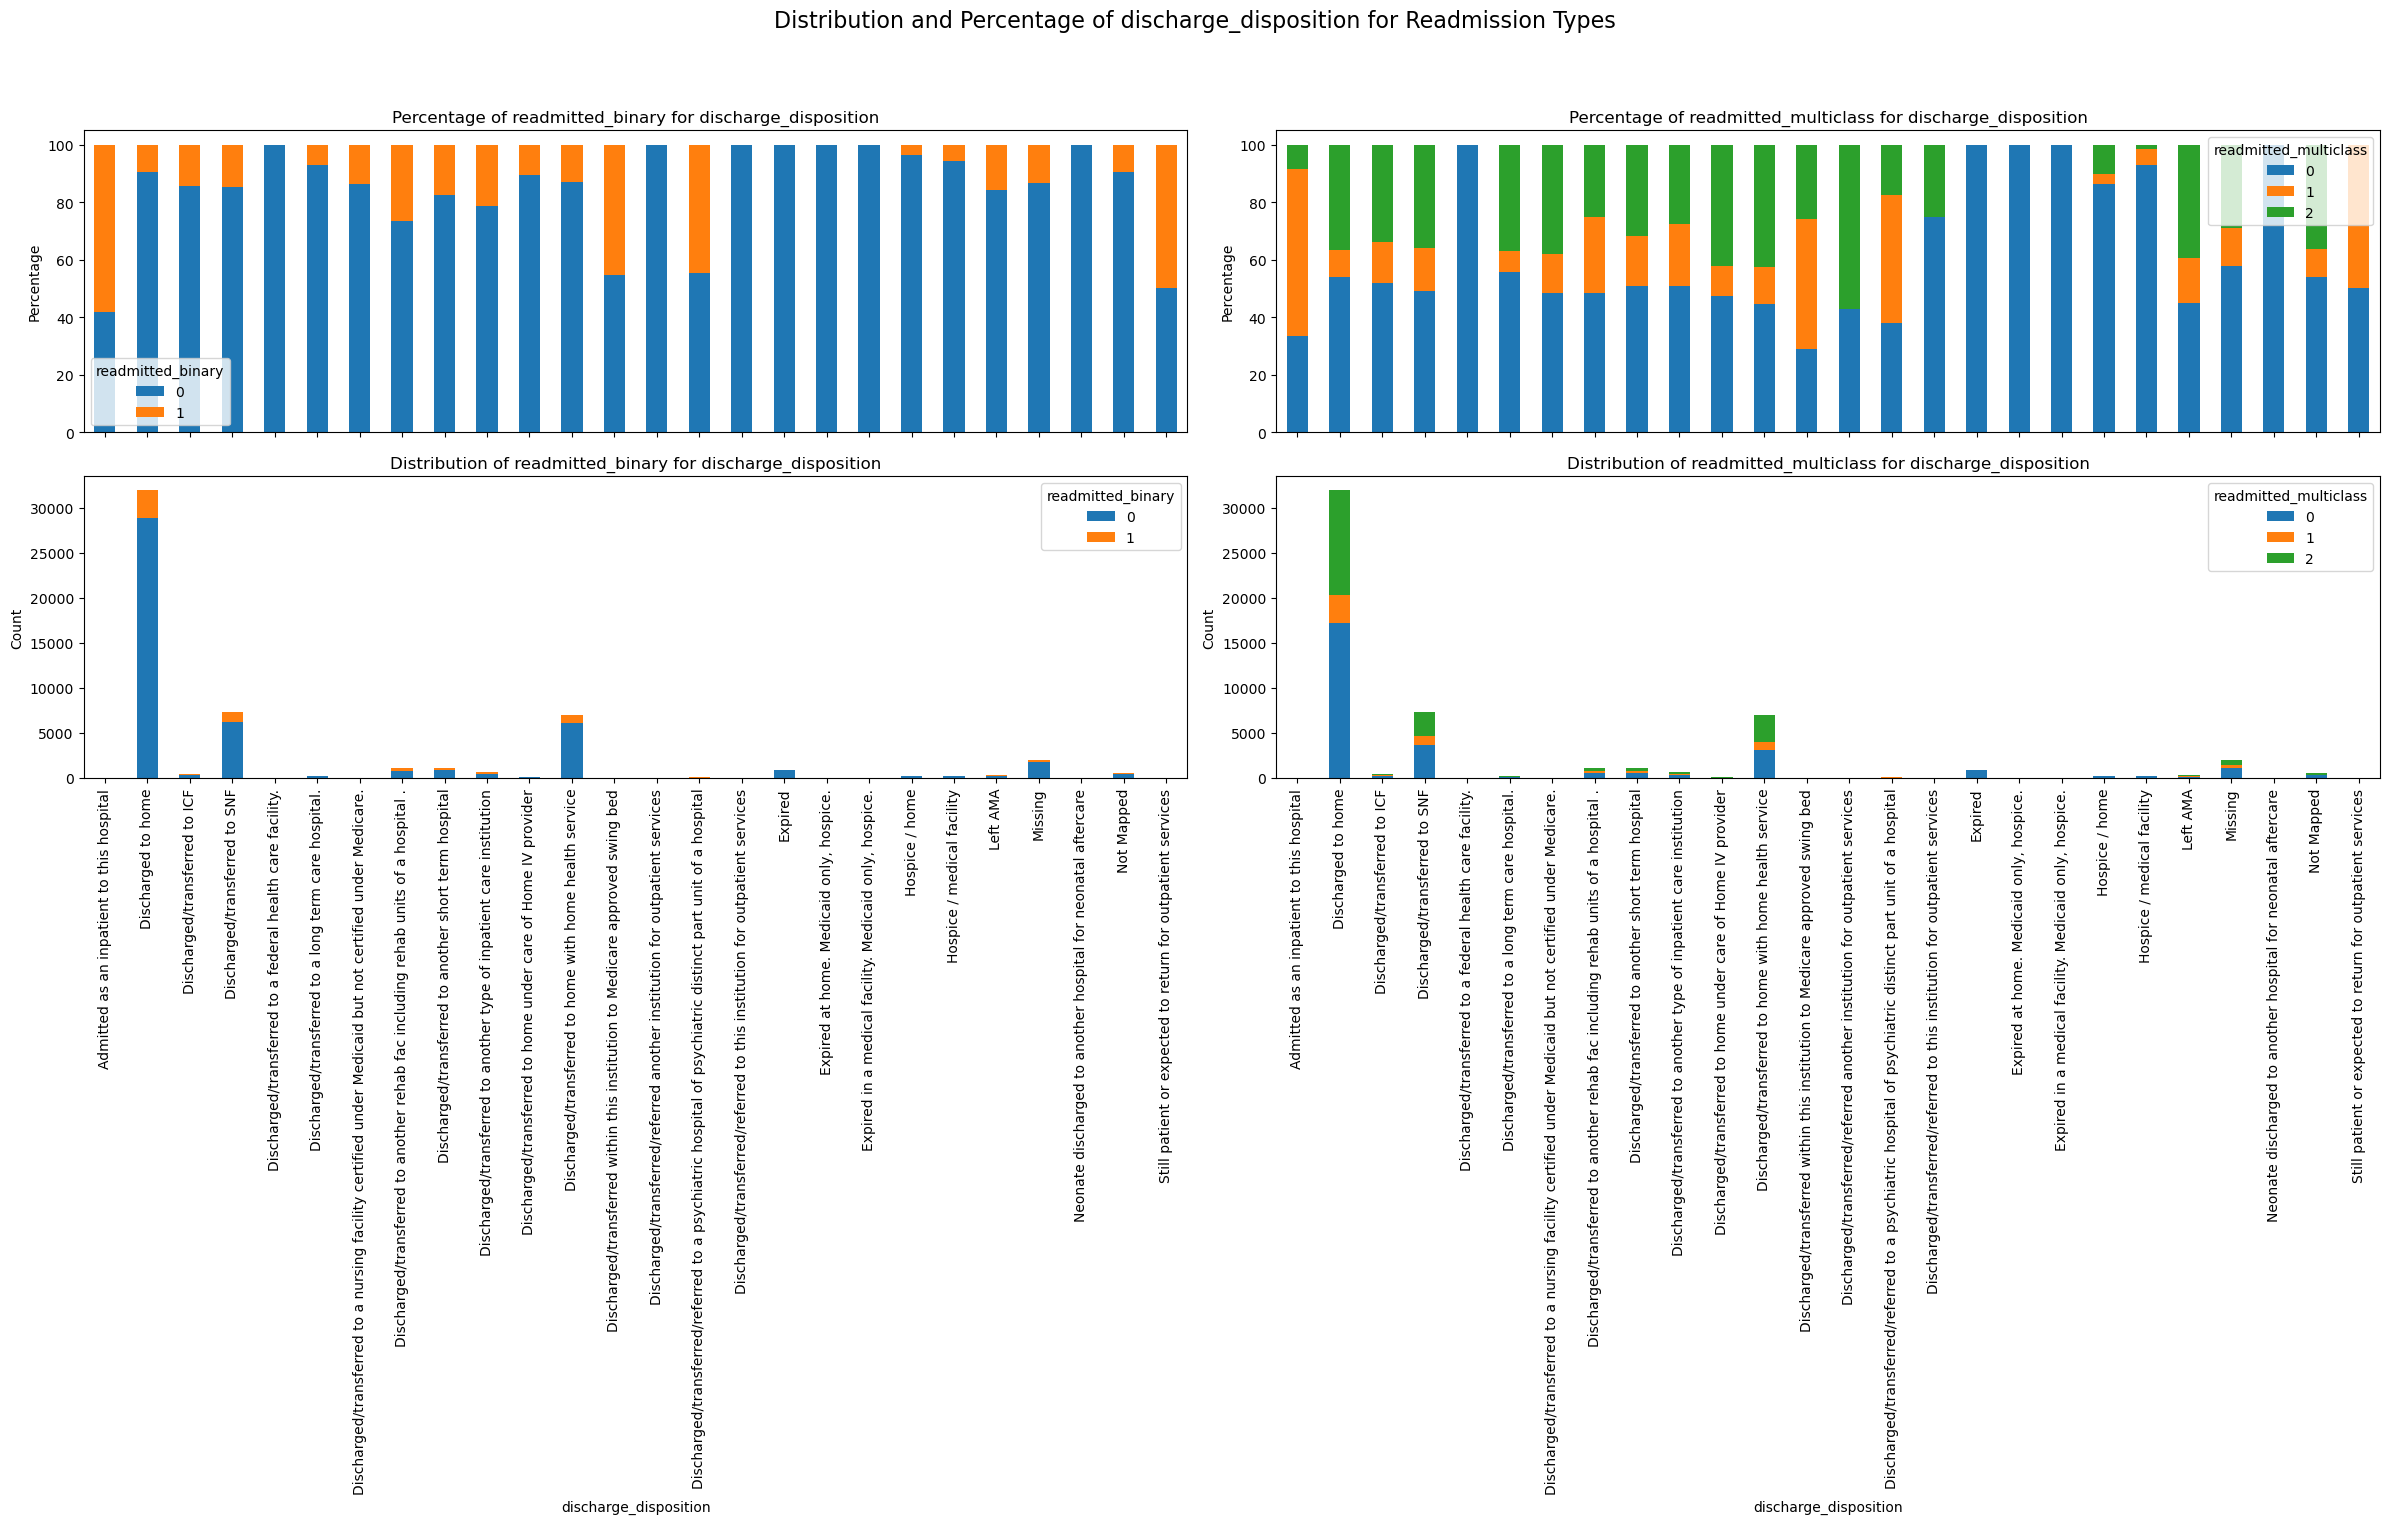

In [163]:
plot_categorical_distribution(data_train, 'discharge_disposition')

In [164]:
# show me difference in categories between data_train and data_test
print(set(data_train['discharge_disposition'].unique()) - set(data_test['discharge_disposition'].unique()))
print(set(data_test['discharge_disposition'].unique()) - set(data_train['discharge_disposition'].unique()))


set()
set()


In [165]:
data_train.groupby(['discharge_disposition', 'readmitted_binary']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack()

,readmitted_binary,0,1
discharge_disposition,discharge_disposition,,
Admitted as an inpatient to this hospital,Admitted as an inpatient to this hospital,41.666667,58.333333
Discharged to home,Discharged to home,90.435464,9.564536
Discharged/transferred to ICF,Discharged/transferred to ICF,85.714286,14.285714
Discharged/transferred to SNF,Discharged/transferred to SNF,85.202831,14.797169
Discharged/transferred to a federal health care facility.,Discharged/transferred to a federal health care facility.,100.000000,NaN
Discharged/transferred to a long term care hospital.,Discharged/transferred to a long term care hospital.,92.957746,7.042254
Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.,Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.,86.206897,13.793103
Discharged/transferred to another rehab fac including rehab units of a hospital .,Discharged/transferred to another rehab fac including rehab units of a hospital .,73.475046,26.524954
Discharged/transferred to another short term hospital,Discharged/transferred to another short term hospital,82.682060,17.317940


In [166]:
# combine categories that have 0% readmission rate or dimensionality reduction as they all would do same predictions anyway

data_train['discharge_disposition'] = data_train['discharge_disposition'].replace(['Discharged/transferred to a federal health care facility.', 'Discharged/transferred/referred to this institution for outpatient services', 'Discharged/transferred/referred another institution for outpatient services', 'Expired in a medical facility. Medicaid only, hospice.', 'Expired at home. Medicaid only, hospice.', 'Expired'], '100% Discharged')


data_val['discharge_disposition'] = data_val['discharge_disposition'].replace(['Discharged/transferred to a federal health care facility.', 'Discharged/transferred/referred to this institution for outpatient services', 'Discharged/transferred/referred another institution for outpatient services', 'Expired in a medical facility. Medicaid only, hospice.', 'Expired at home. Medicaid only, hospice.', 'Expired'], '100% Discharged')


data_test['discharge_disposition'] = data_test['discharge_disposition'].replace(['Discharged/transferred to a federal health care facility.', 'Discharged/transferred/referred to this institution for outpatient services', 'Discharged/transferred/referred another institution for outpatient services', 'Expired in a medical facility. Medicaid only, hospice.', 'Expired at home. Medicaid only, hospice.', 'Expired'], '100% Discharged')



In [167]:
# we used to combine not mapped and missing but since the readmission rates are so different and therefore their predictions will be different, we will keep them seperate.

#### admission_source

In [168]:
data_train['admission_source'].value_counts()

admission_source
 Emergency Room                                               30760
 Physician Referral                                           15663
Transfer from a hospital                                       1636
 Transfer from another health care facility                    1036
Clinic Referral                                                 560
 Transfer from a Skilled Nursing Facility (SNF)                 446
HMO Referral                                                    101
 Not Mapped                                                      83
 Not Available                                                   31
 Court/Law Enforcement                                            9
 Transfer from hospital inpt/same fac reslt in a sep claim        6
 Transfer from critial access hospital                            5
 Transfer from Ambulatory Surgery Center                          2
Normal Delivery                                                   1
 Extramural Birth              

In [169]:
# fill missing values with 'Missing'
data_train['admission_source'] = data_train['admission_source'].fillna('Missing')
data_val['admission_source'] = data_val['admission_source'].fillna('Missing')
data_test['admission_source'] = data_test['admission_source'].fillna('Missing')

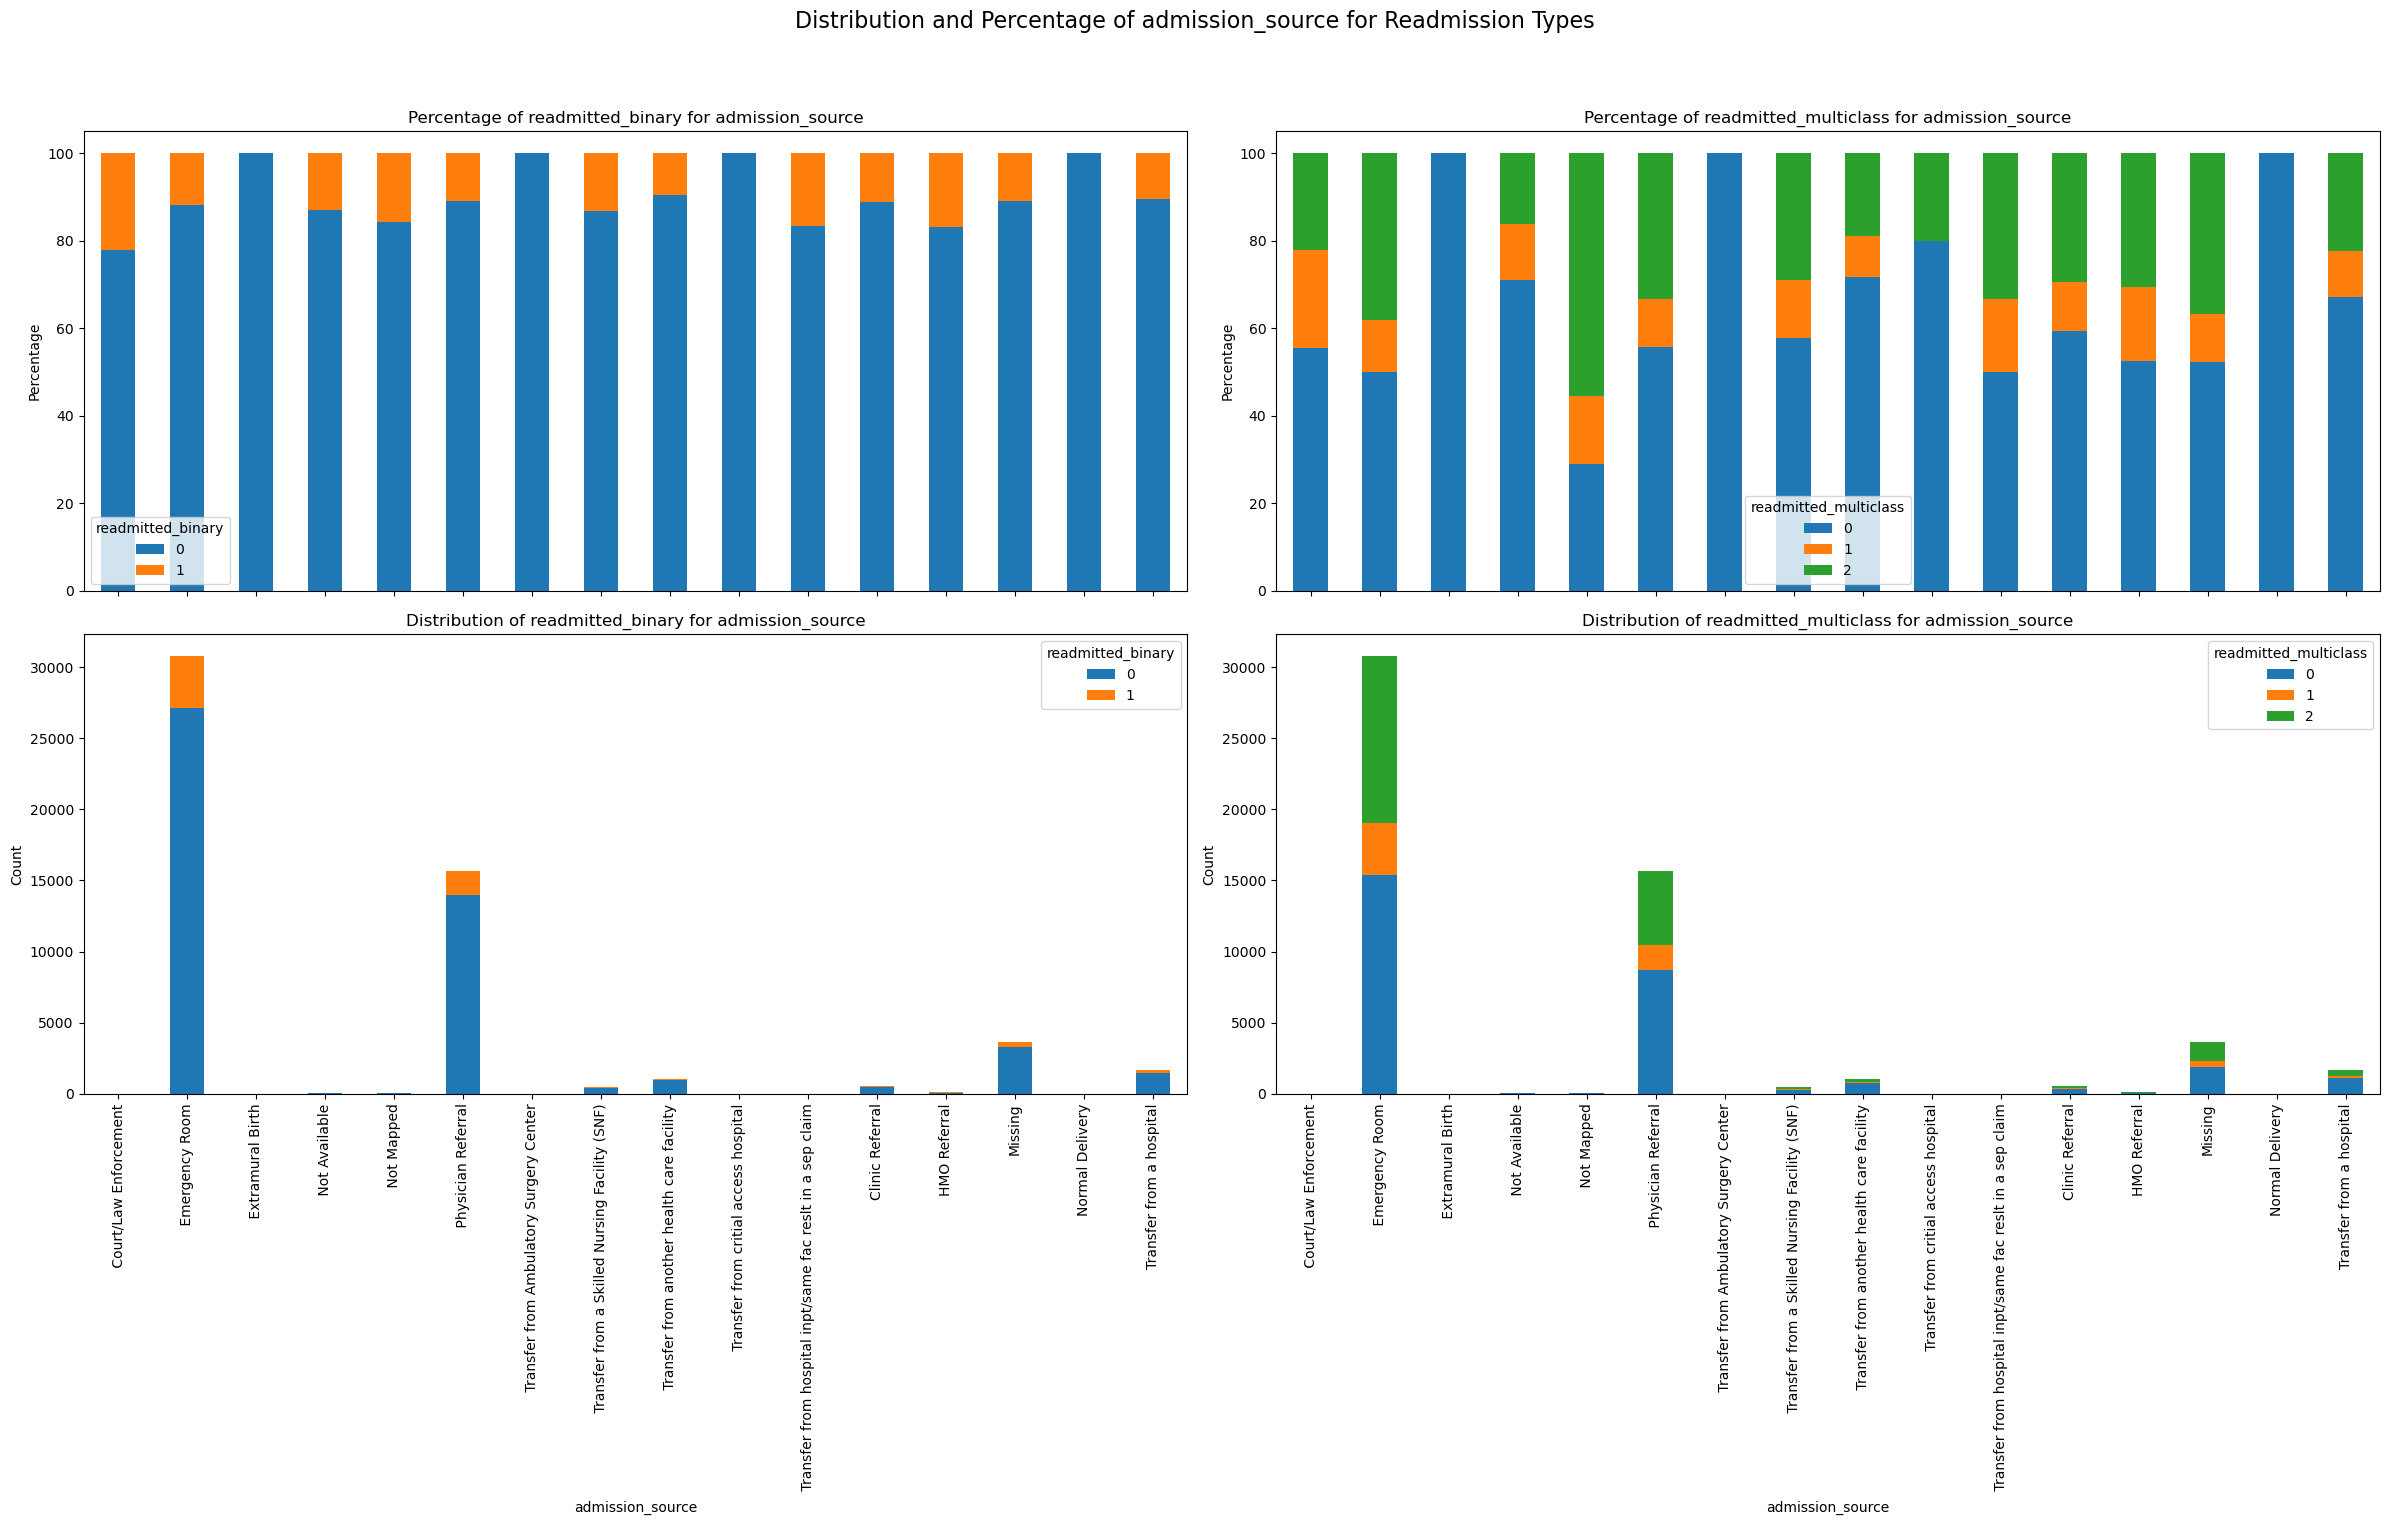

In [170]:
plot_categorical_distribution(data_train, 'admission_source')

In [171]:
data_train.groupby(['admission_source', 'readmitted_binary']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack()

,readmitted_binary,0,1
admission_source,admission_source,,
Court/Law Enforcement,Court/Law Enforcement,77.777778,22.222222
Emergency Room,Emergency Room,88.150195,11.849805
Extramural Birth,Extramural Birth,100.000000,NaN
Not Available,Not Available,87.096774,12.903226
Not Mapped,Not Mapped,84.337349,15.662651
Physician Referral,Physician Referral,89.152780,10.847220
Transfer from Ambulatory Surgery Center,Transfer from Ambulatory Surgery Center,100.000000,NaN
Transfer from a Skilled Nursing Facility (SNF),Transfer from a Skilled Nursing Facility (SNF),86.771300,13.228700
Transfer from another health care facility,Transfer from another health care facility,90.540541,9.459459


In [172]:
# we used to combine not mapped, not available and missing but since the readmission rates are so different and therefore their predictions will be different, we will keep them seperate.
# What we will do though is to combine the categories that have 0% readmission rate or dimensionality reduction as they all would do same predictions anyway

In [173]:
# combine similar values based on training data
replace_dict = {' Sick Baby': 'Categories with no readmission', 'Categories with no readmission': 'Baby Delivery', ' Extramural Birth': 'Categories with no readmission', ' Transfer from critial access hospital': 'Categories with no readmission', ' Transfer from Ambulatory Surgery Center': 'Categories with no readmission'}

data_train['admission_source'].replace(replace_dict, inplace=True)
data_val['admission_source'].replace(replace_dict, inplace=True)
data_test['admission_source'].replace(replace_dict, inplace=True)

#### length_of_stay_in_hospital

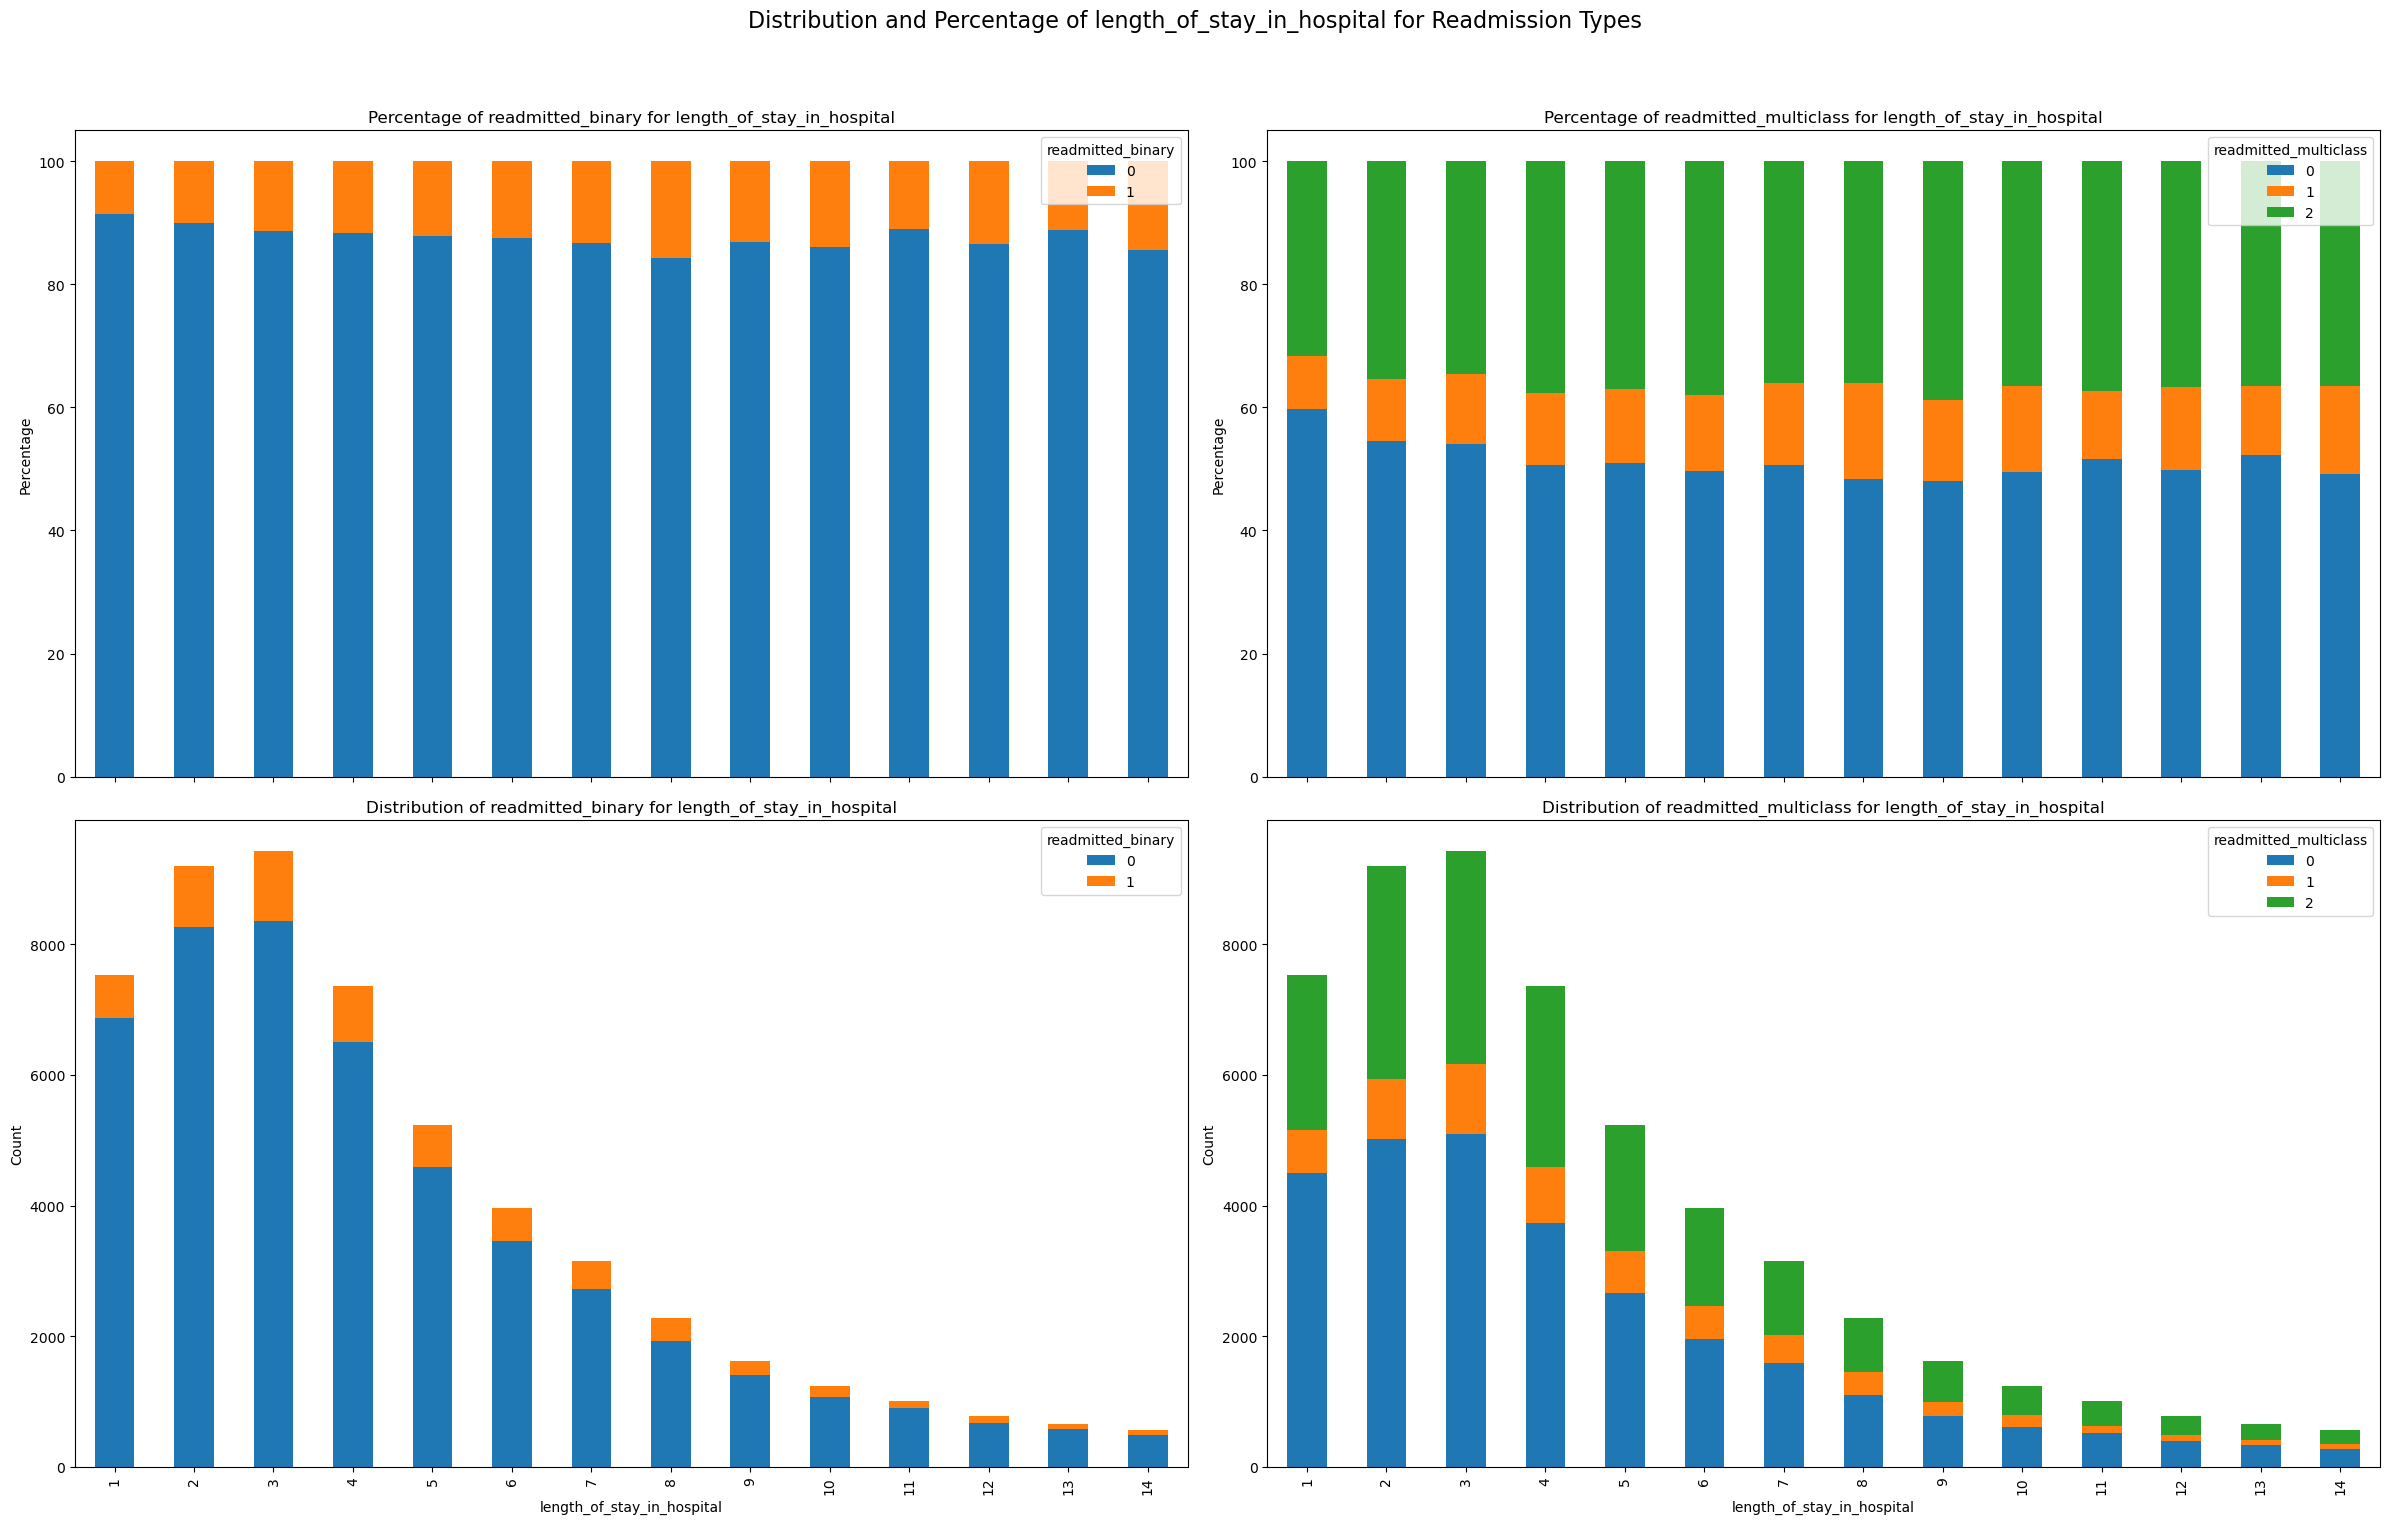

In [174]:
plot_categorical_distribution(data_train, 'length_of_stay_in_hospital')

In [175]:
# we keep as it is, no real outliers

#### number_lab_tests

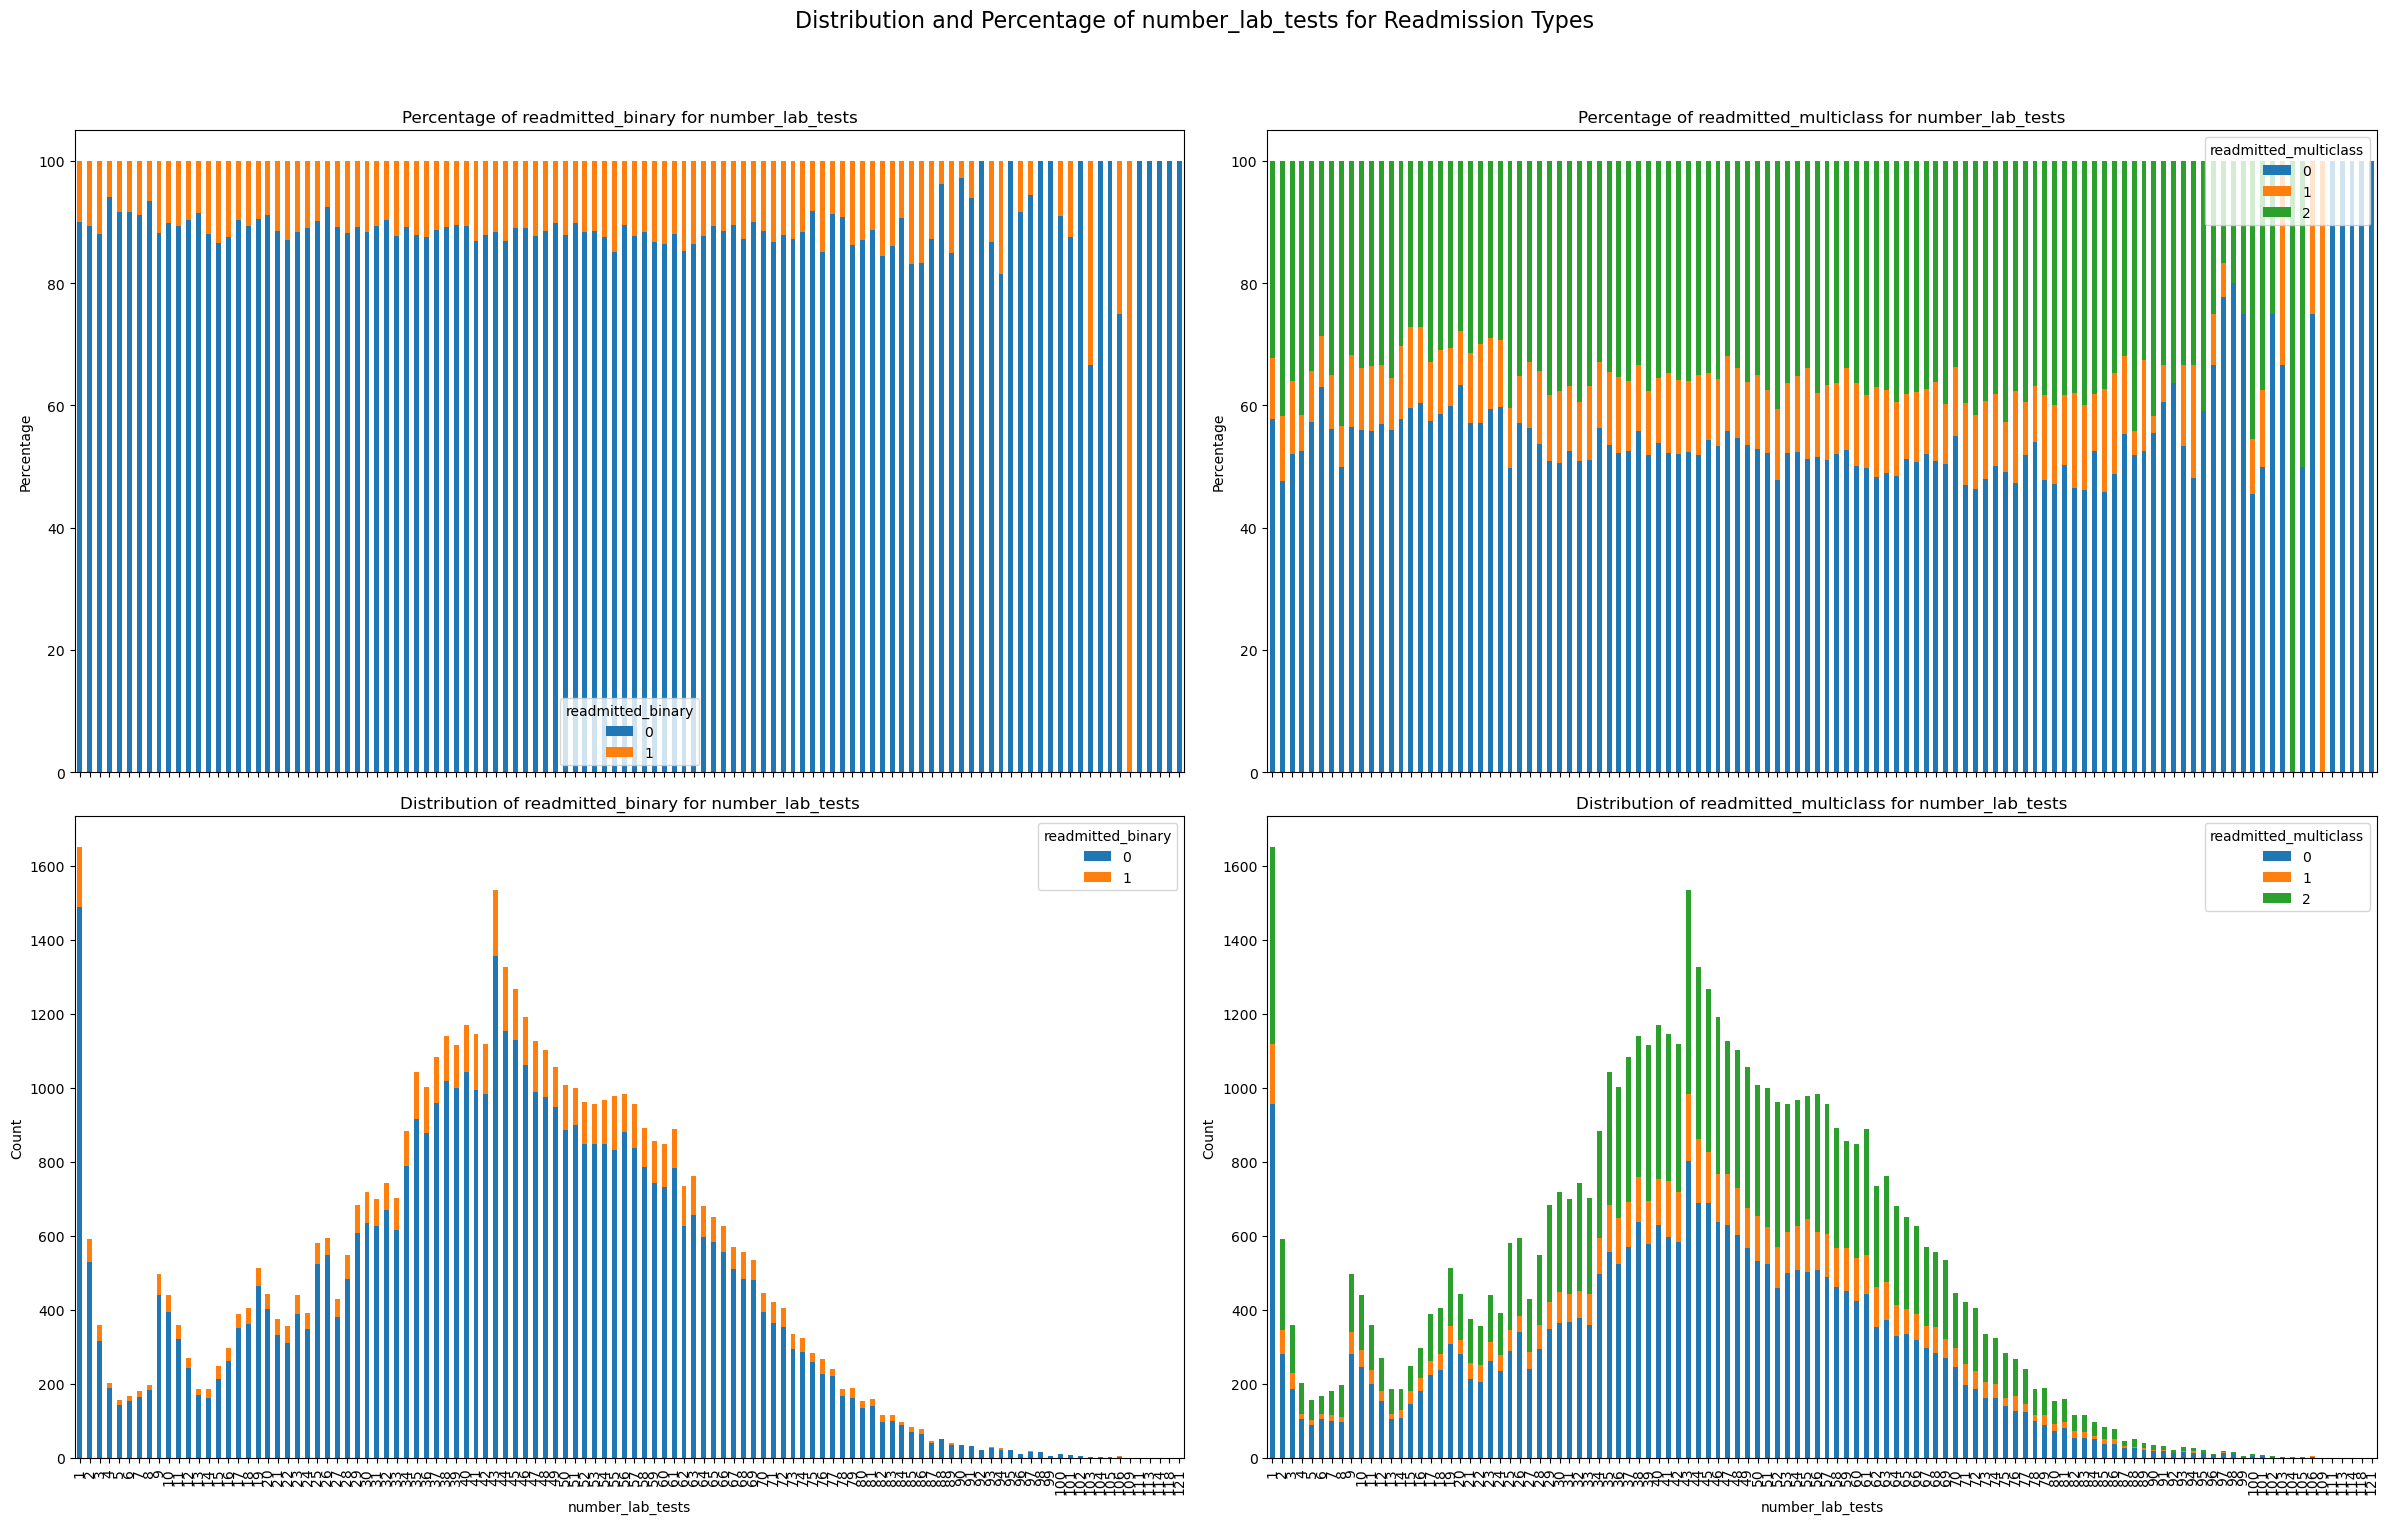

In [176]:
plot_categorical_distribution(data_train, 'number_lab_tests')

In [177]:
# give me only the column number_lab_tests and readmission_binary
data_train[['number_lab_tests', 'readmitted_binary']]
# show me only the 10 highest number_lab_tests
data_train[['number_lab_tests', 'readmitted_binary']].sort_values(by='number_lab_tests', ascending=False).head(10)


,number_lab_tests,readmitted_binary
encounter_id,,
741458,121,0
766865,118,0
932353,114,0
676089,113,0
297812,111,0
198036,109,1
738285,106,0
647726,106,0
855657,106,0


In [178]:
# clip outliers at 111 for number_lab_tests as we will only have 0 readmission after 111 tests
data_train['number_lab_tests'] = data_train['number_lab_tests'].clip(upper=111)
data_val['number_lab_tests'] = data_val['number_lab_tests'].clip(upper=111)
data_test['number_lab_tests'] = data_test['number_lab_tests'].clip(upper=111)

#### non_lab_procedures

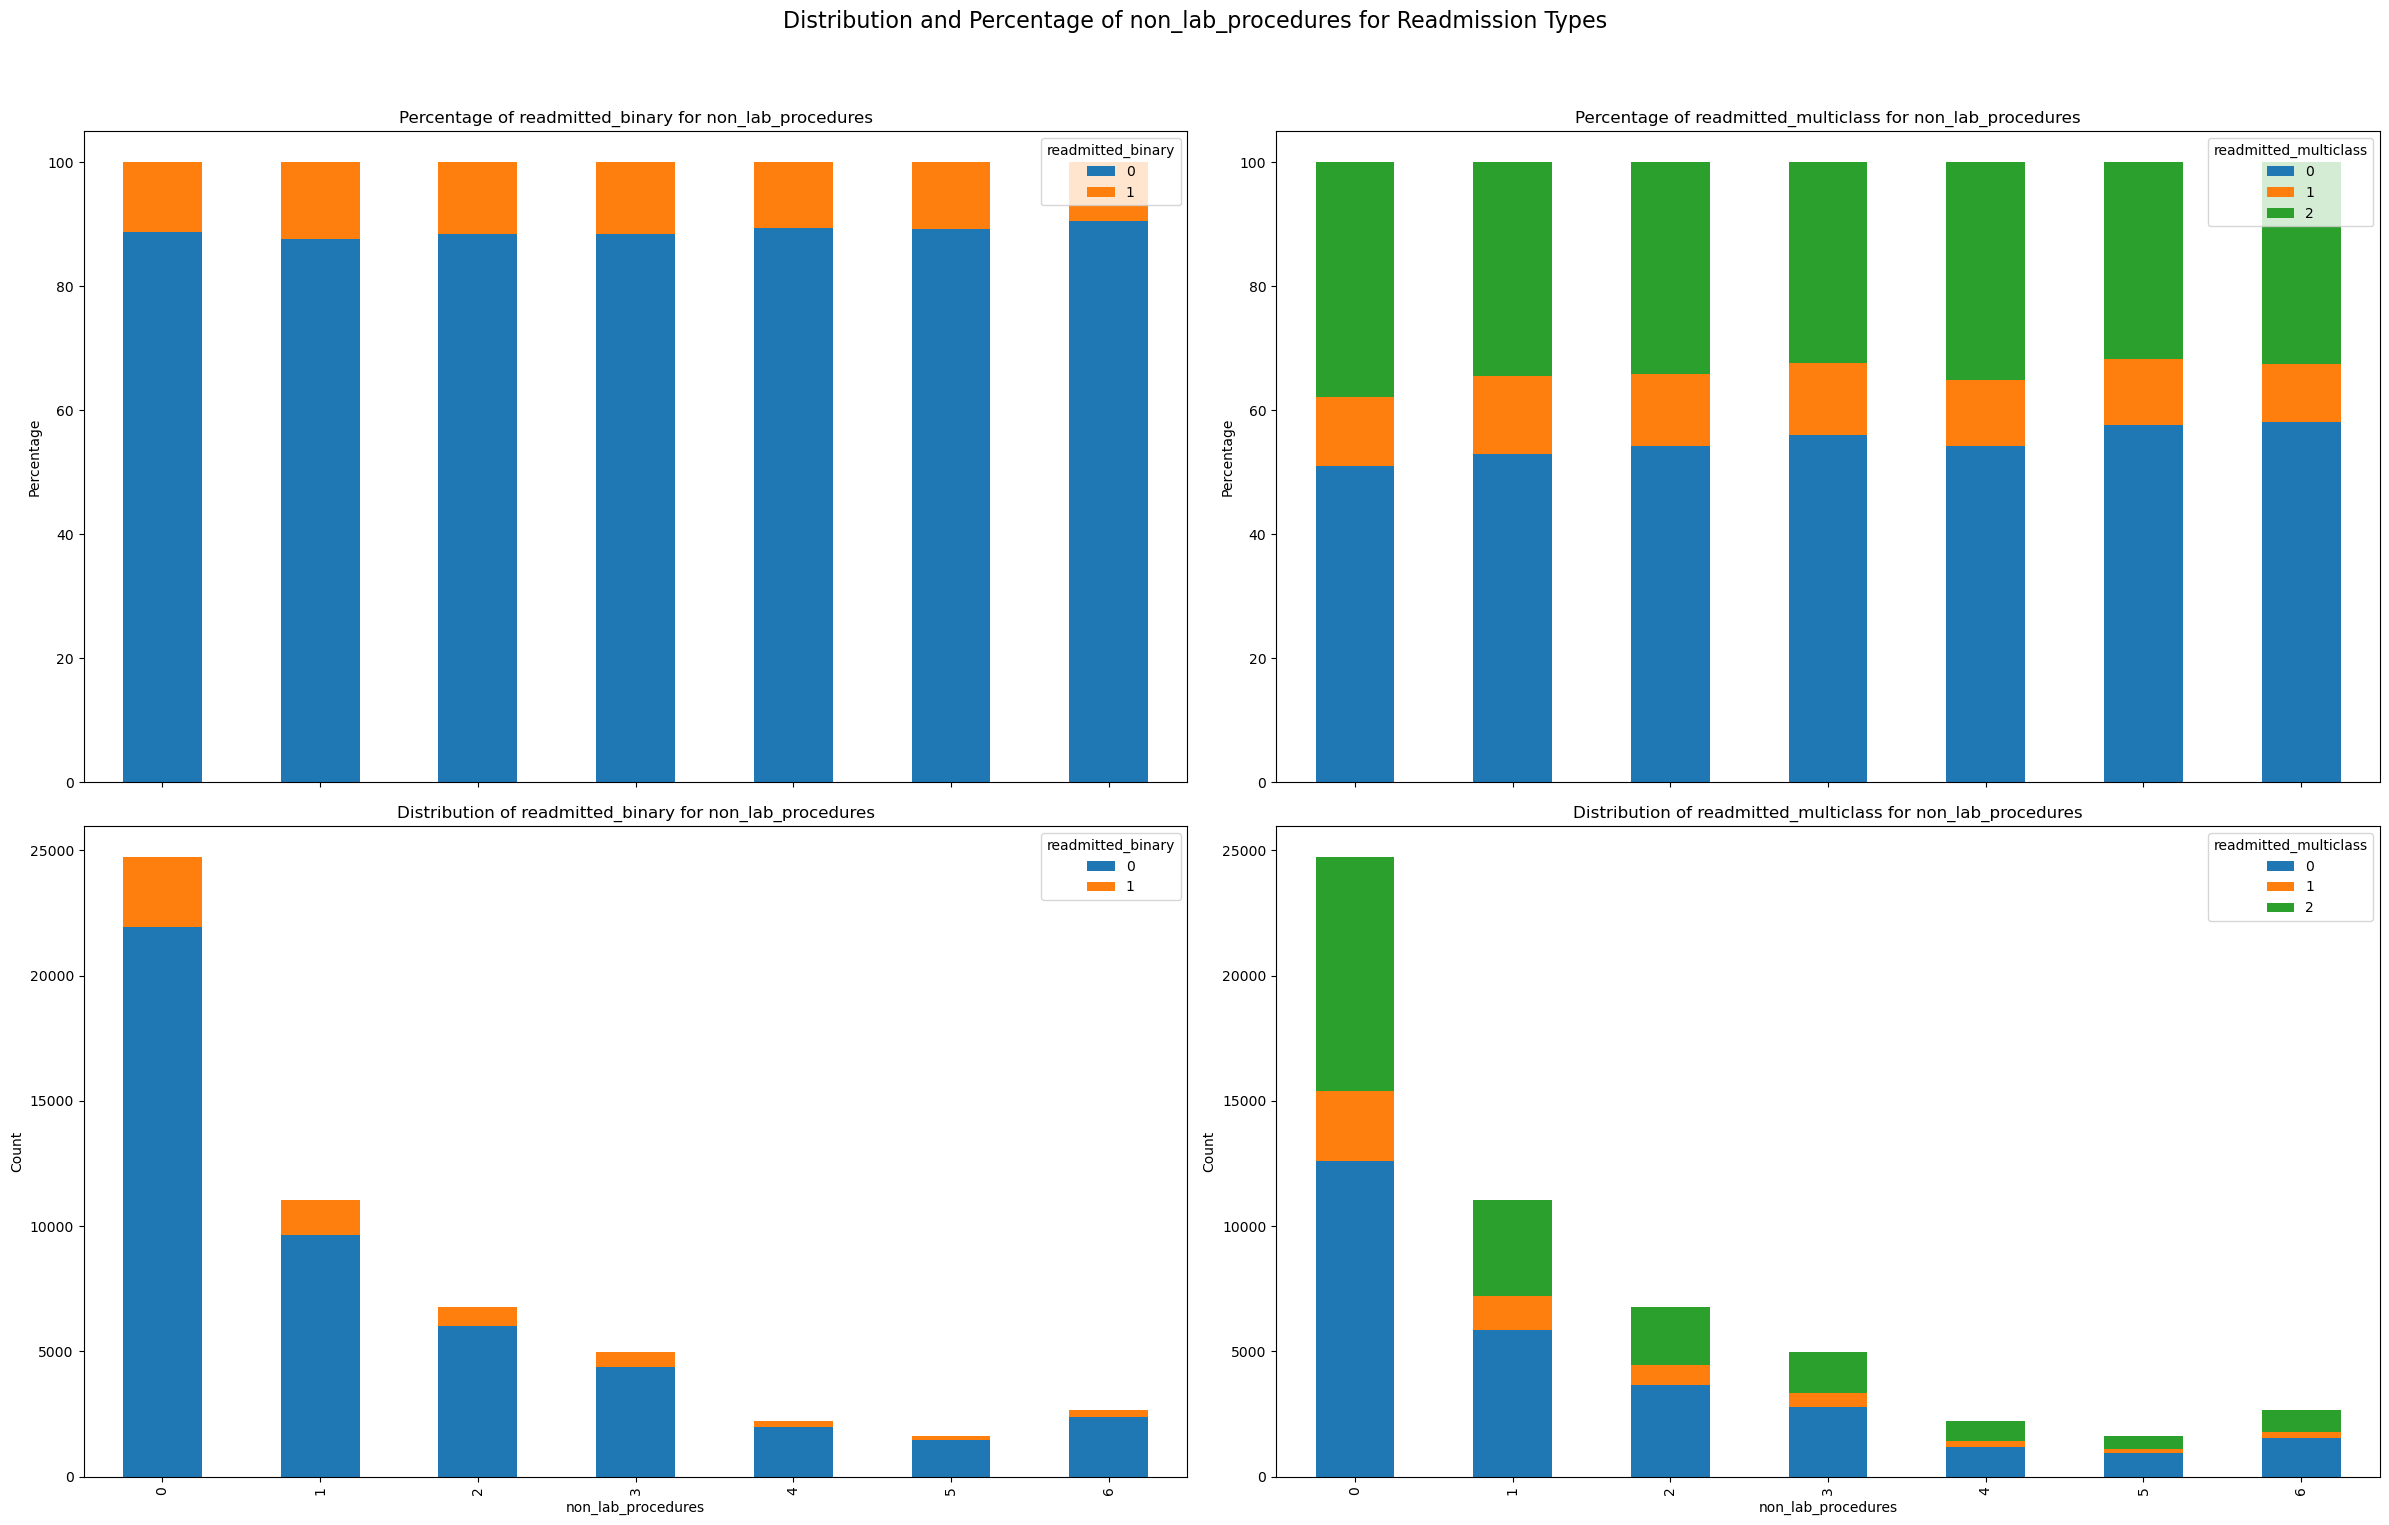

In [179]:
plot_categorical_distribution(data_train, 'non_lab_procedures')

In [180]:
# keep as it is for now

#### number_of_medications

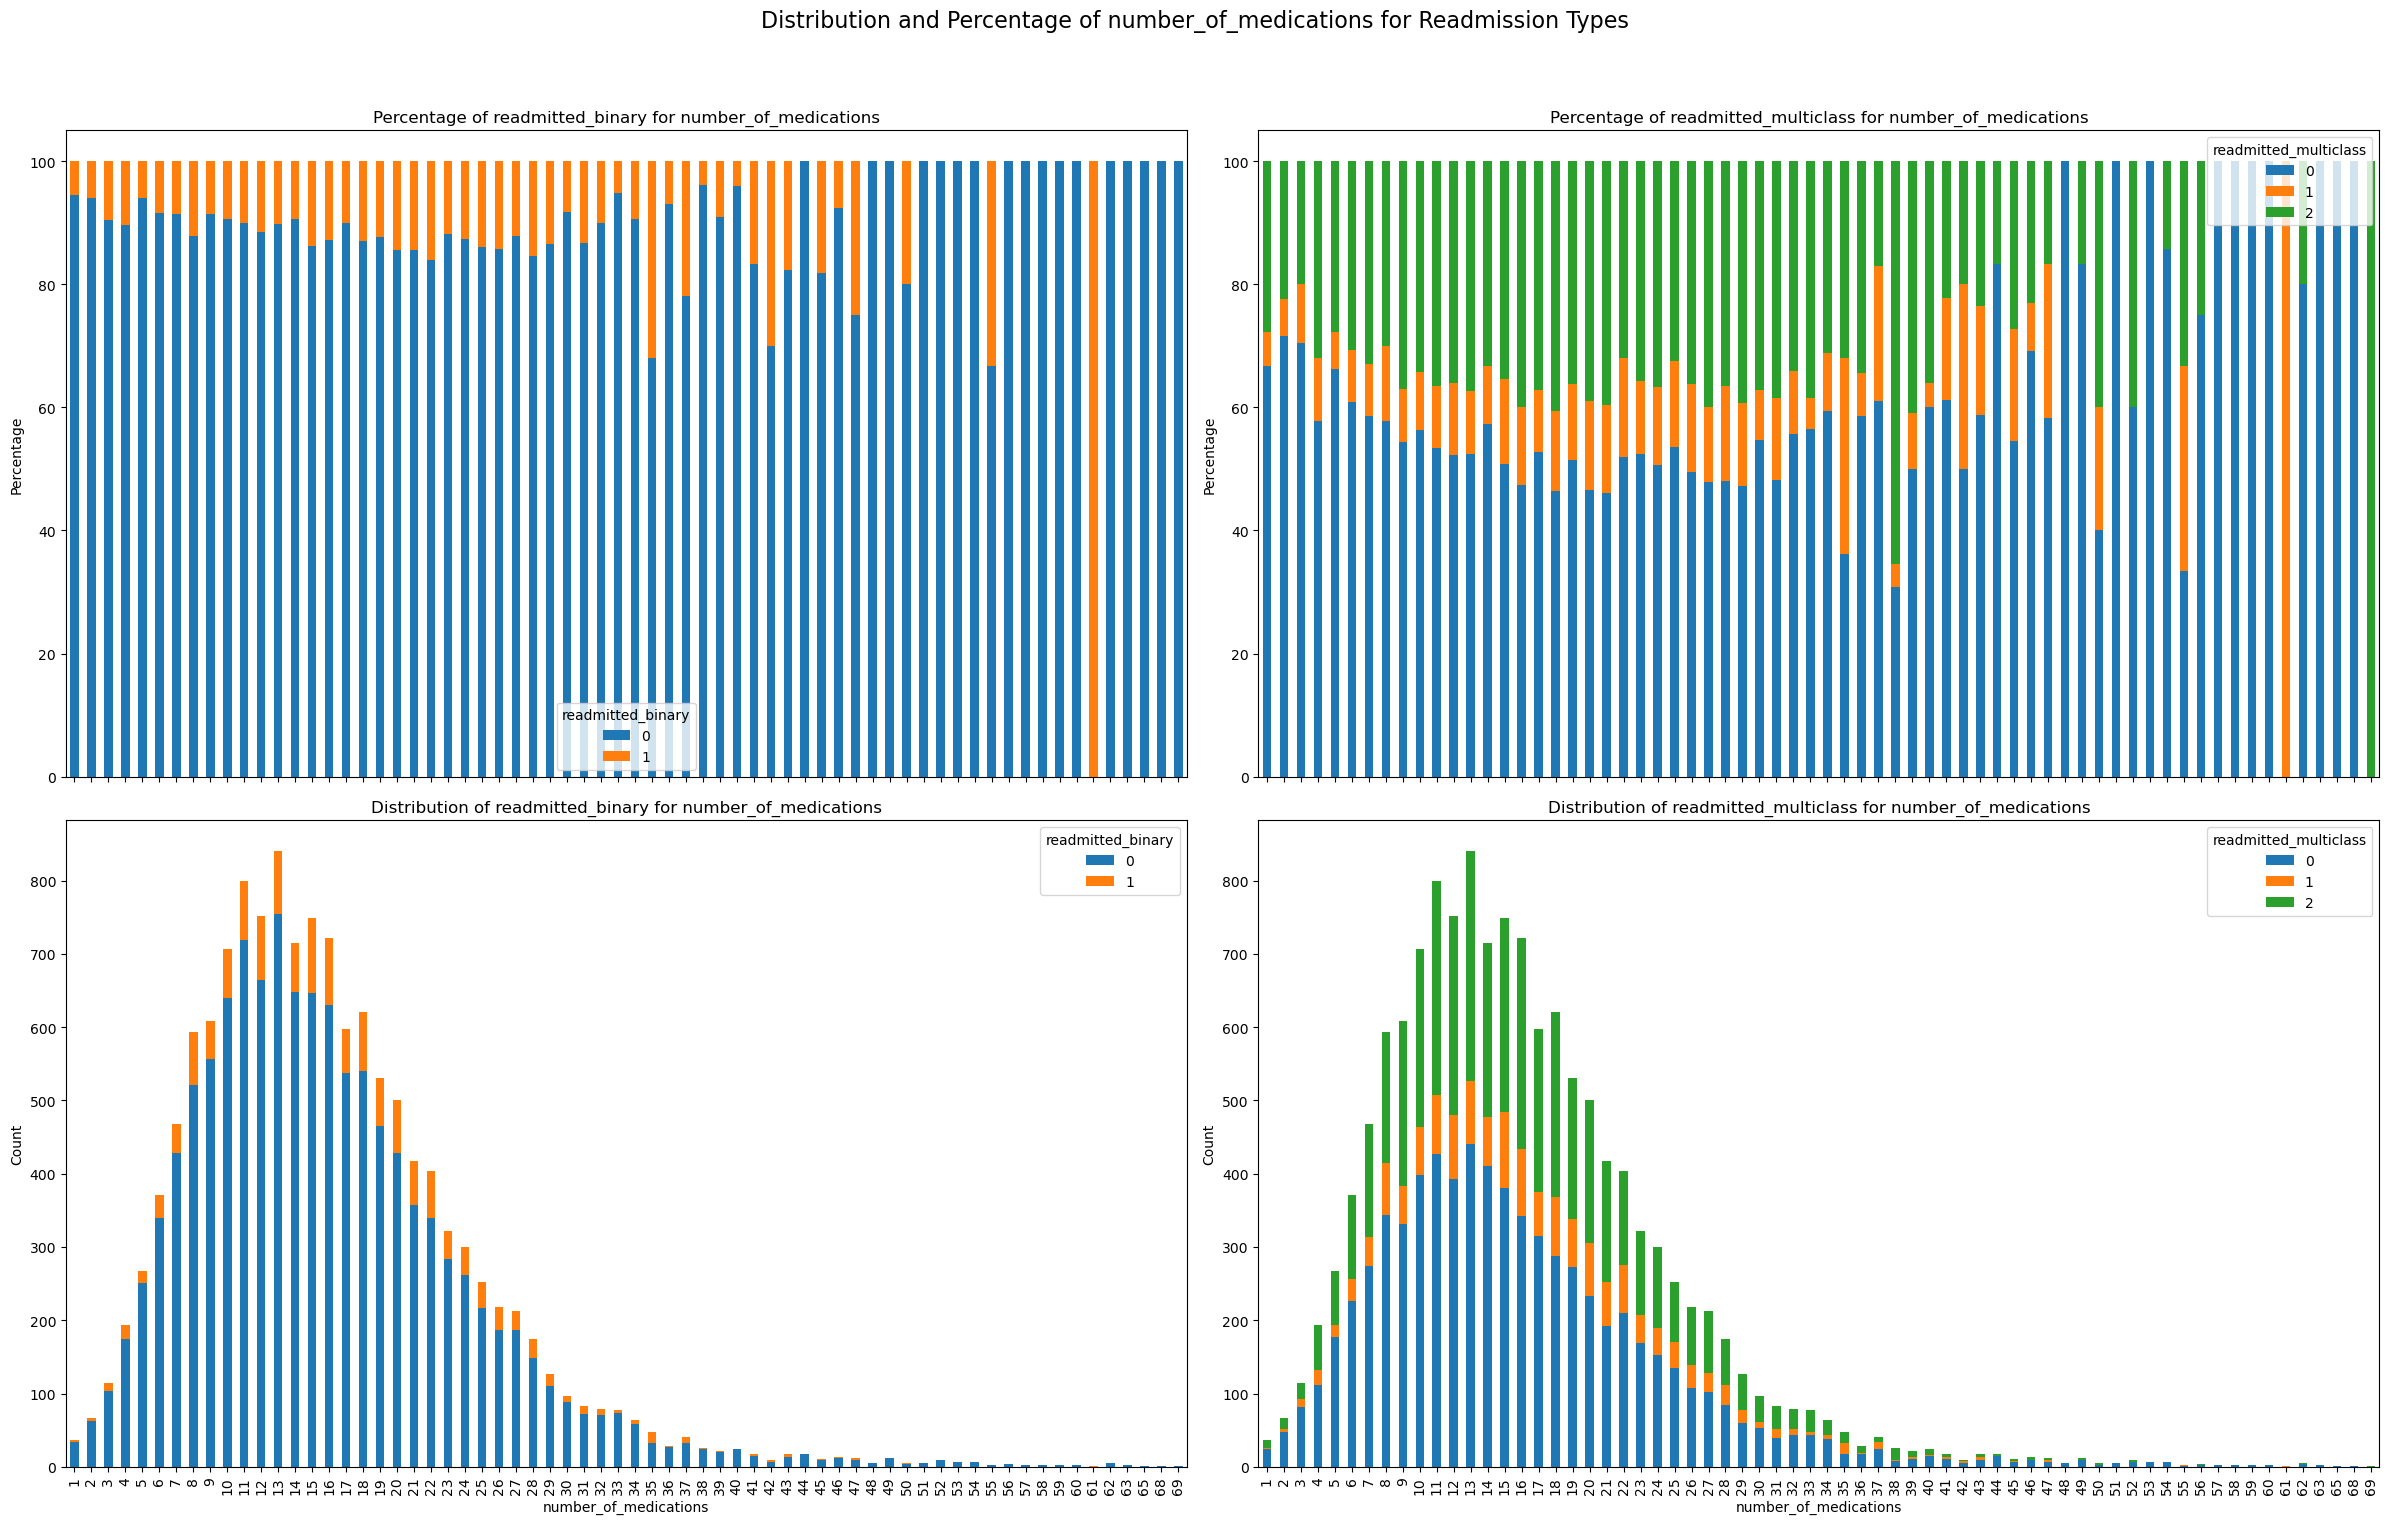

In [181]:
plot_categorical_distribution(data_val, 'number_of_medications')

In [182]:
# clip at 62 for number_of_medications as we will only have 0 readmission after 62 medications
data_train['number_of_medications'] = data_train['number_of_medications'].clip(upper=62)
data_val['number_of_medications'] = data_val['number_of_medications'].clip(upper=62)
data_test['number_of_medications'] = data_test['number_of_medications'].clip(upper=62)

#### primary_diagnosis, secondary_diagnosis, additional_diagnosis

In [183]:
# Mapping function
def map_icd9_code(code):
    code_str = str(code)  # Convert code to string

    try:
        code_int = int(float(code_str))  # Convert to integer if possible
    except ValueError:
        code_int = None  # Keep the code as None if it's not a number

    if code_int is not None:
        if 1 <= code_int <= 139:
            return 'Infectious and Parasitic Diseases'
        elif 140 <= code_int <= 239:
            return 'Neoplasms'
        elif 240 <= code_int <= 279:
            return 'Endocrine, Nutritional, Metabolic Diseases, and Immunity Disorders'
        elif 280 <= code_int <= 289:
            return 'Diseases of the Blood and Blood-forming Organs'
        elif 290 <= code_int <= 319:
            return 'Mental Disorders'
        elif 320 <= code_int <= 389:
            return 'Diseases of the Nervous System and Sense Organs'
        elif 390 <= code_int <= 459:
            return 'Diseases of the Circulatory System'
        elif 460 <= code_int <= 519:
            return 'Diseases of the Respiratory System'
        elif 520 <= code_int <= 579:
            return 'Diseases of the Digestive System'
        elif 580 <= code_int <= 629:
            return 'Diseases of the Genitourinary System'
        elif 630 <= code_int <= 679:
            return 'Complications of Pregnancy, Childbirth, and the Puerperium'
        elif 680 <= code_int <= 709:
            return 'Diseases of the Skin and Subcutaneous Tissue'
        elif 710 <= code_int <= 739:
            return 'Diseases of the Musculoskeletal System and Connective Tissue'
        elif 740 <= code_int <= 759:
            return 'Congenital Anomalies'
        elif 760 <= code_int <= 779:
            return 'Certain Conditions Originating in the Perinatal Period'
        elif 780 <= code_int <= 799:
            return 'Symptoms, Signs, and Ill-Defined Conditions'
        elif 800 <= code_int <= 999:
            return 'Injury and Poisoning'
    else:
        if code_str.startswith('E') or code_str.startswith('V'):
            return 'external causes of injury and supplemental classification'
        # Handle other alphanumeric codes if necessary

    return 'Unknown Category'  # Default category for anything else

In [184]:
data_train['primary_diagnosis'] = data_train['primary_diagnosis'].apply(map_icd9_code)
data_val['primary_diagnosis'] = data_val['primary_diagnosis'].apply(map_icd9_code)
data_test['primary_diagnosis'] = data_test['primary_diagnosis'].apply(map_icd9_code)

In [185]:
data_train['secondary_diagnosis'] = data_train['secondary_diagnosis'].apply(map_icd9_code)
data_val['secondary_diagnosis'] = data_val['secondary_diagnosis'].apply(map_icd9_code)
data_test['secondary_diagnosis'] = data_test['secondary_diagnosis'].apply(map_icd9_code)

In [186]:
data_train['additional_diagnosis'] = data_train['additional_diagnosis'].apply(map_icd9_code)
data_val['additional_diagnosis'] = data_val['additional_diagnosis'].apply(map_icd9_code)
data_test['additional_diagnosis'] = data_test['additional_diagnosis'].apply(map_icd9_code)

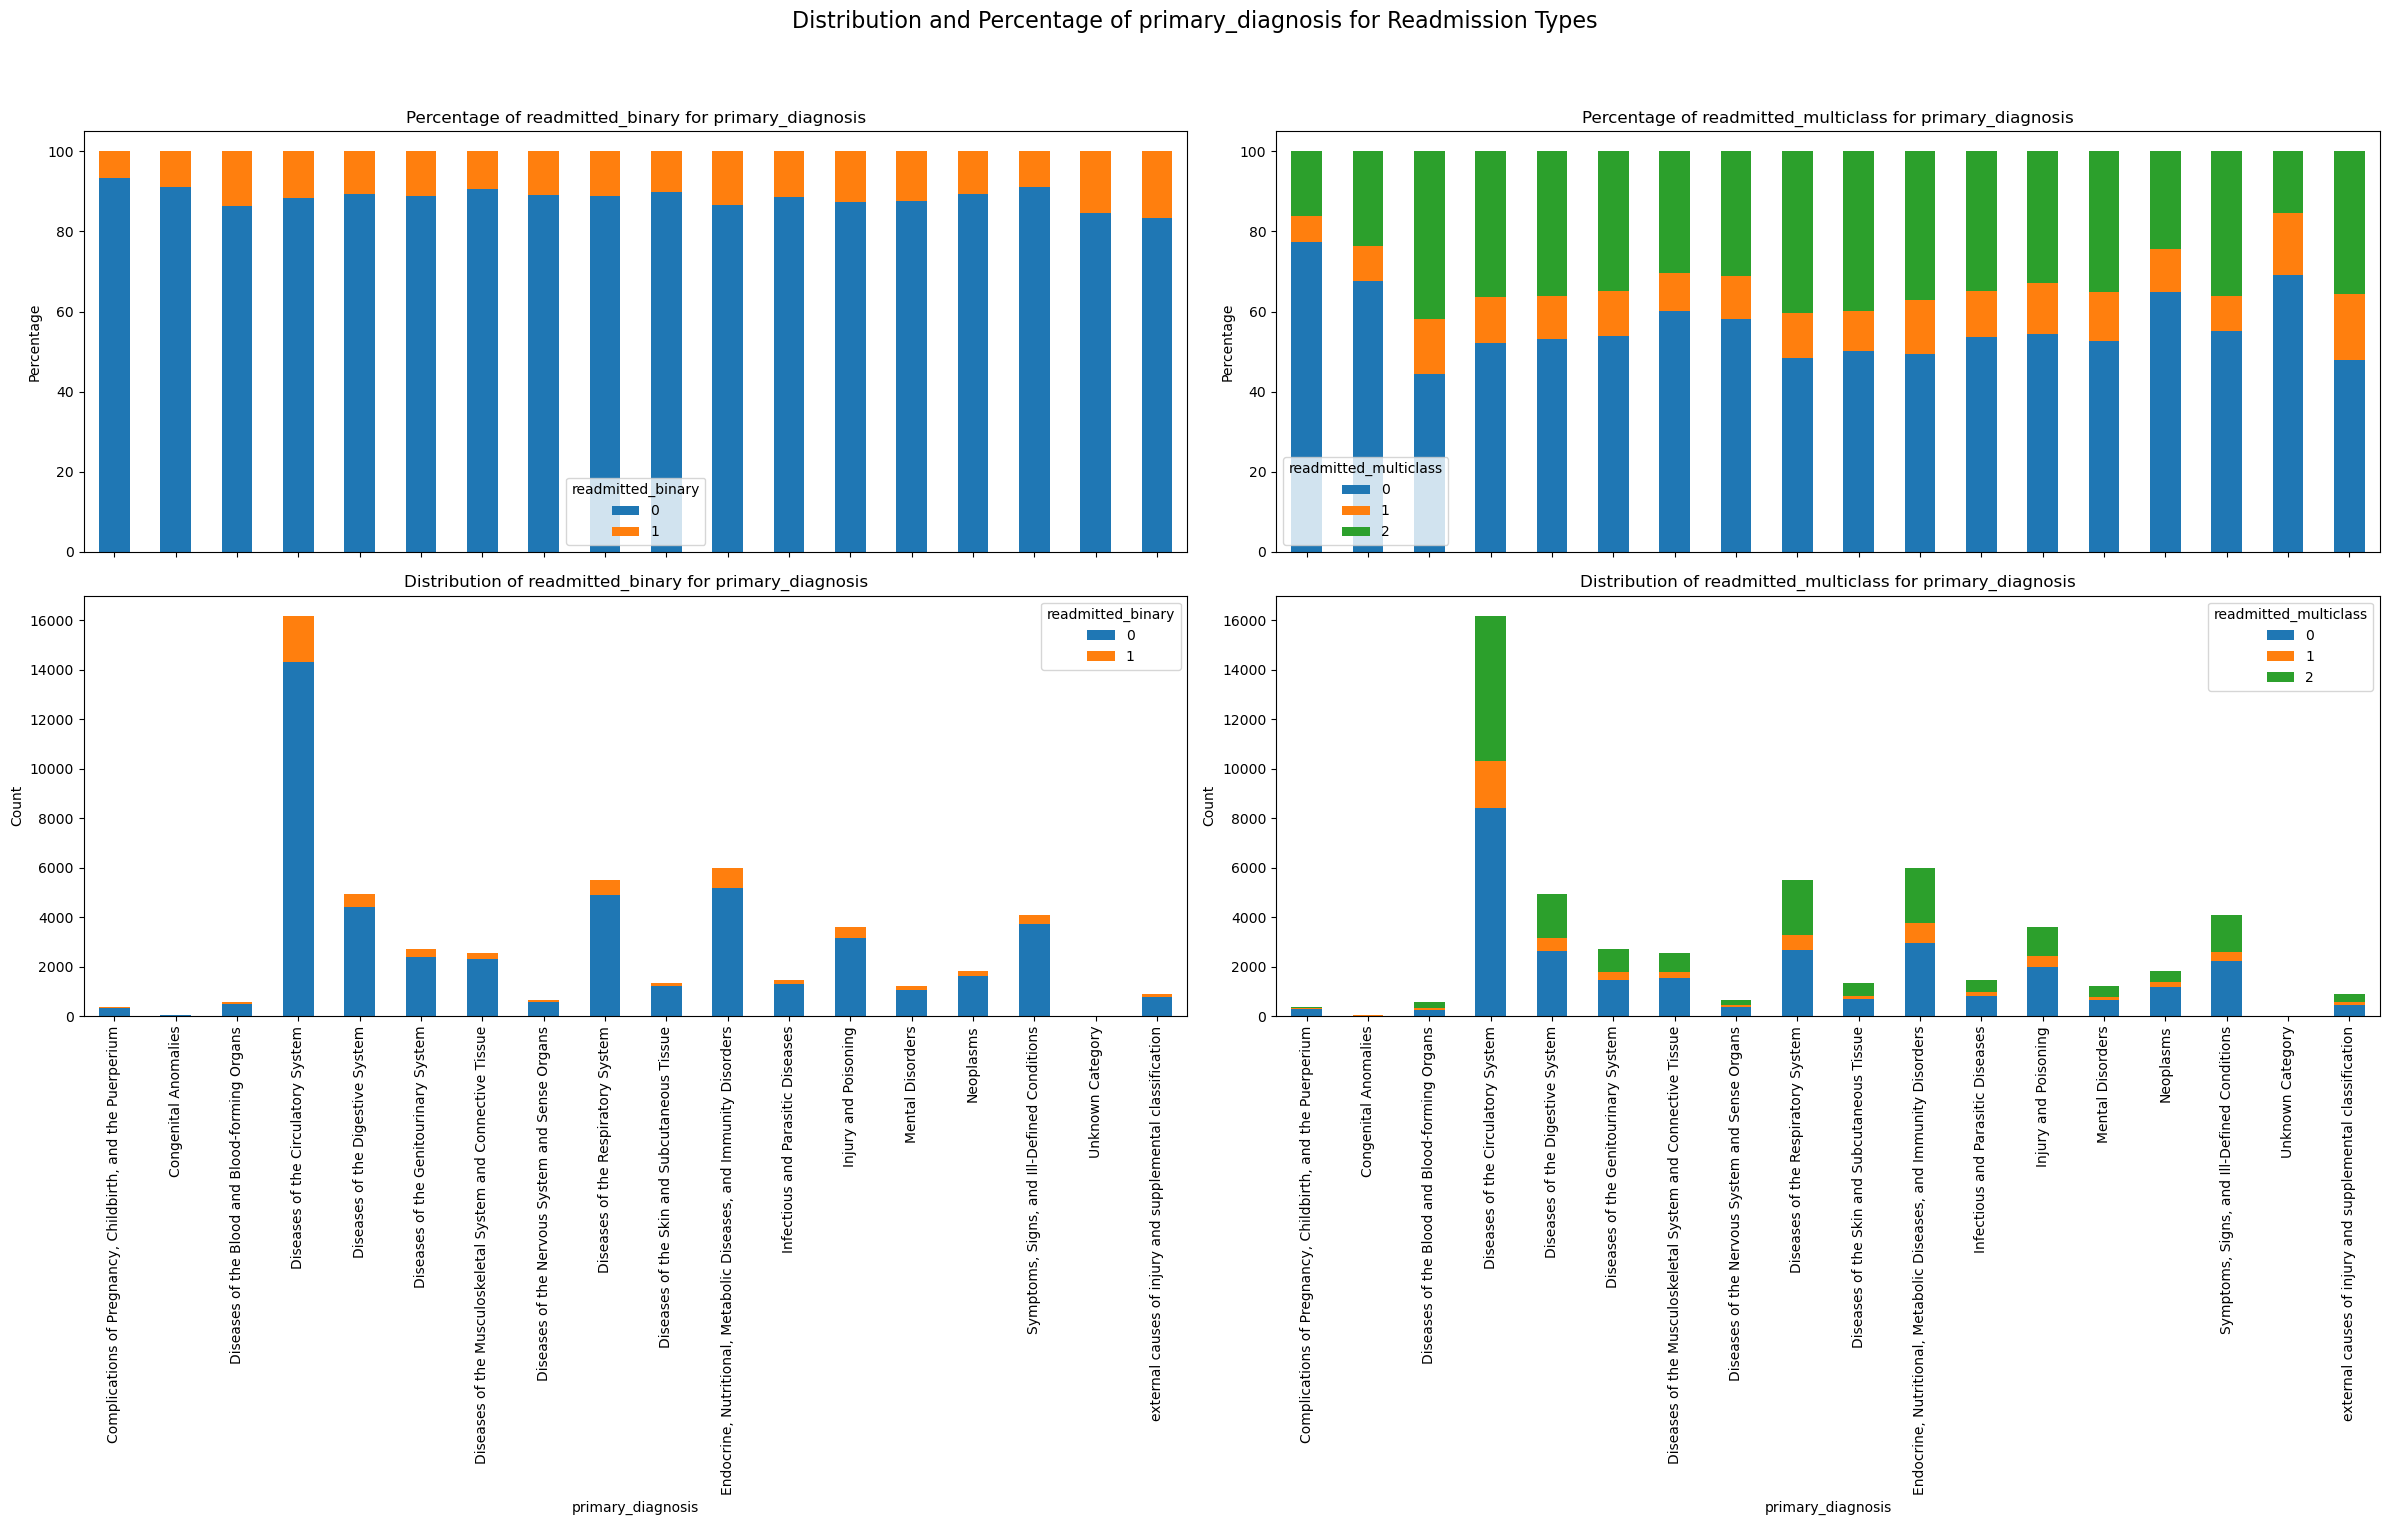

In [187]:
plot_categorical_distribution(data_train, 'primary_diagnosis')

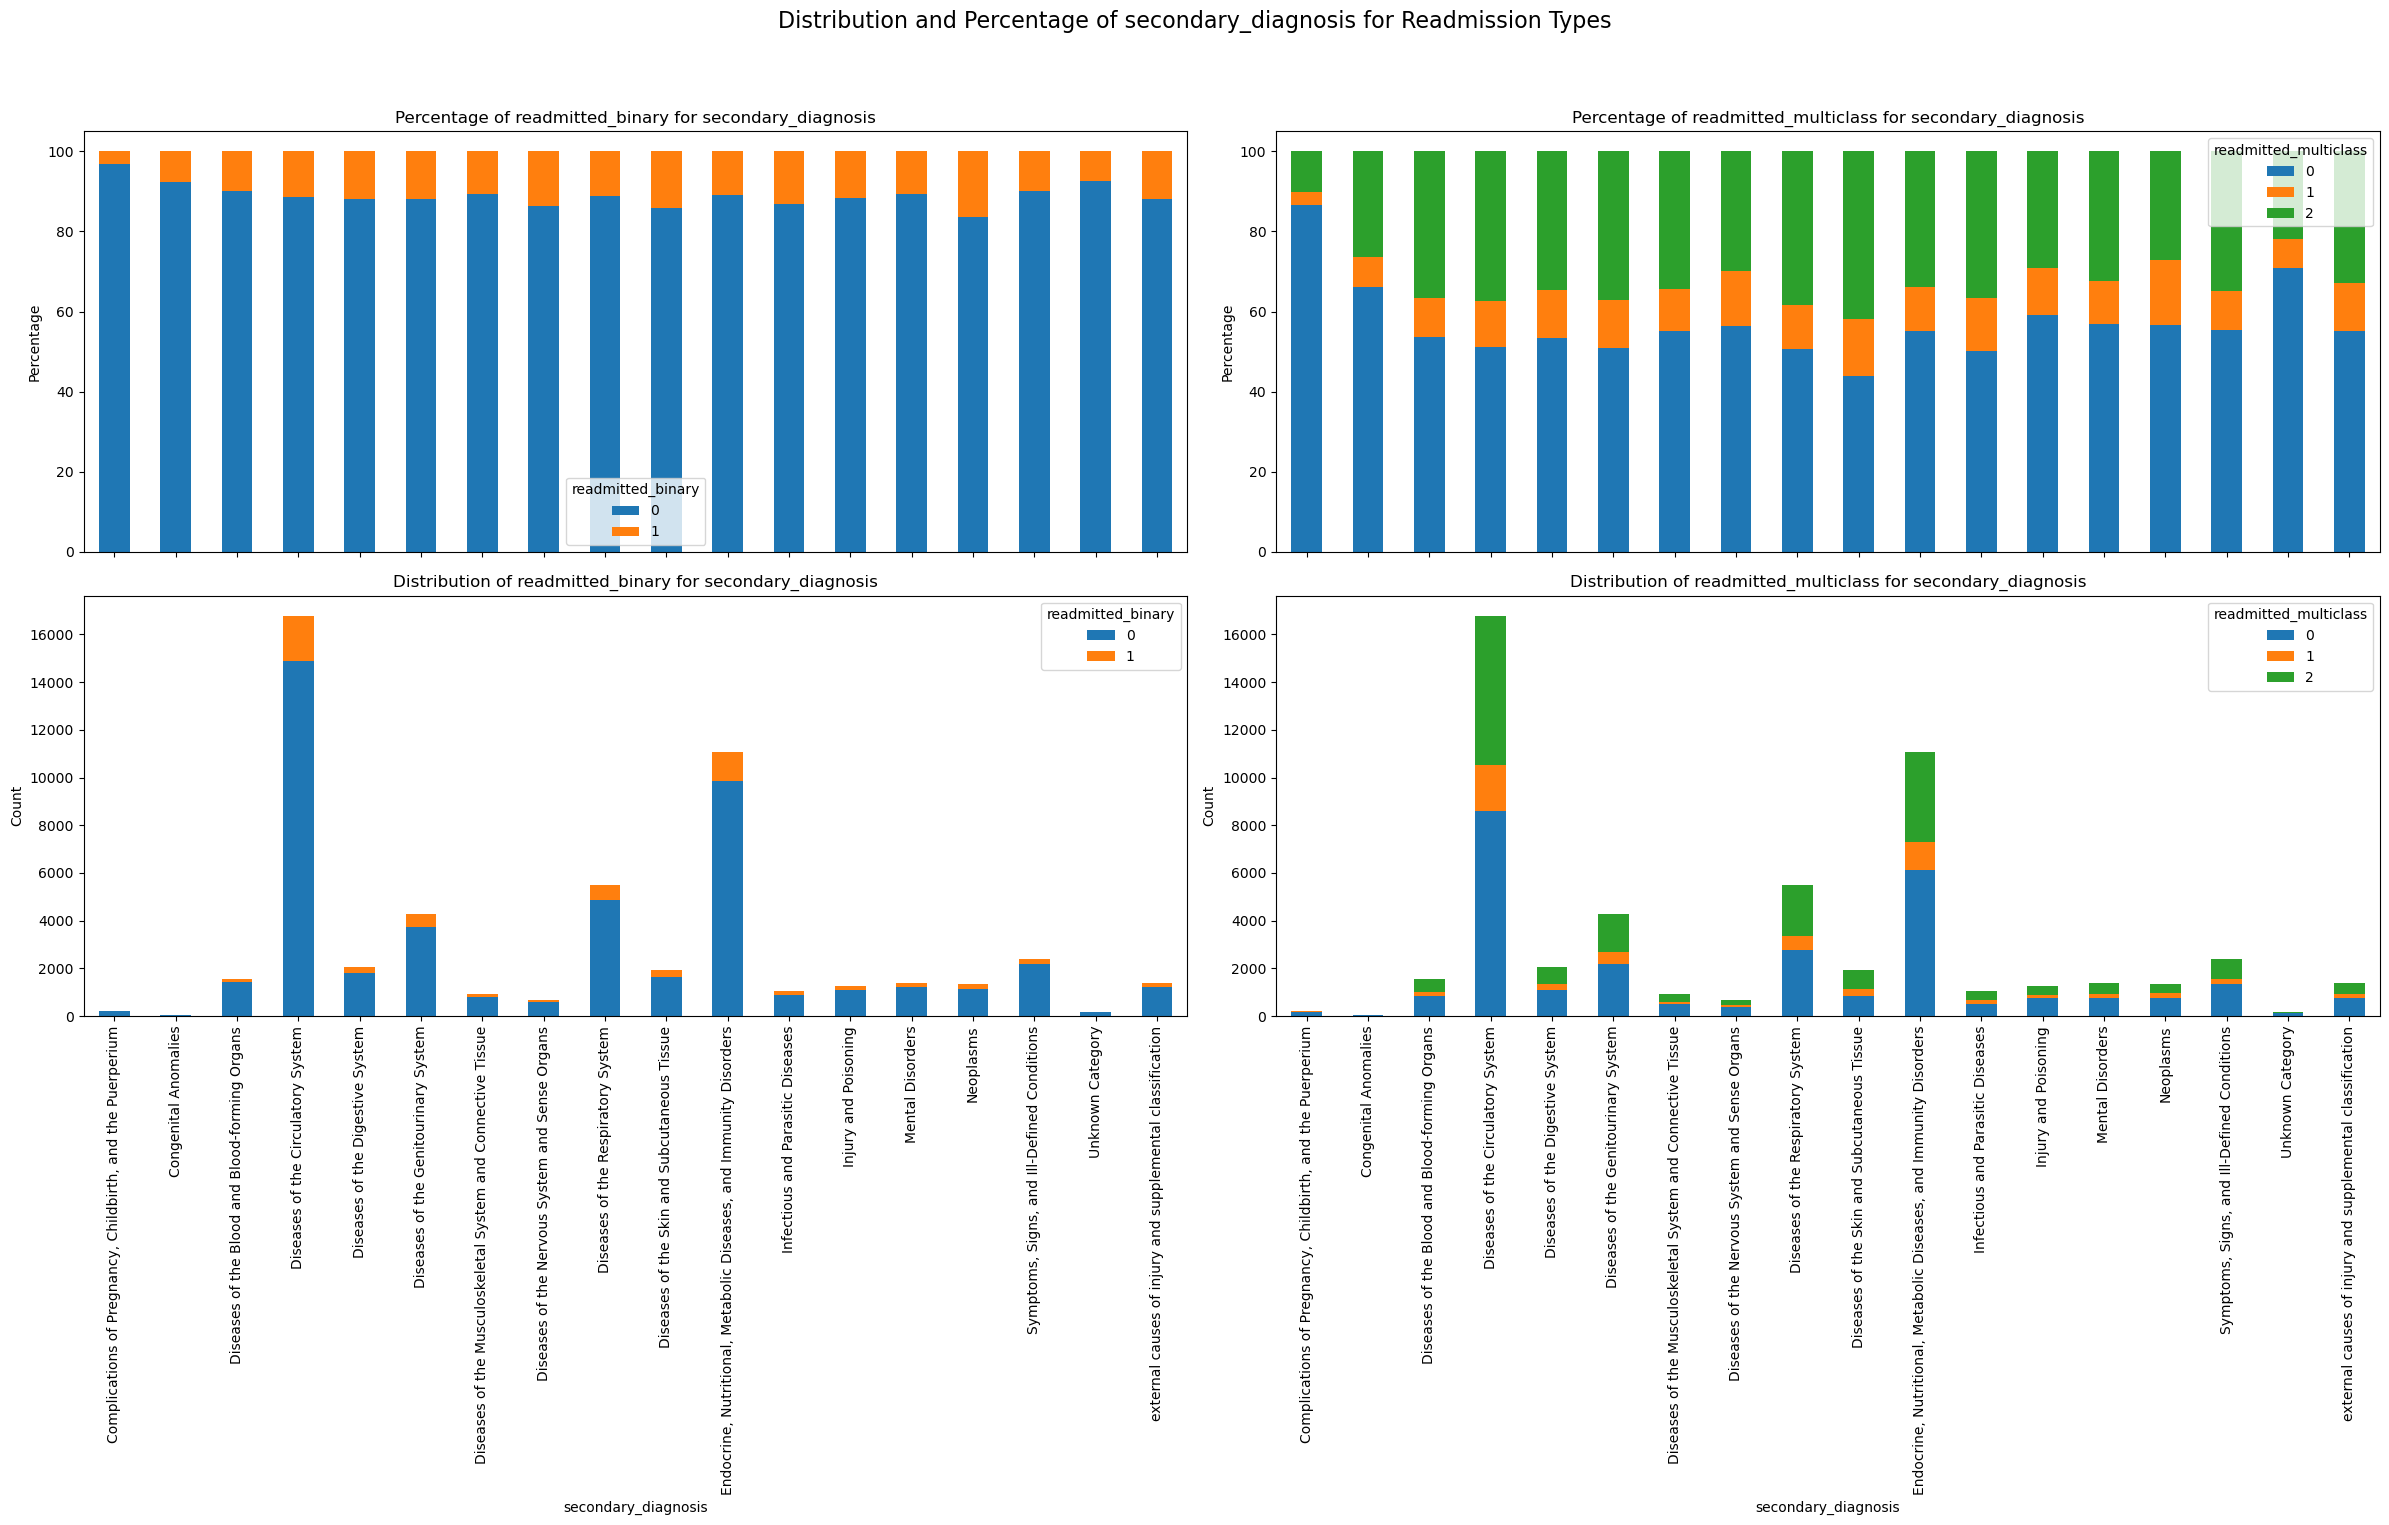

In [188]:
plot_categorical_distribution(data_train, 'secondary_diagnosis')

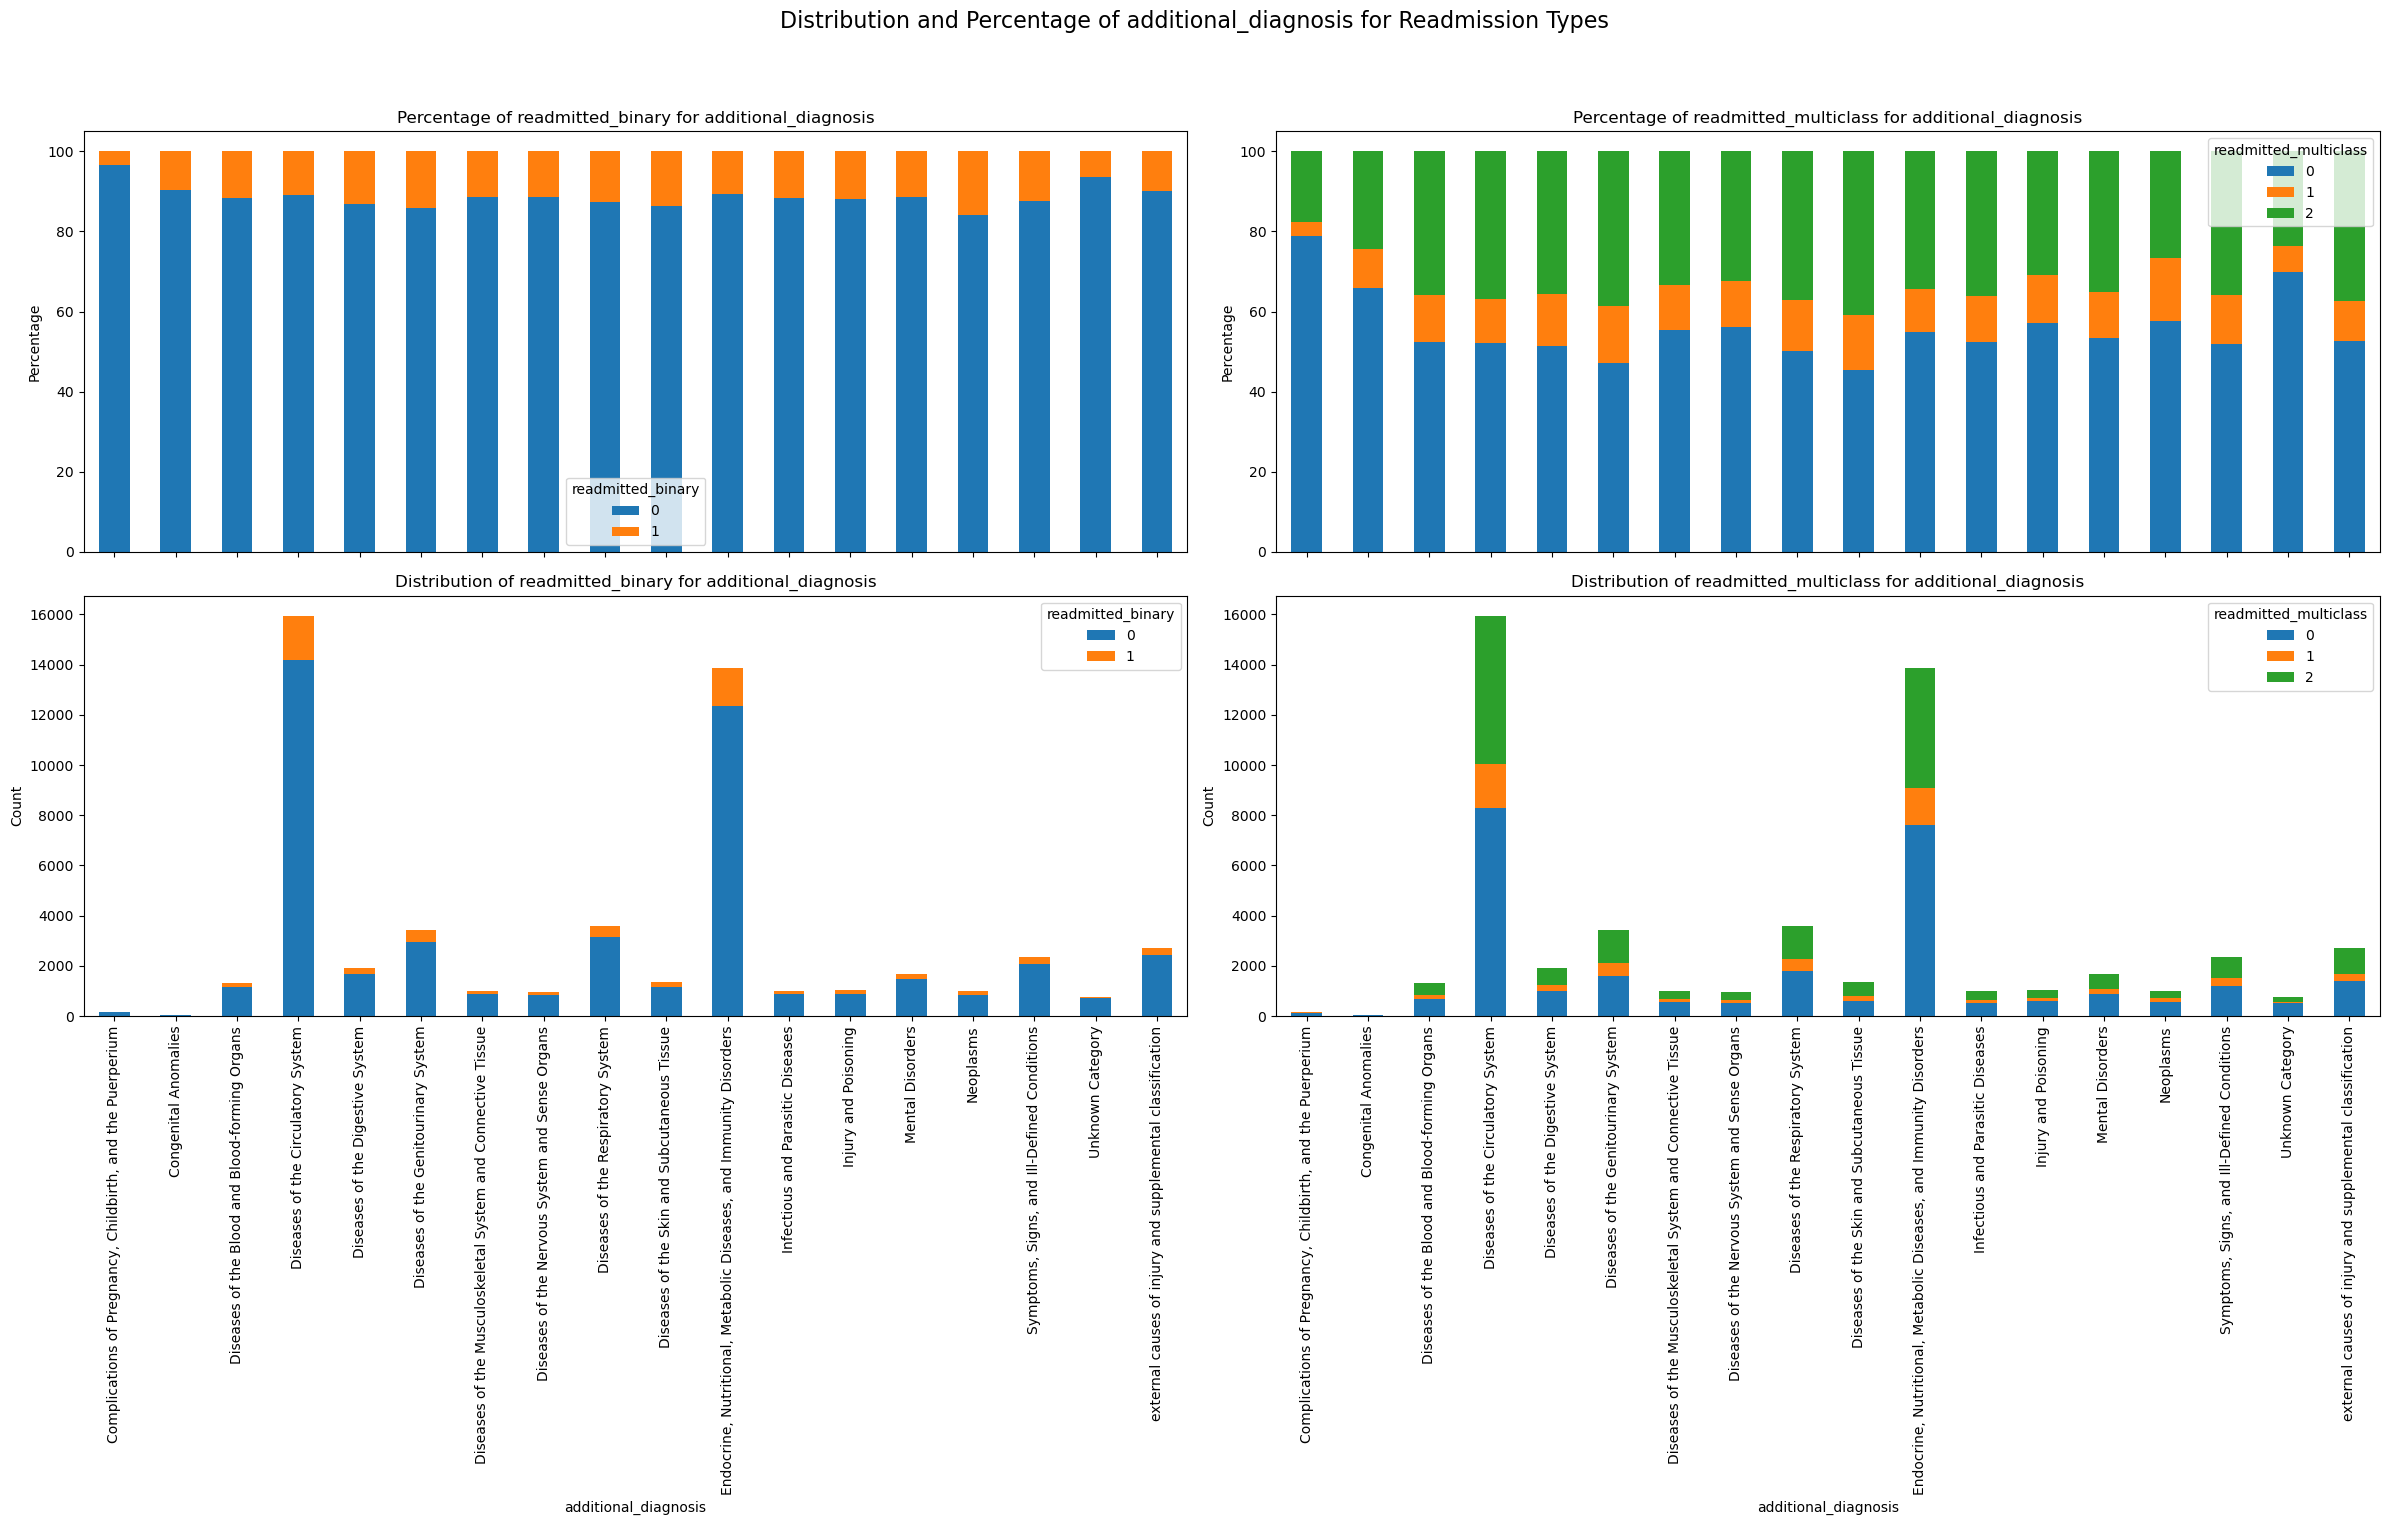

In [189]:
plot_categorical_distribution(data_train, 'additional_diagnosis')

In [190]:
# secondary_diagnosis and additional_diagnosis have very similar distributions, so we will drop additional_diagnosis for dimensionality reduction
data_train.drop(['additional_diagnosis'], axis=1, inplace=True)
data_val.drop(['additional_diagnosis'], axis=1, inplace=True)
data_test.drop(['additional_diagnosis'], axis=1, inplace=True)

#### number_diagnoses

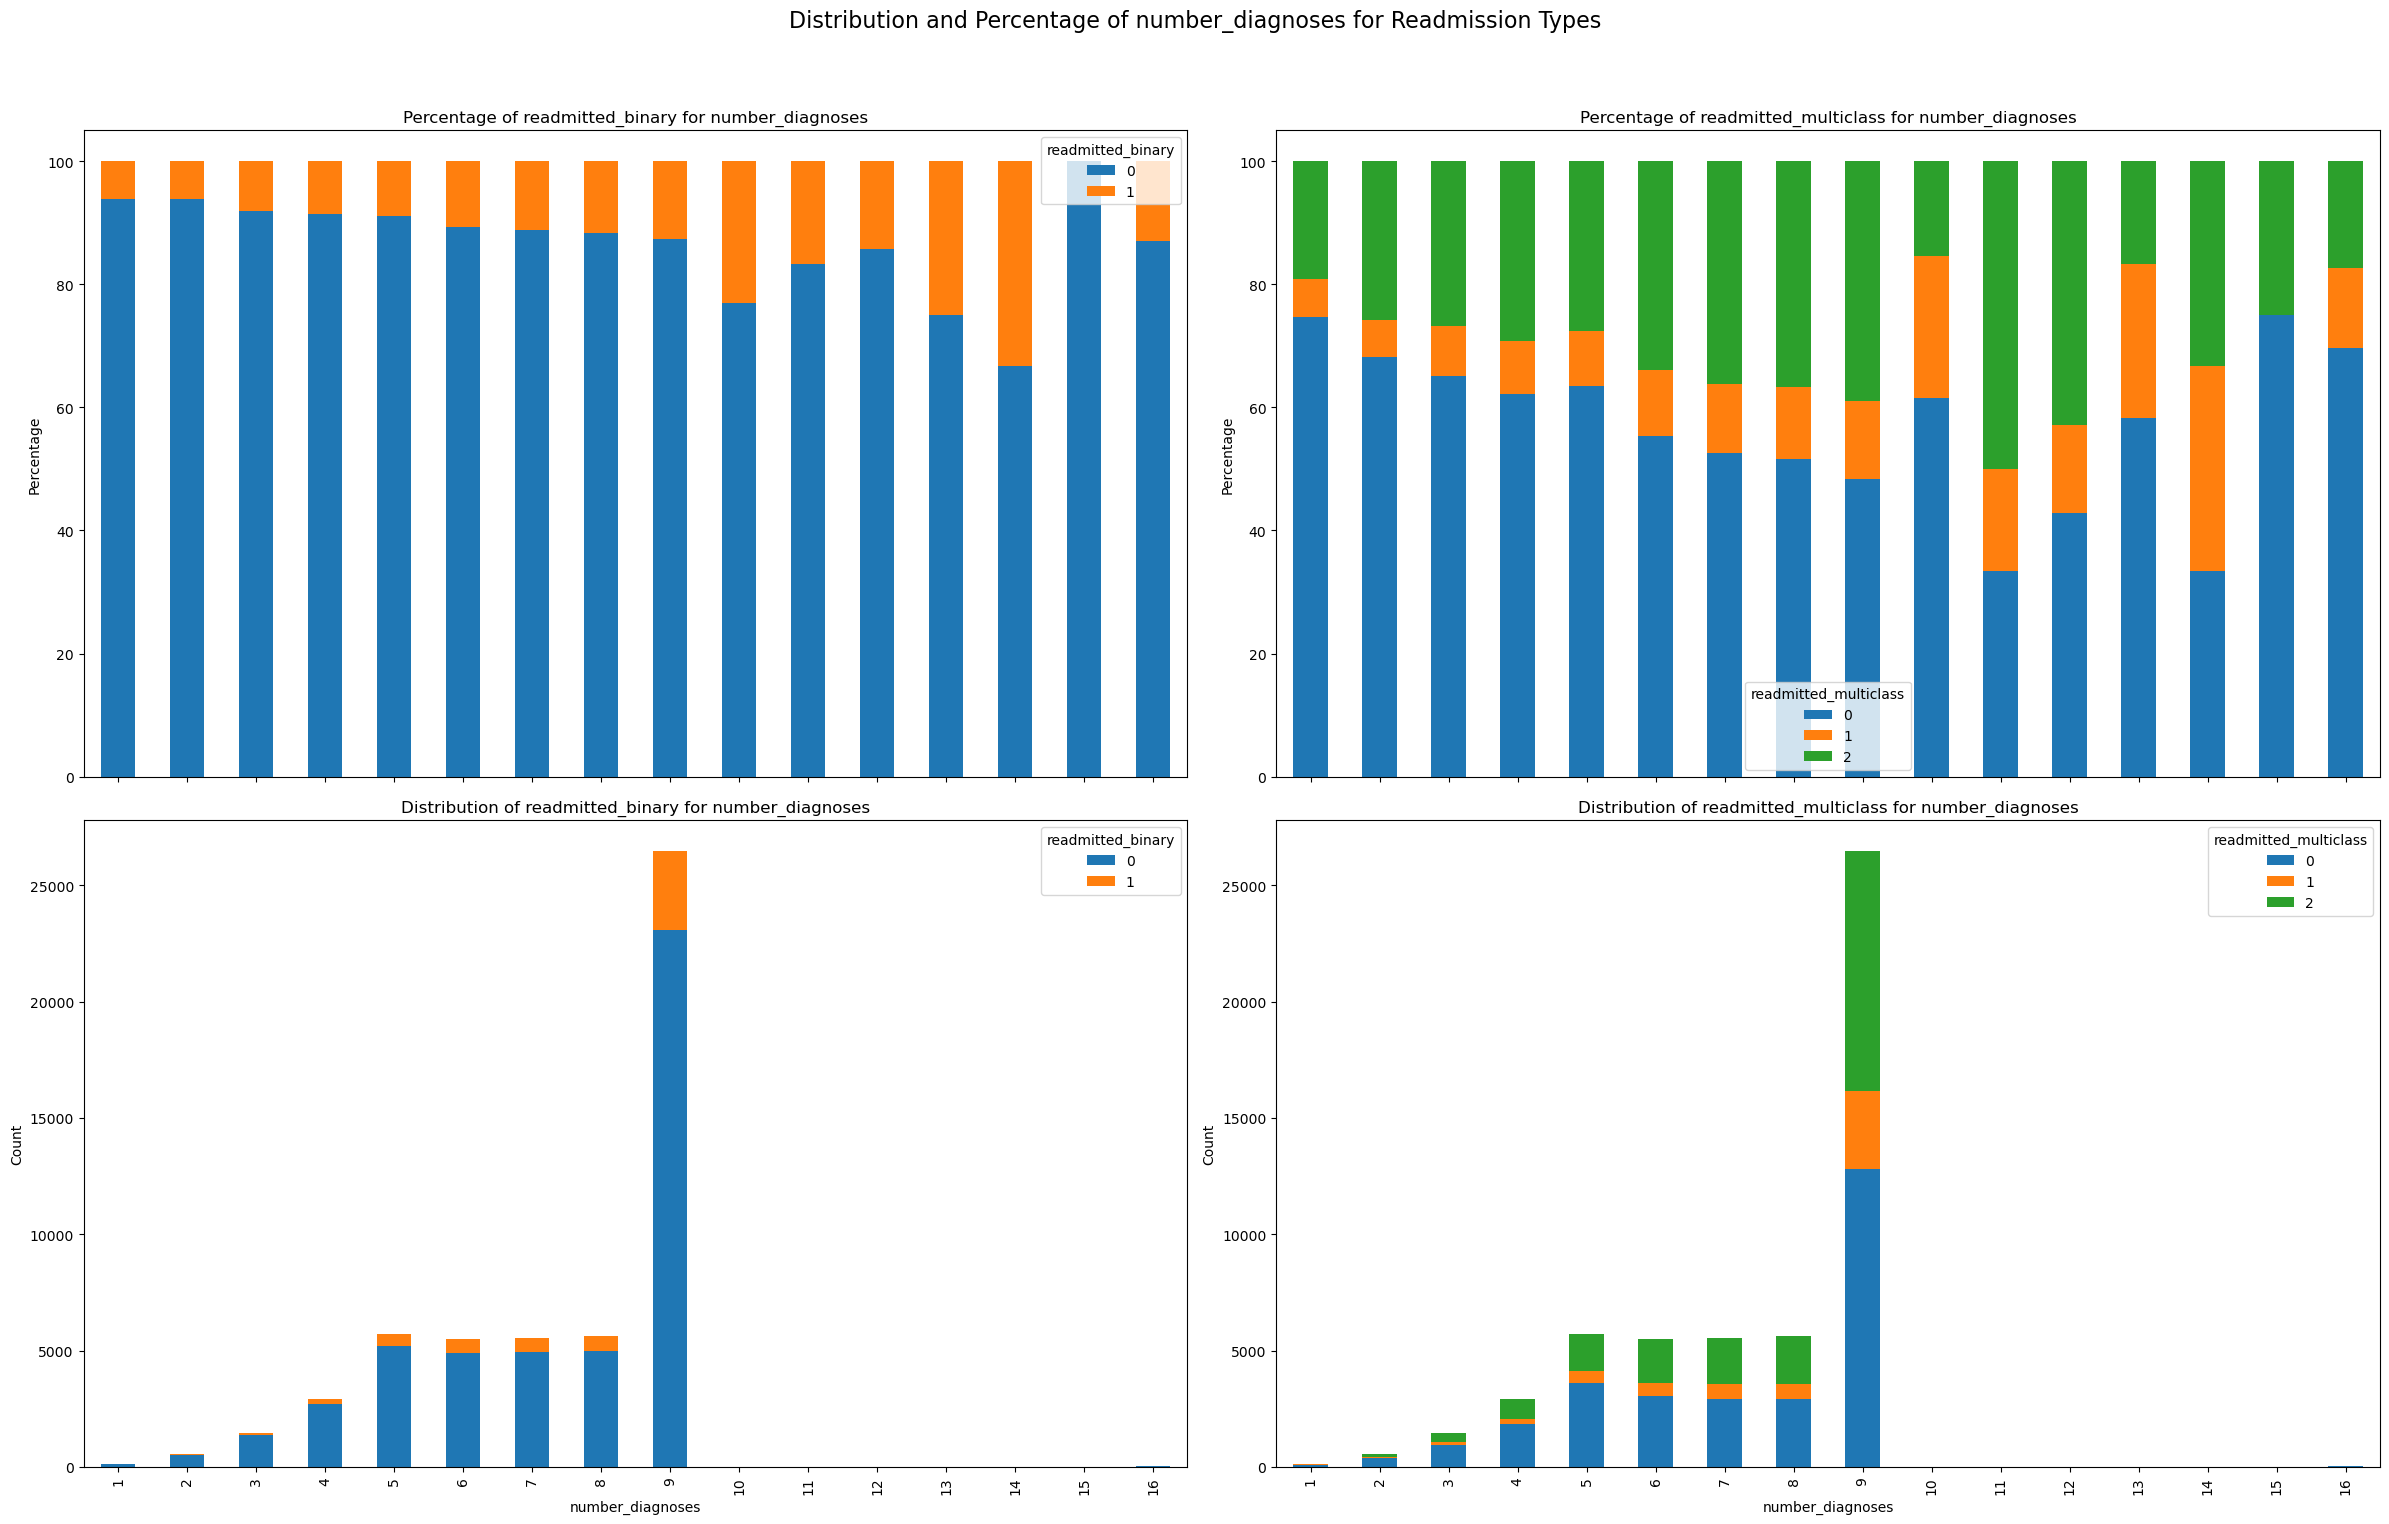

In [191]:
plot_categorical_distribution(data_train, 'number_diagnoses')

In [192]:
# clip outliers as before
# cap_diagnoses = cap_outliers(data_train, 'number_diagnoses', 0.99)
# data_val['number_diagnoses'] = data_val['number_diagnoses'].clip(upper=cap_diagnoses)
# data_test['number_diagnoses'] = data_test['number_diagnoses'].clip(upper=cap_diagnoses)

#### glucose_test_result

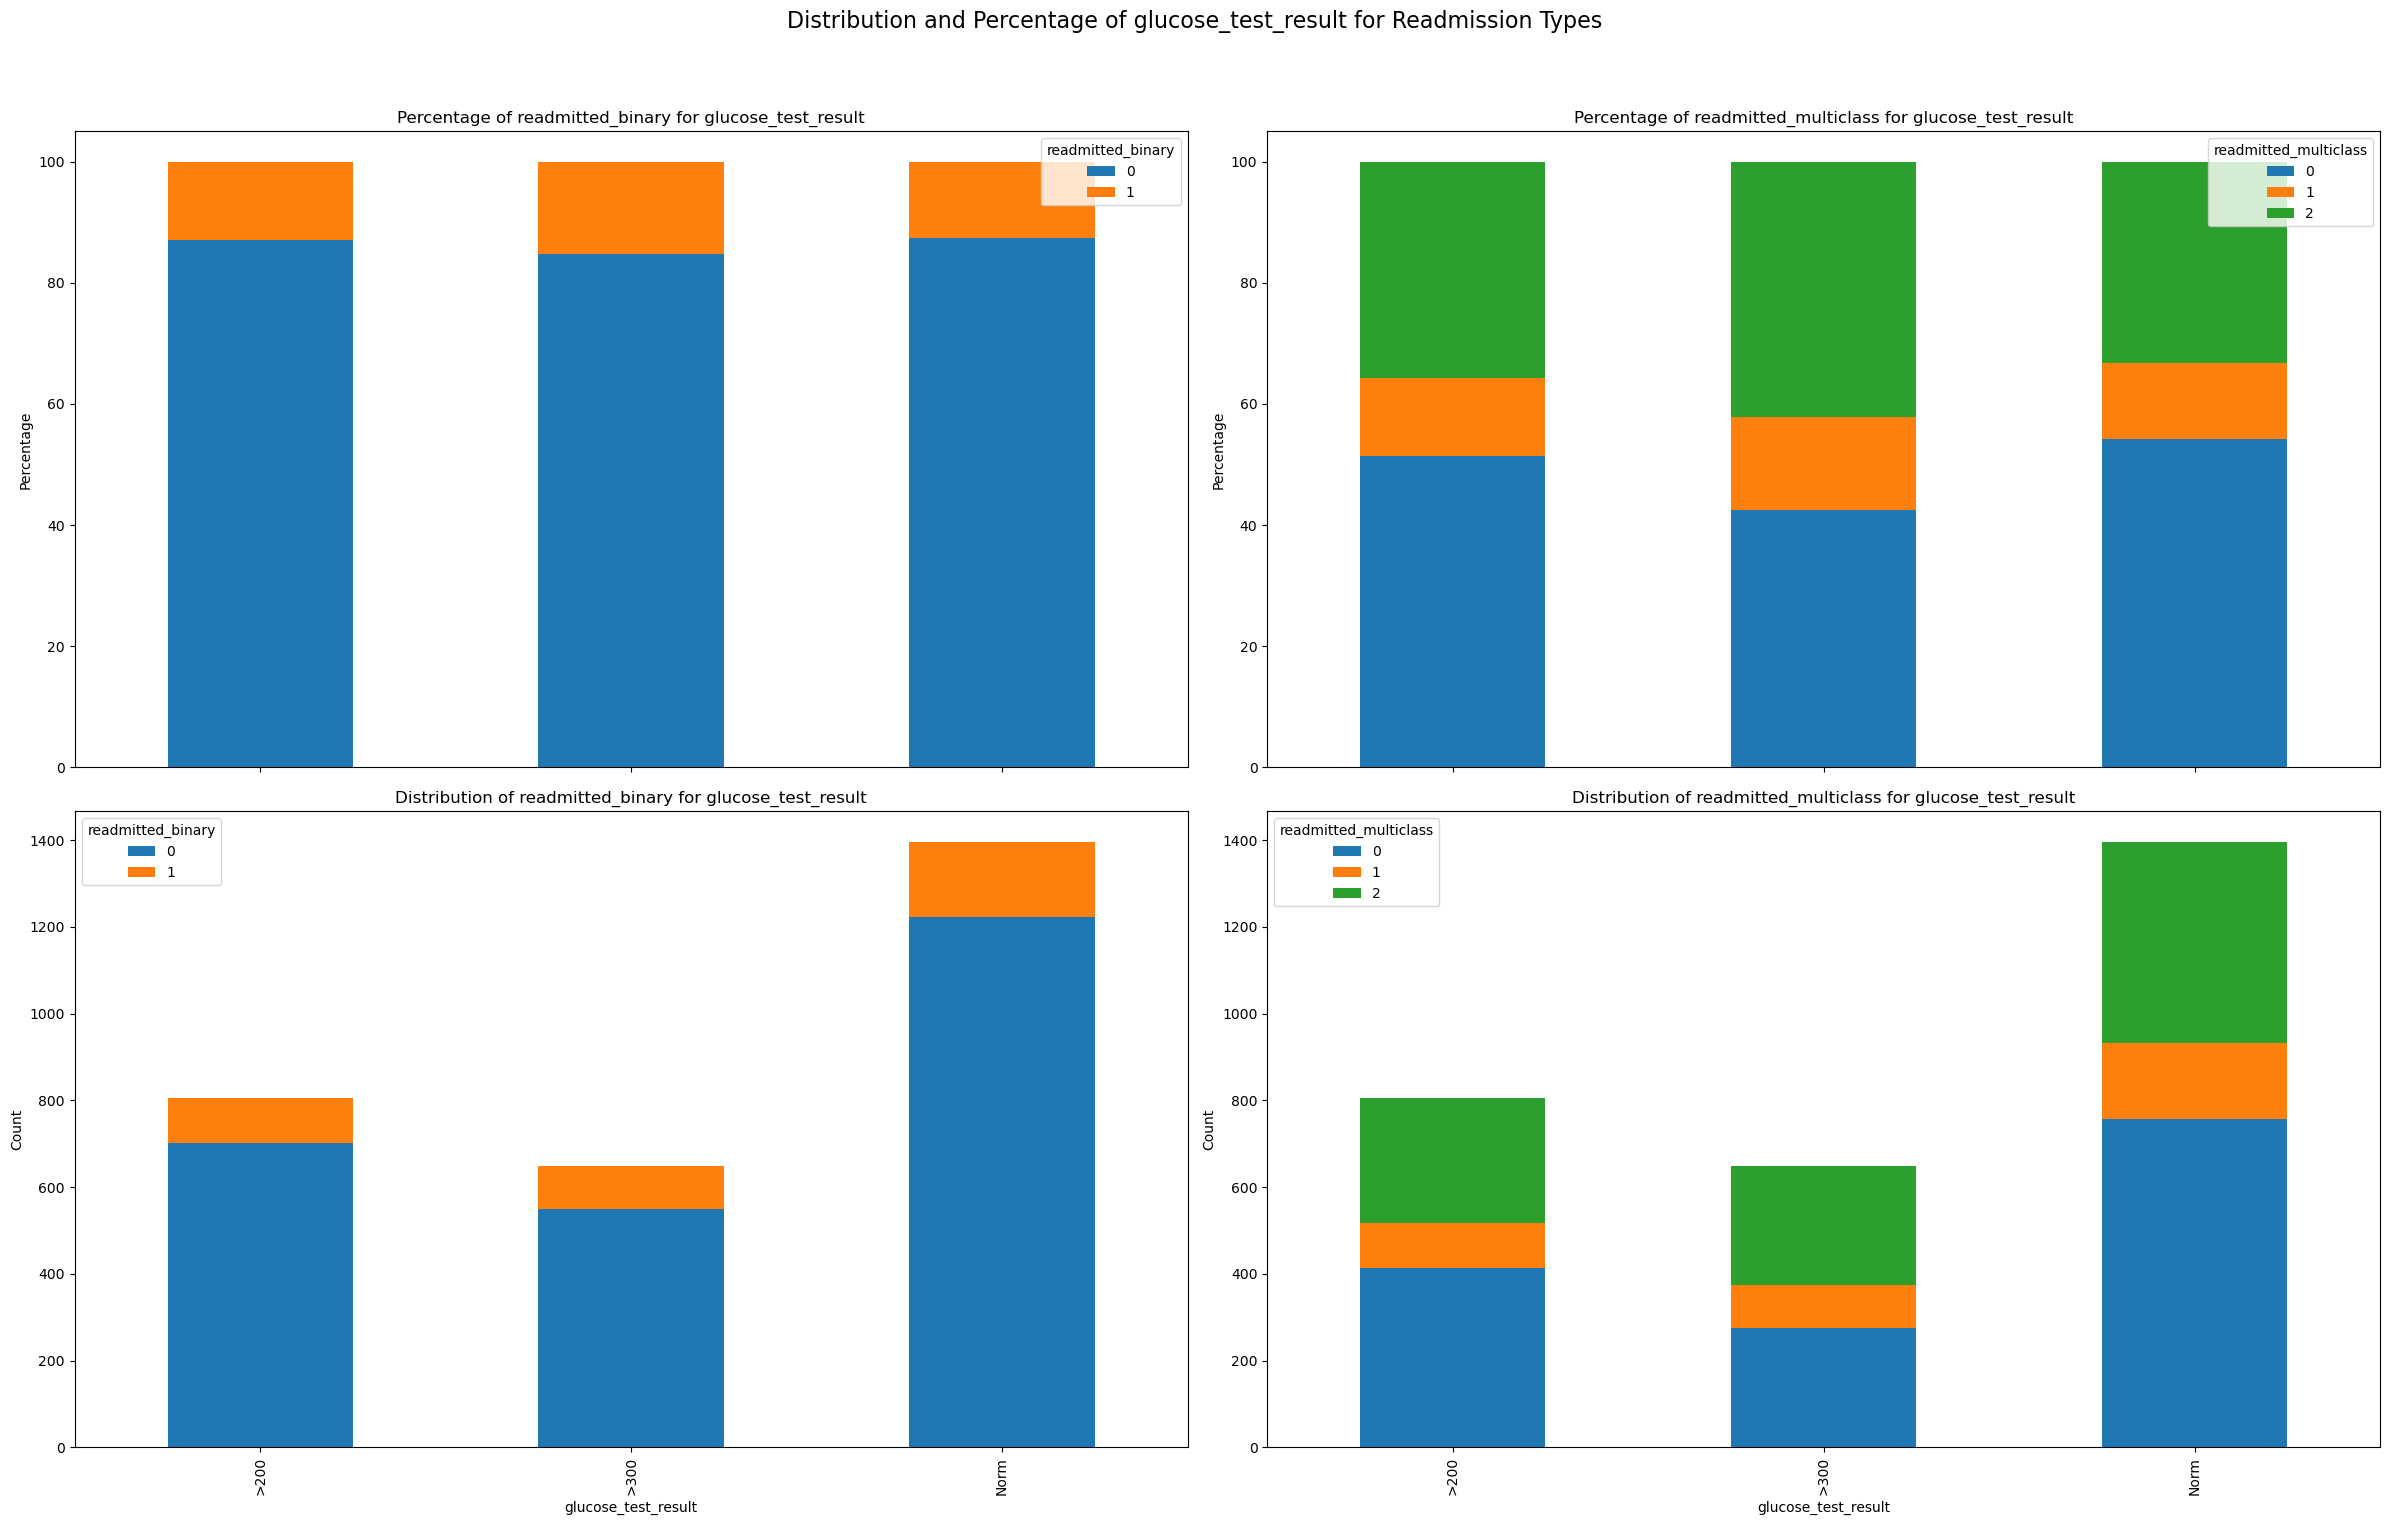

In [193]:
plot_categorical_distribution(data_train, 'glucose_test_result')

In [194]:
# fill missing values with 'Not Performed'
data_train['glucose_test_result'] = data_train['glucose_test_result'].fillna('Not Performed')
data_val['glucose_test_result'] = data_val['glucose_test_result'].fillna('Not Performed')
data_test['glucose_test_result'] = data_test['glucose_test_result'].fillna('Not Performed')

#### a1c_test_result

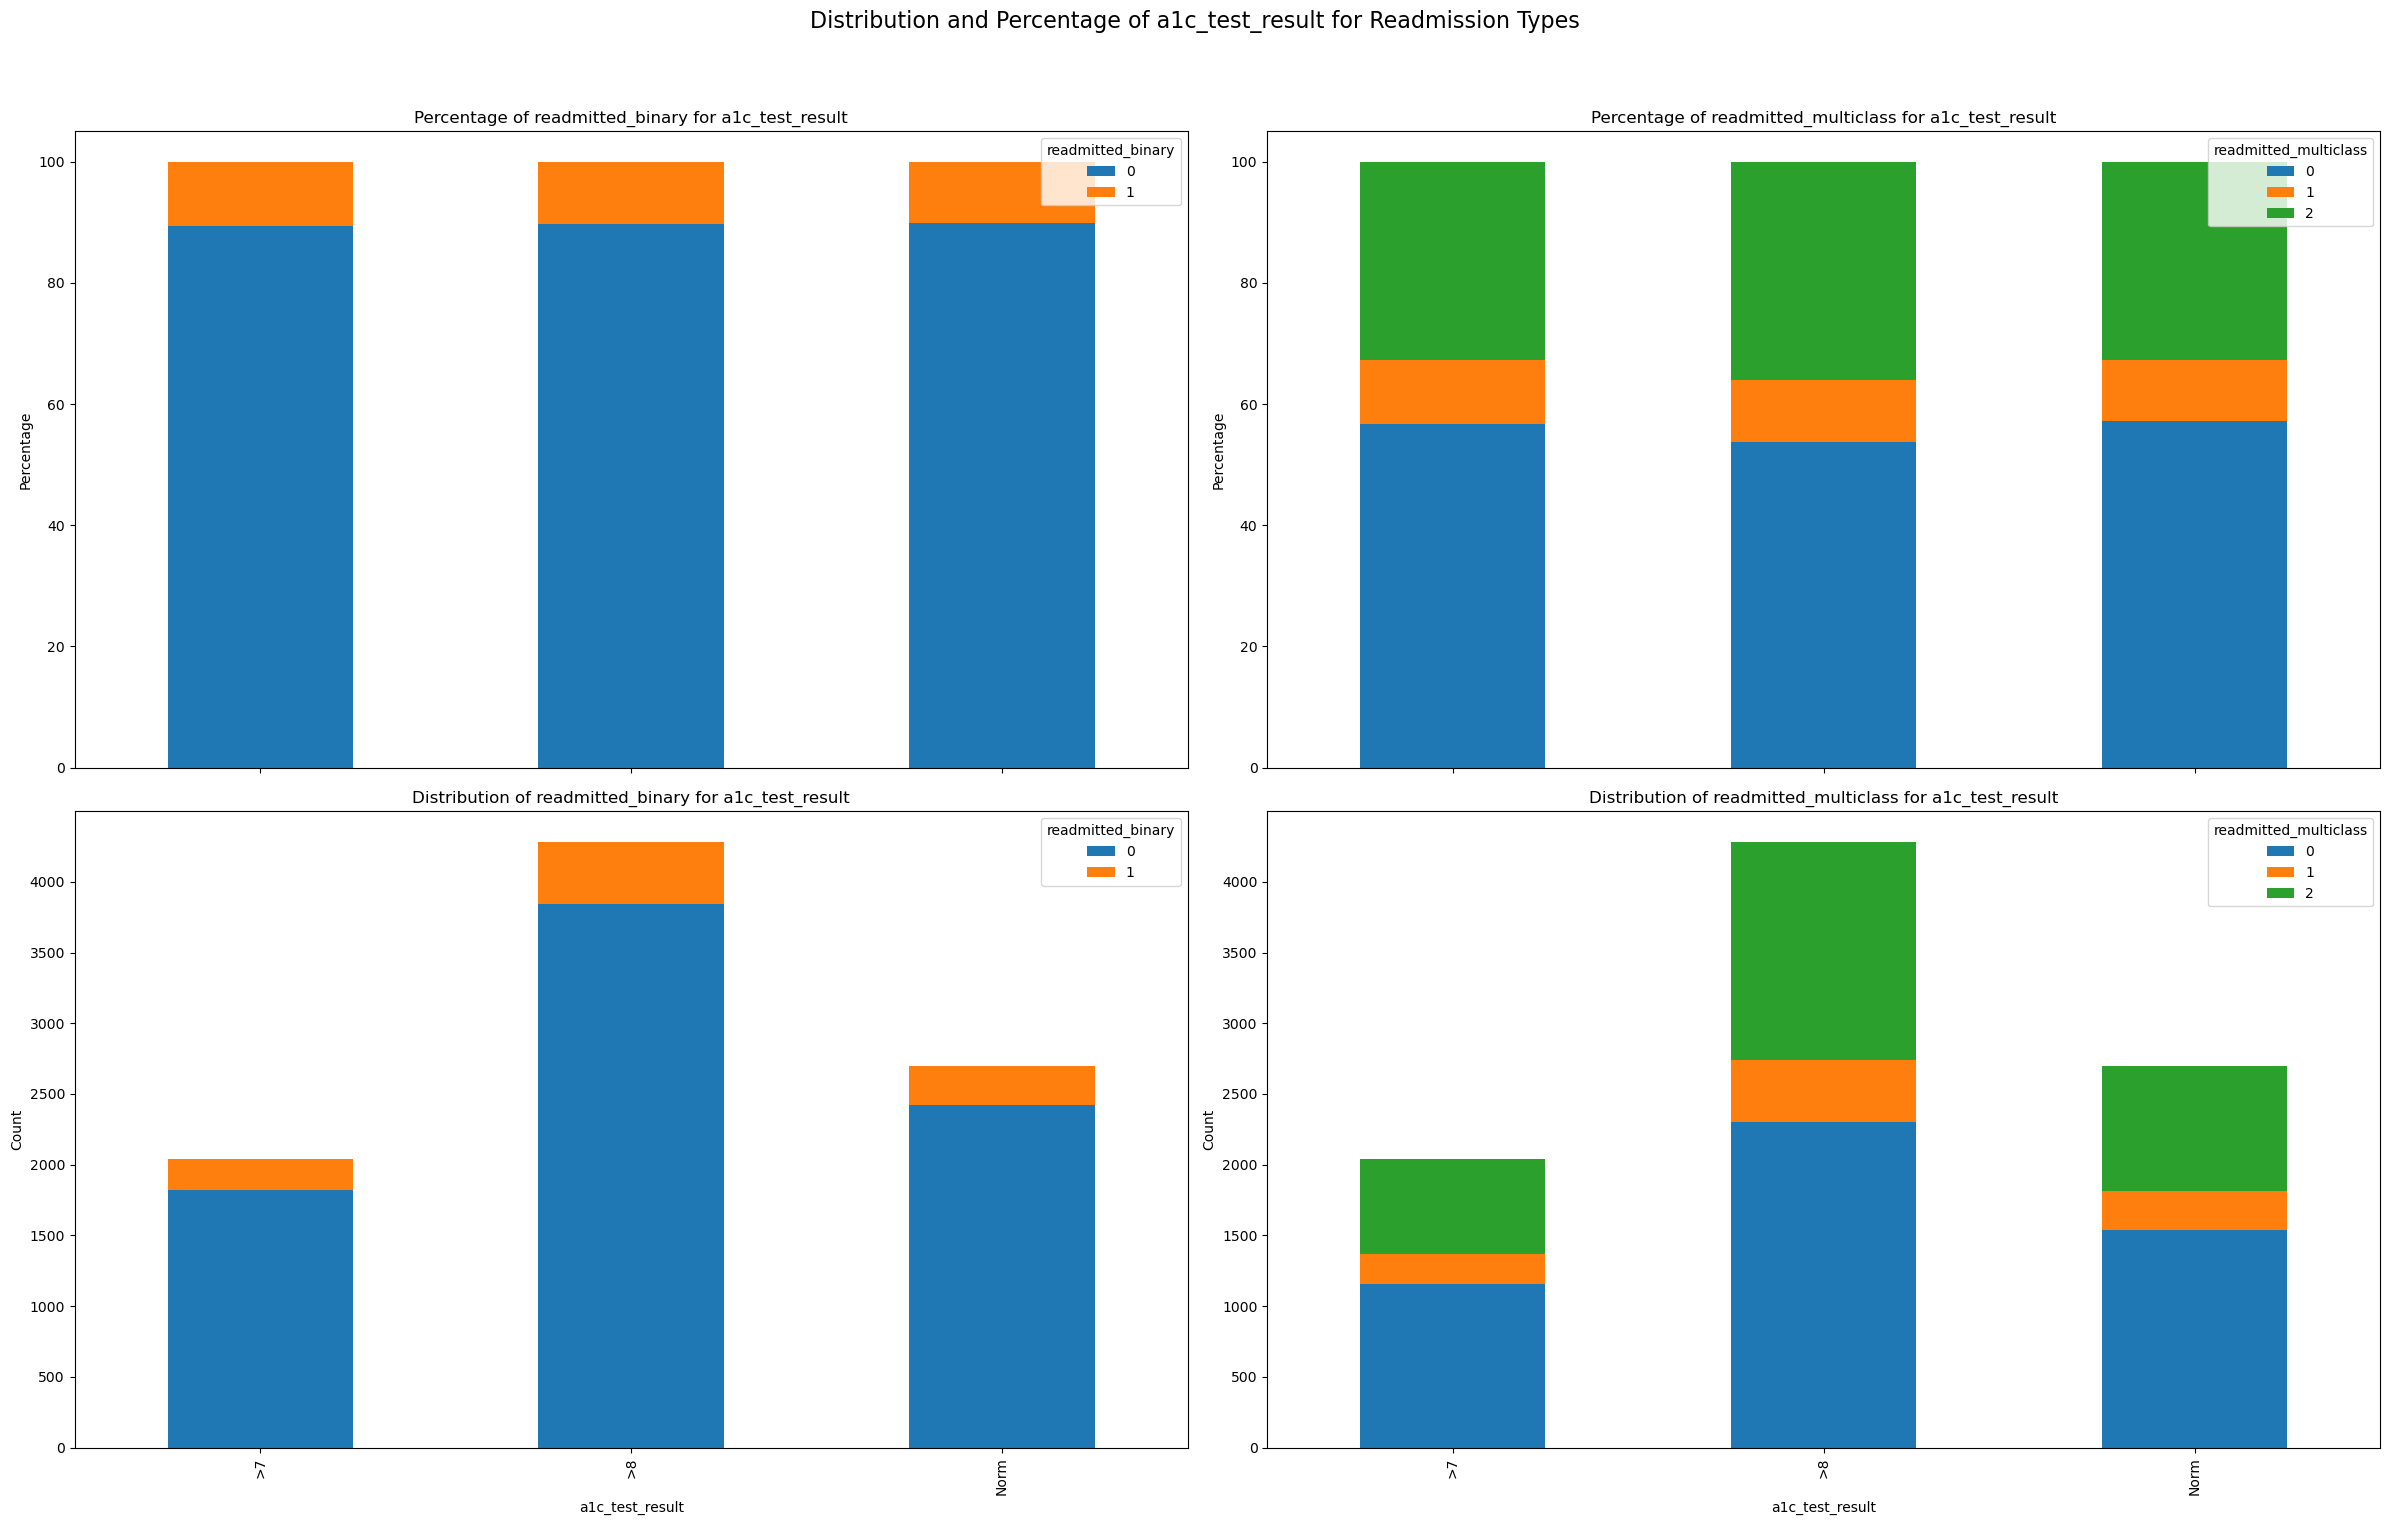

In [195]:
plot_categorical_distribution(data_train, 'a1c_test_result')

In [196]:
# fill missing values with 'Not Performed'
data_train['a1c_test_result'] = data_train['a1c_test_result'].fillna('Not Performed')
data_val['a1c_test_result'] = data_val['a1c_test_result'].fillna('Not Performed')
data_test['a1c_test_result'] = data_test['a1c_test_result'].fillna('Not Performed')

#### change_in_meds_during_hospitalization

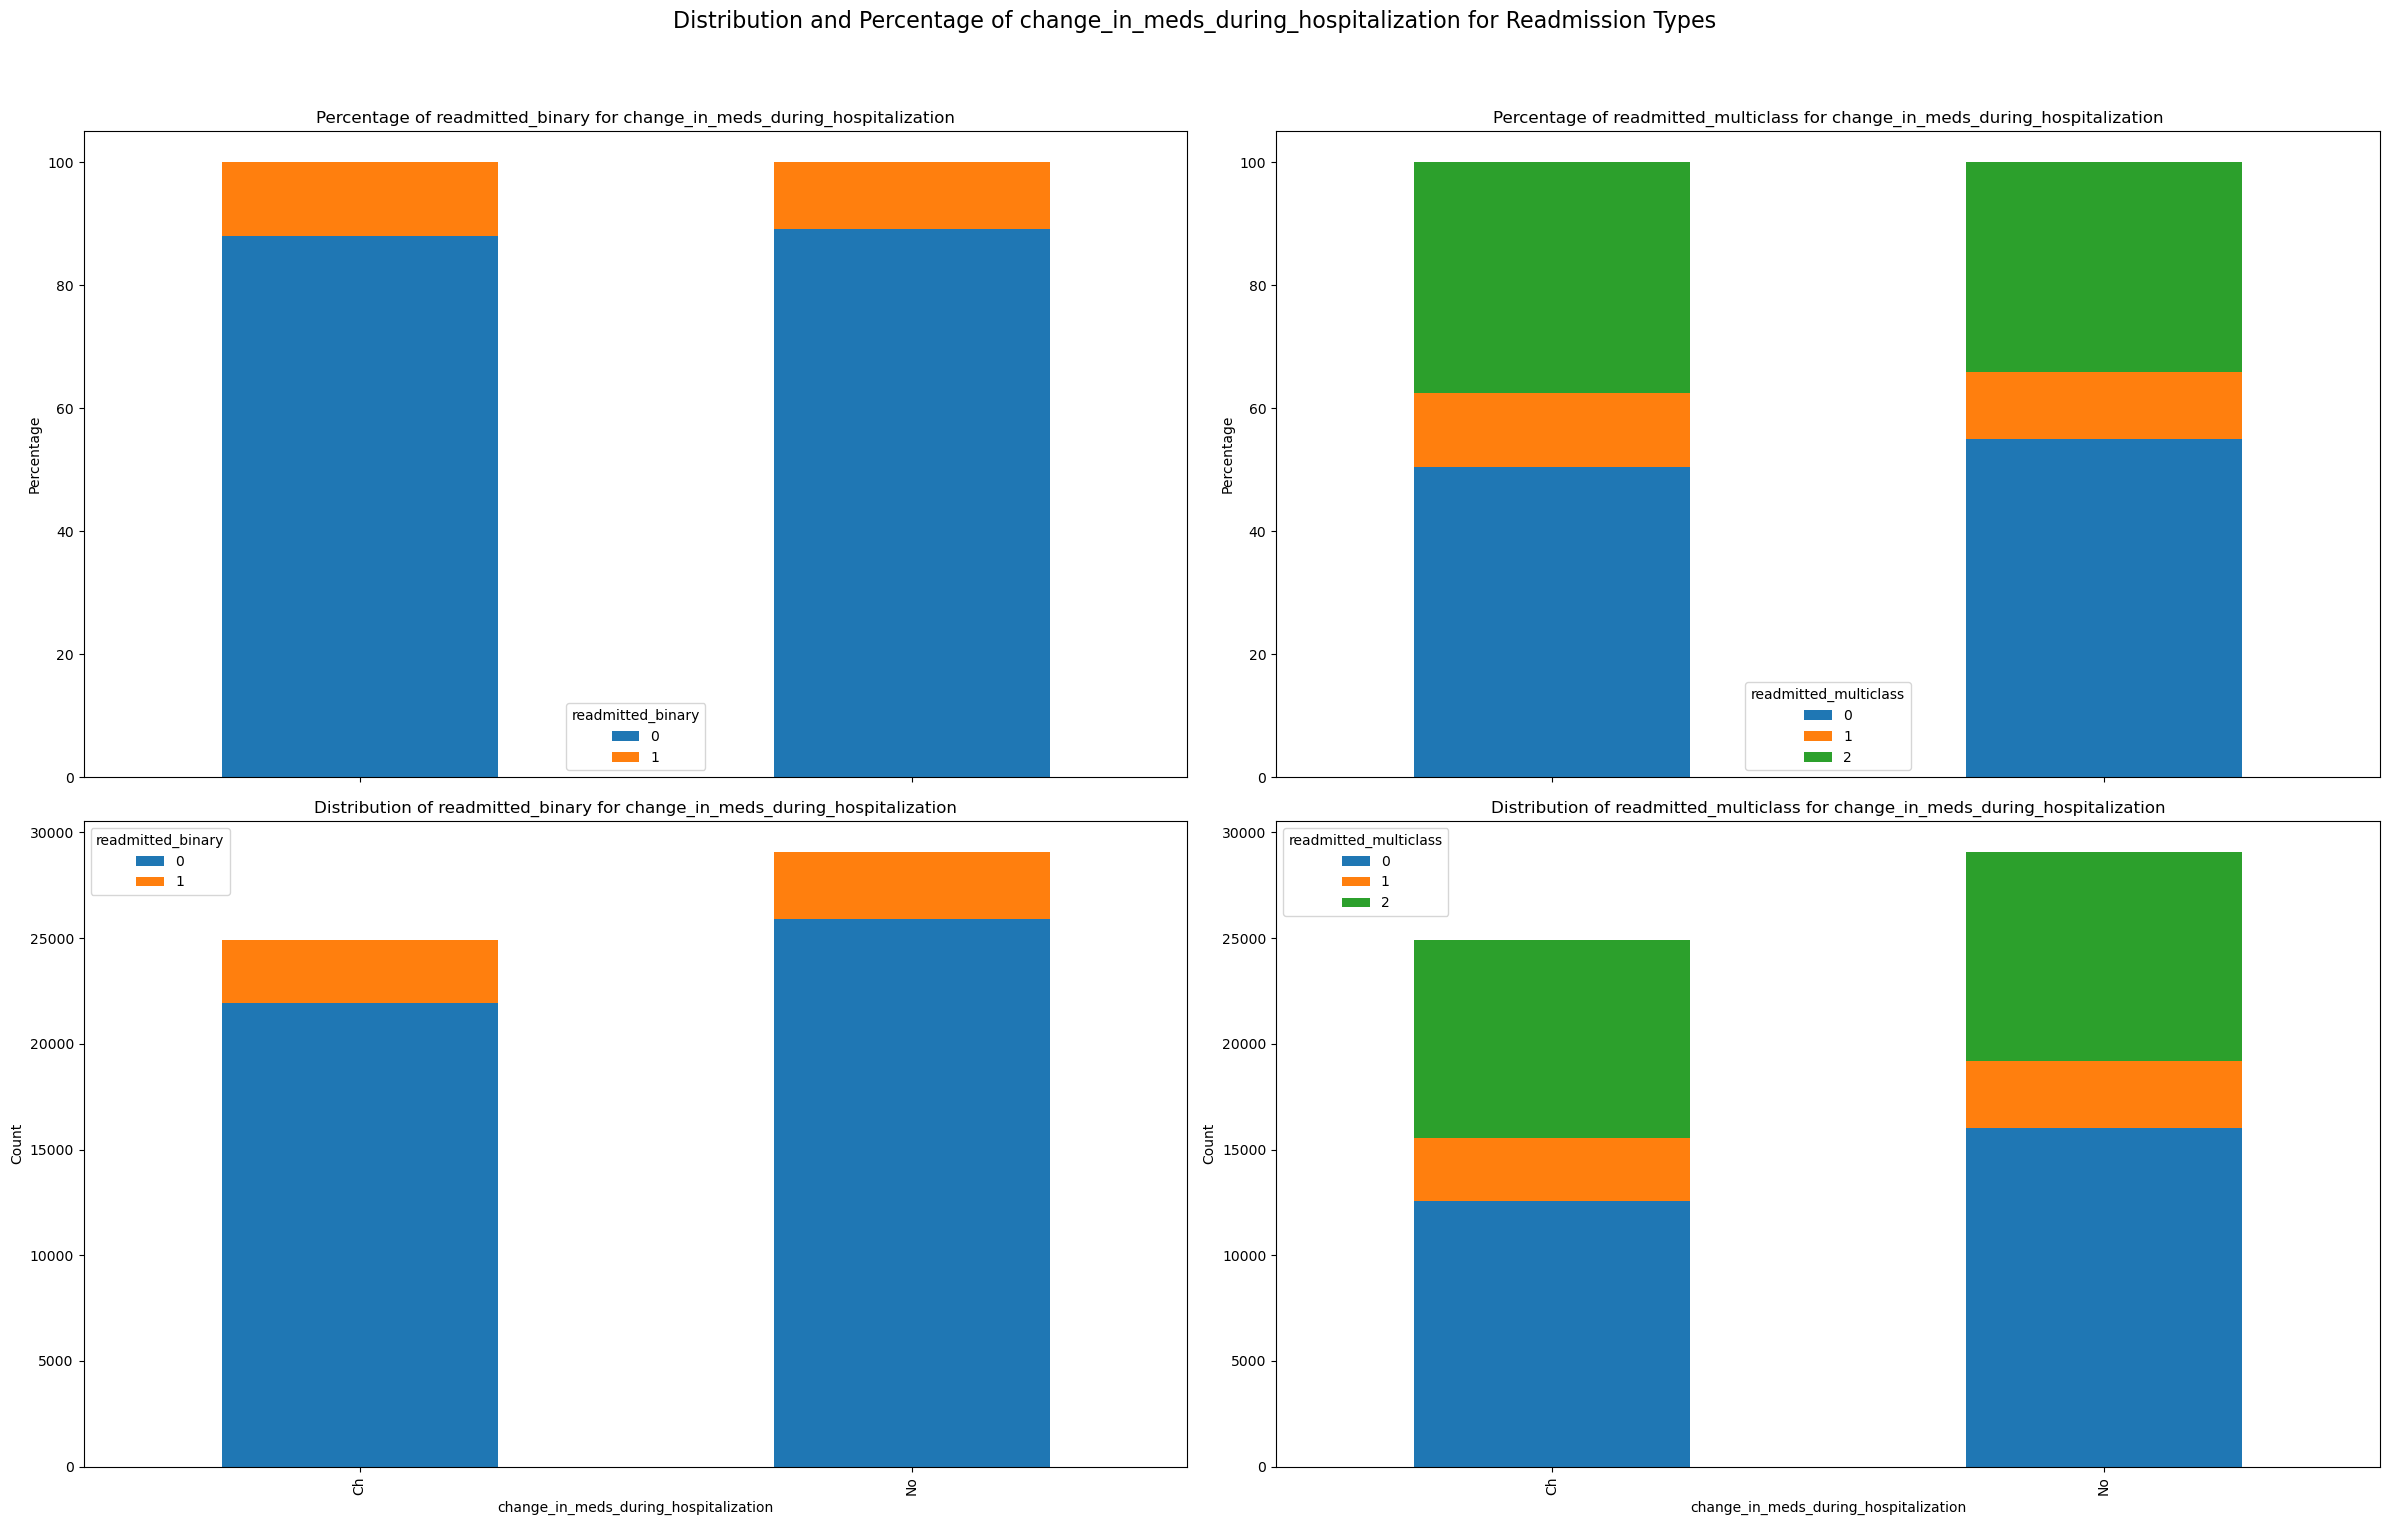

In [197]:
plot_categorical_distribution(data_train, 'change_in_meds_during_hospitalization')

In [198]:
# replace 'Ch' and 'No' with 1 and 0
data_train['change_in_meds_during_hospitalization'] = data_train['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0})
data_val['change_in_meds_during_hospitalization'] = data_val['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0})
data_test['change_in_meds_during_hospitalization'] = data_test['change_in_meds_during_hospitalization'].replace({'Ch': 1, 'No': 0})

#### prescribed_diabetes_meds

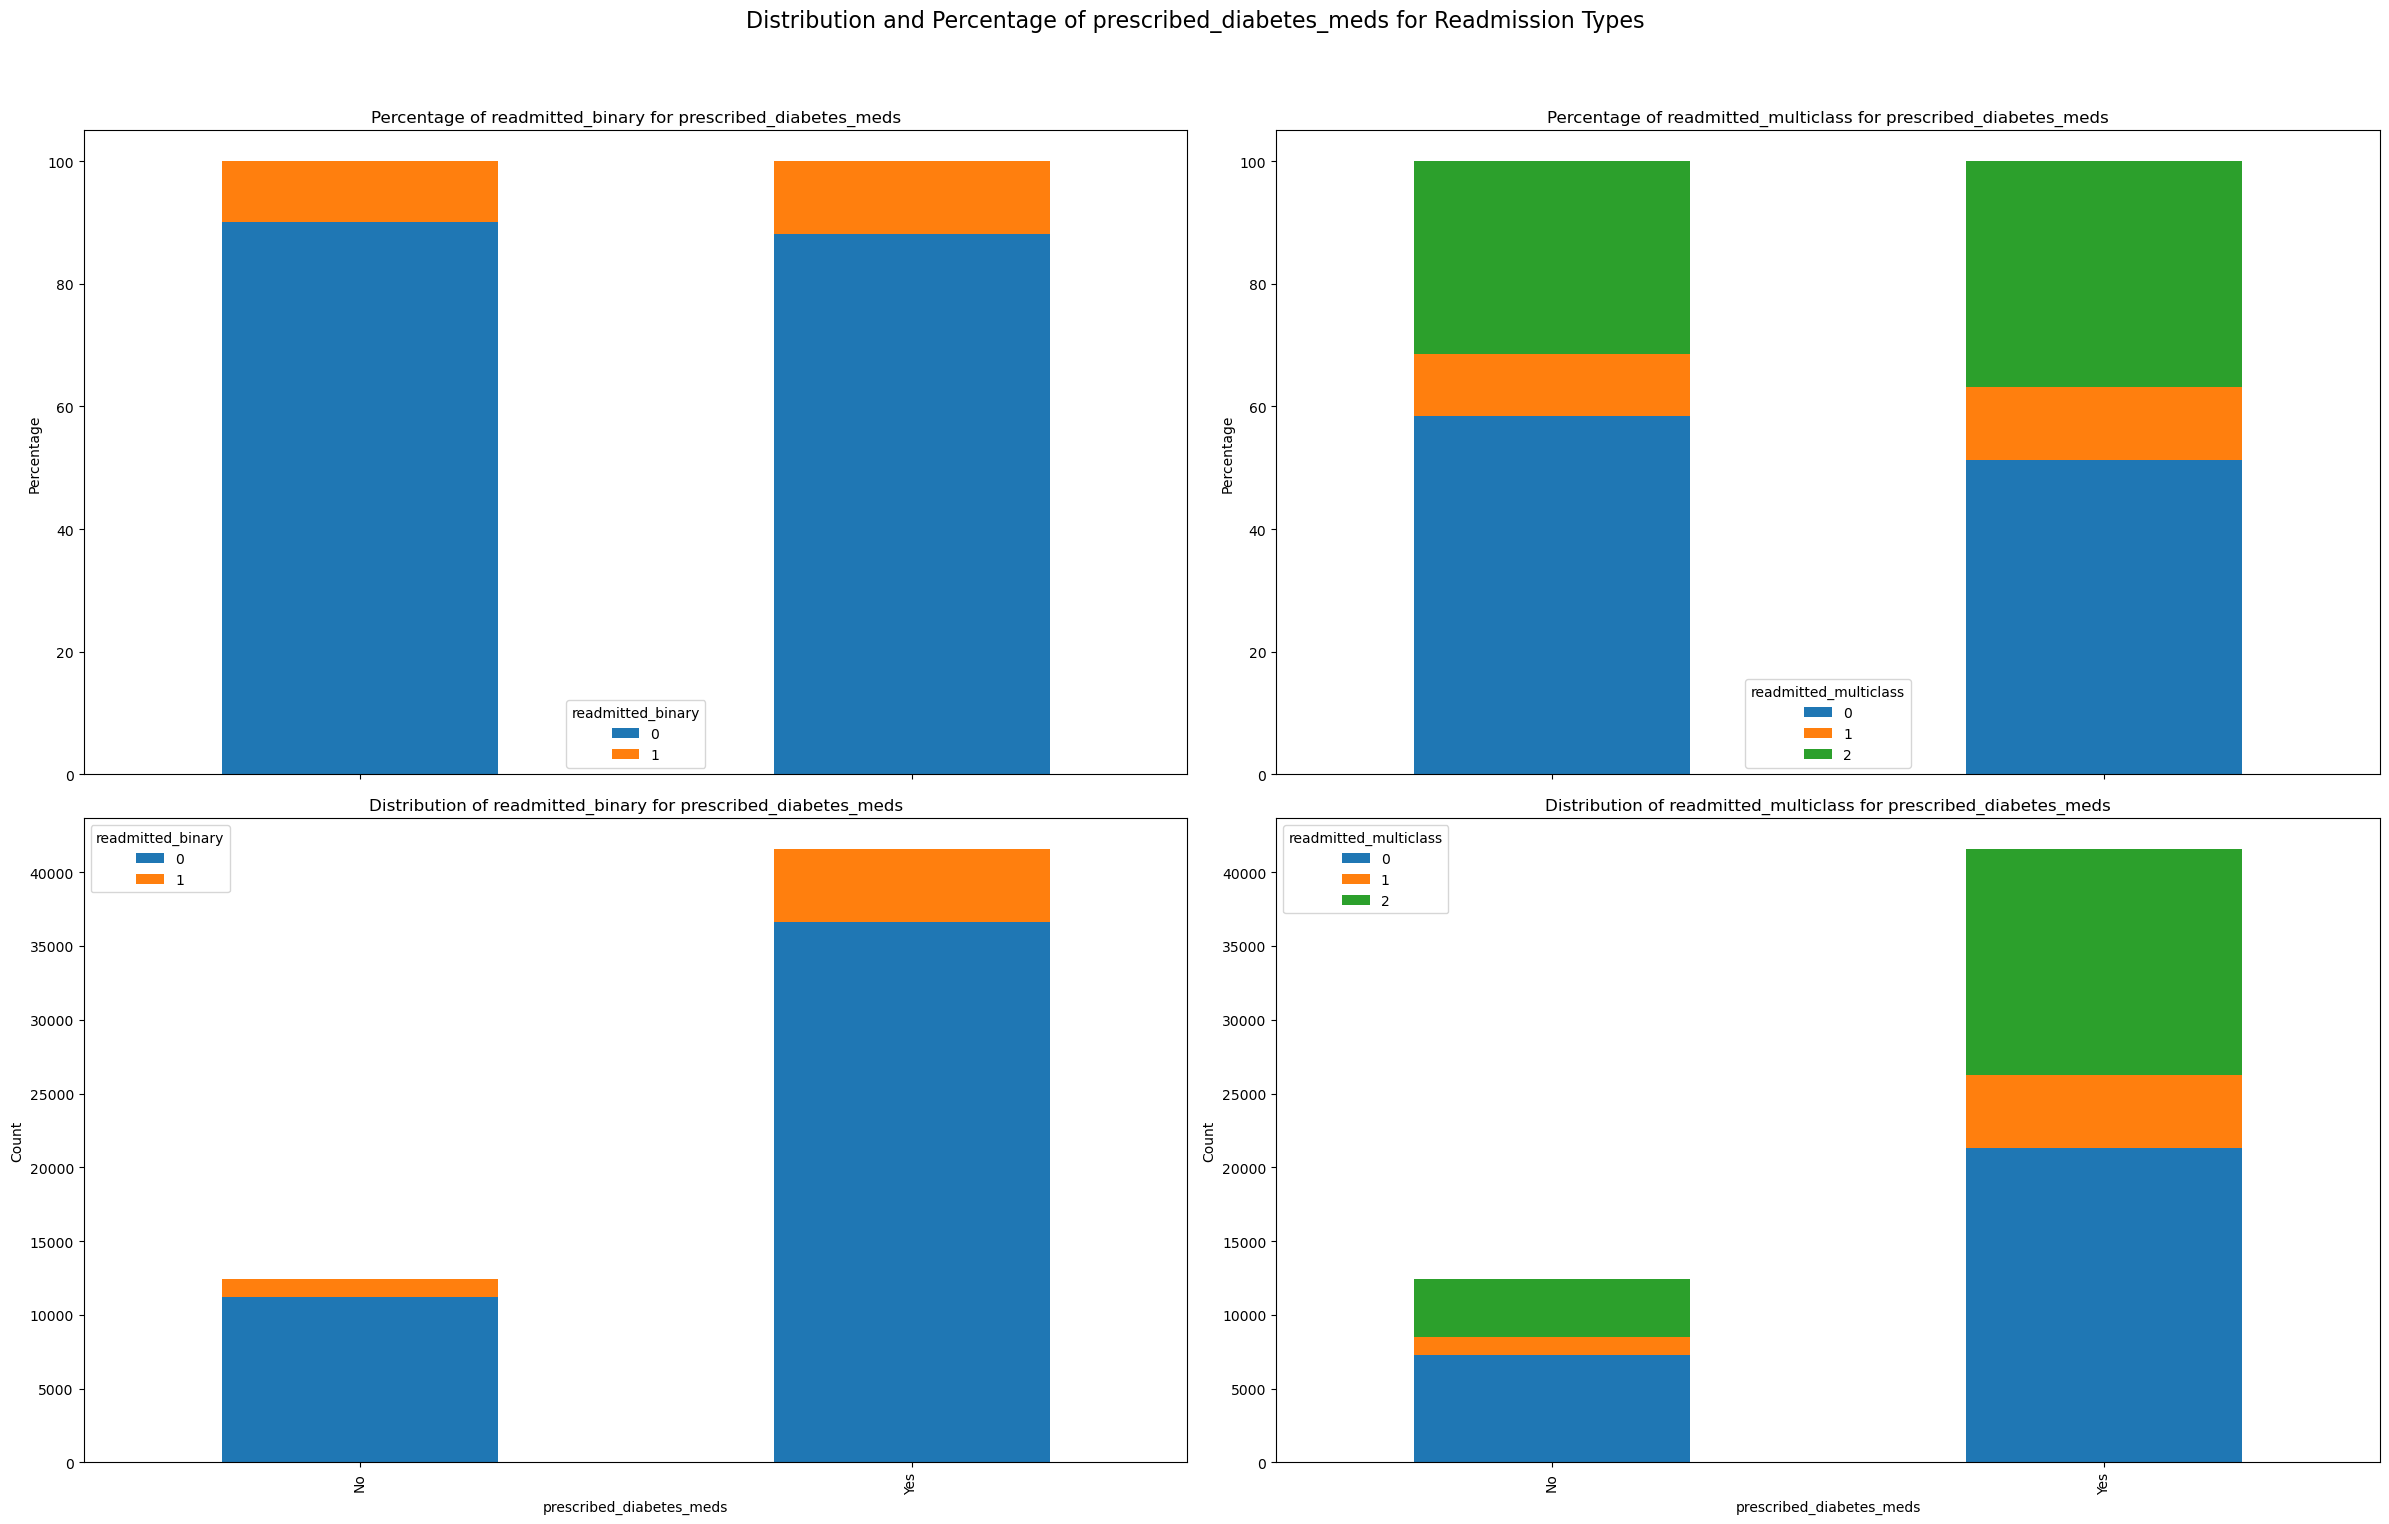

In [199]:
plot_categorical_distribution(data_train, 'prescribed_diabetes_meds')

In [200]:
# replace 'Yes' and 'No' with 1 and 0
data_train['prescribed_diabetes_meds'] = data_train['prescribed_diabetes_meds'].replace({'Yes': 1, 'No': 0})
data_val['prescribed_diabetes_meds'] = data_val['prescribed_diabetes_meds'].replace({'Yes': 1, 'No': 0})
data_test['prescribed_diabetes_meds'] = data_test['prescribed_diabetes_meds'].replace({'Yes': 1, 'No': 0})

#### medication

In [201]:
data_train['medication'].value_counts()

medication
['insulin']                                                               16497
[]                                                                        12430
['metformin']                                                              2392
['metformin', 'insulin']                                                   2291
['glipizide']                                                              2074
                                                                          ...  
['glimepiride', 'glipizide', 'glyburide', 'insulin']                          1
['glipizide', 'insulin', 'glyburide-metformin', 'glipizide-metformin']        1
['metformin', 'glyburide', 'acarbose']                                        1
['repaglinide', 'miglitol', 'insulin']                                        1
['metformin', 'glimepiride', 'insulin', 'glyburide-metformin']                1
Name: count, Length: 276, dtype: int64

In [202]:
# Extract unique medications from the 'medication' column in data_train_copy
unique_medications = set()

# Iterate through each row in the 'medication' column of data_train_copy and add the medications to the set
for medication_list in data_train['medication']:
    medications = medication_list.strip('[]').replace(" ", "").split(',')
    unique_medications.update(medications)

# Convert the set to a list to count the unique medications
unique_medications_list = list(unique_medications)

# Create binary columns for each unique medication in data_train and set values to 1 if present, 0 if not
for medication in unique_medications_list:
    data_train[medication] = data_train['medication'].apply(lambda x: 1 if medication in x else 0)


# Repeat the process for data_validation_copy using the unique medications extracted from data_train_copy
for medication in unique_medications_list:
    data_val[medication] = data_val['medication'].apply(lambda x: 1 if medication in x else 0)
    data_test[medication] = data_test['medication'].apply(lambda x: 1 if medication in x else 0)

# Drop the original 'medication'
data_train.drop(columns=['medication'], inplace=True)
data_val.drop(columns=['medication'], inplace=True)
data_test.drop(columns=['medication'], inplace=True)


# Feature Engineering

#### sum_visits

In [203]:
# create a new column sum_visits to sum up the number of visits
data_train['sum_visits'] = data_train['outpatient_visits_in_previous_year'] + data_train['inpatient_visits_in_previous_year'] + data_train['emergency_visits_in_previous_year']
data_val['sum_visits'] = data_val['outpatient_visits_in_previous_year'] + data_val['inpatient_visits_in_previous_year'] + data_val['emergency_visits_in_previous_year']
data_test['sum_visits'] = data_test['outpatient_visits_in_previous_year'] + data_test['inpatient_visits_in_previous_year'] + data_test['emergency_visits_in_previous_year']

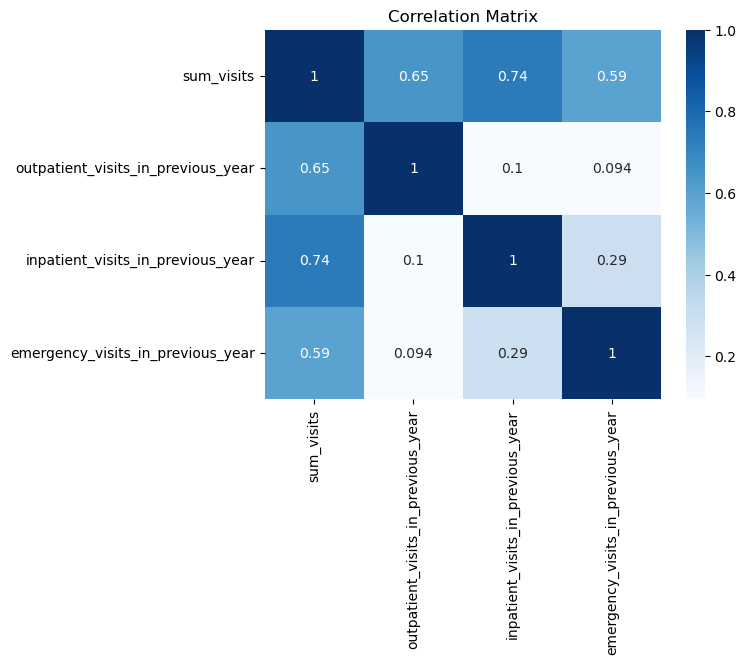

In [204]:
corr_matrix = data_train[['sum_visits', 'outpatient_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'emergency_visits_in_previous_year']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()


In [205]:
data_train.drop(['outpatient_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'emergency_visits_in_previous_year'], axis=1, inplace=True)
data_val.drop(['outpatient_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'emergency_visits_in_previous_year'], axis=1, inplace=True)
data_test.drop(['outpatient_visits_in_previous_year', 'inpatient_visits_in_previous_year', 'emergency_visits_in_previous_year'], axis=1, inplace=True)

#### High Readmission diagnoses (outcomment everything, not improvement in score)

#### Interaction between Medications and Lab Tests

# Encoding

In [206]:
columns_to_hot_encode = ['race', 'admission_type', 'discharge_disposition', 'admission_source', 'glucose_test_result', 'a1c_test_result', 'primary_diagnosis', 'secondary_diagnosis', 'payer_code']

In [207]:
# Initialize the OneHotEncoder with handle_unknown='ignore' to ignore unknown categories
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

# Fit the encoder on the training data
encoder.fit(data_train[columns_to_hot_encode])

# Transform both training and testing data
train_encoded = encoder.transform(data_train[columns_to_hot_encode])
val_encoded = encoder.transform(data_val[columns_to_hot_encode])
test_encoded = encoder.transform(data_test[columns_to_hot_encode])

# Convert the encoded matrices to DataFrames
# Ensure the index is aligned with the original DataFrame's index
train_encoded_df = pd.DataFrame(train_encoded.toarray(), 
                                index=data_train.index,
                                columns=encoder.get_feature_names_out(columns_to_hot_encode))

val_encoded_df = pd.DataFrame(val_encoded.toarray(),
                                index=data_val.index,
                                columns=encoder.get_feature_names_out(columns_to_hot_encode))

test_encoded_df = pd.DataFrame(test_encoded.toarray(), 
                               index=data_test.index,
                               columns=encoder.get_feature_names_out(columns_to_hot_encode))

# Concatenate the encoded columns back to the original dataframes
data_train = pd.concat([data_train.drop(columns=columns_to_hot_encode), train_encoded_df], axis=1)
data_val = pd.concat([data_val.drop(columns=columns_to_hot_encode), val_encoded_df], axis=1)
data_test = pd.concat([data_test.drop(columns=columns_to_hot_encode), test_encoded_df], axis=1)

# Scaling

In [208]:
columns_to_scale = ['age', 'admission_count', 'sum_visits', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']

In [209]:
# scale the columns
scaler = MinMaxScaler()

# fit the scaler on the training data
scaler.fit(data_train[columns_to_scale])

# transform both training and testing data
data_train[columns_to_scale] = scaler.transform(data_train[columns_to_scale])
data_val[columns_to_scale] = scaler.transform(data_val[columns_to_scale])
data_test[columns_to_scale] = scaler.transform(data_test[columns_to_scale])

## Remaining missing values

In [210]:
# we will use following features to impute age
features_for_imputation = ['sum_visits', 'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures', 'number_of_medications', 'number_diagnoses']

# Initialize the KNNImputer
knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Prepare the training data for imputation (excluding 'age')
train_data_for_imputation = data_train[features_for_imputation]

# Fit the imputer on the training data and transform the 'age' column
data_train['age'] = knn_imputer.fit_transform(data_train[['age']].join(train_data_for_imputation))[:, 0]

# Prepare the validation and test data for imputation (excluding 'age')
val_data_for_imputation = data_val[features_for_imputation]
test_data_for_imputation = data_test[features_for_imputation]

# Transform the 'age' column in validation and test data using the trained imputer
data_val['age'] = knn_imputer.transform(data_val[['age']].join(val_data_for_imputation))[:, 0]
data_test['age'] = knn_imputer.transform(data_test[['age']].join(test_data_for_imputation))[:, 0]

# Save and Reload

In [211]:
# use pickle to save the data_train, data_val and data_test
with open('data_train.pkl', 'wb') as f:
    pickle.dump(data_train, f)

with open('data_val.pkl', 'wb') as f:
    pickle.dump(data_val, f)

with open('data_test.pkl', 'wb') as f:
    pickle.dump(data_test, f)

In [212]:
# load the data_train, data_val and data_test
with open('data_train.pkl', 'rb') as f:
    data_train = pickle.load(f)

with open('data_val.pkl', 'rb') as f:
    data_val = pickle.load(f)

with open('data_test.pkl', 'rb') as f:
    data_test = pickle.load(f)

# Binary Classification

In [213]:
# define X_train, y_train, X_val, y_val
X_train = data_train.drop(['readmitted_binary', 'readmitted_multiclass'], axis=1)
y_train = data_train['readmitted_binary']

X_val = data_val.drop(['readmitted_binary', 'readmitted_multiclass'], axis=1)
y_val = data_val['readmitted_binary']

X_test = data_test.copy()

In [214]:
# we have to remember to drop patient_id as it doesn't predict anything itself
X_train.drop(['patient_id'], axis=1, inplace=True)
X_val.drop(['patient_id'], axis=1, inplace=True)
X_test.drop(['patient_id'], axis=1, inplace=True)

### OverSampling

In [215]:
# Create a pipeline that first applies SMOTE and then applies RandomUnderSampler
over = SMOTE(sampling_strategy=0.5, random_state=42)  # Oversample to 50% of majority class
under = RandomUnderSampler(sampling_strategy=1.0, random_state=42)  # Undersample to equalize
pipeline = Pipeline(steps=[('o', over), ('u', under)])

# Apply the pipeline to your training data
X_train, y_train = pipeline.fit_resample(X_train, y_train)

### Feature Selection

In [216]:
# We used the below code to get the best number of features by using RFE with logistic regression as model


# nof_list=np.arange(30,110)            
# high_score=0
# # Variable to store the optimum features
# model = LogisticRegression(random_state=42, max_iter=300)
# nof=0           
# score_list =[]
# for n in range(len(nof_list)):
#     rfe = RFE(model,n_features_to_select = nof_list[n])
#     X_train_rfe = rfe.fit_transform(X_train,y_train)
#     X_val_rfe = rfe.transform(X_val)
#     model.fit(X_train_rfe,y_train)
    
#     score = model.score(X_val_rfe,y_val)
#     score_list.append(score)
    
#     if(score>high_score):
#         high_score = score
#         nof = nof_list[n]
# print("Optimum number of features: %d" %nof)
# print("Score with %d features: %f" % (nof, high_score))


# --> we try 32 features

In [217]:
# use logistic regression in RFE to select best features

logreg = LogisticRegression(random_state=42, max_iter=1000)

# Assuming logreg is your logistic regression model
rfe = RFE(estimator=logreg, n_features_to_select=32)

# Fitting the RFE model
rfe = rfe.fit(X_train, y_train.values.ravel())

cols = X_train.columns[rfe.support_].tolist()

X_train = X_train[cols]
X_test = X_test[cols]
X_val = X_val[cols]

### Models

In [218]:
# we want to get a first impression of the model scores before tning hyperparameters

In [219]:
# create a function that will fit the model and print the f1 score

def fit_model(model, X_train, y_train, X_validation, y_validation):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_validation)
    print('F1 score: {}'.format(f1_score(y_validation, y_pred)))
    return model

In [220]:
# logistic regression
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg = fit_model(logreg, X_train, y_train, X_val, y_val)

F1 score: 0.30707524466549013


In [221]:
# random forest
rf = RandomForestClassifier(random_state=42)
rf = fit_model(rf, X_train, y_train, X_val, y_val)

F1 score: 0.21121039805036554


### Gridsearch

In [222]:
# create parameters grids for grid search. For binary classification we will use gradient boost, logistic regression and random forest as models.

In [223]:
# # parameter grid: 

# .
# .
# .
# .
# .
# .
# .
# ..
# .
# .
# .
# .

In [224]:
# create a gradient boosting model with the parameters learning_rate=0.01, max_depth=3, n_estimators=400, subsample=1, random_state=42, validation_fraction=0.2, n_iter_no_change=5, tol=0.01, ccp_alpha=0.001, verbose=1, n_iter_no_change=5, tol=0.01, ccp_alpha=0.001, verbose=1, random_state=42
gb = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=400, subsample=1, random_state=42, validation_fraction=0.2, n_iter_no_change=5, tol=0.01, ccp_alpha=0.001, verbose=1)
gb = fit_model(gb, X_train, y_train, X_val, y_val)



      Iter       Train Loss   Remaining Time 
         1           1.3785           45.76s
         2           1.3709           45.33s


         3           1.3634           44.66s
         4           1.3561           45.26s
         5           1.3489           45.18s
         6           1.3418           45.09s
         7           1.3349           43.47s
         8           1.3281           42.05s
         9           1.3215           41.18s
        10           1.3149           40.39s
        20           1.2560           36.07s
        30           1.2069           34.40s
        40           1.1658           33.00s
        50           1.1311           31.69s
        60           1.1017           31.18s
        70           1.0765           30.01s
        80           1.0548           28.97s
F1 score: 0.3113096637667529


In [225]:
# Parameter lists
n_estimators = 100
criterion = 'entropy'     # choose between 'gini', 'entropy', and 'log_loss'
max_depth = 30            # doesn't change after a certain value, around 30
min_samples_split = 4     # constant and then decreases
min_samples_leaf = 12     # around 12
min_weight_fraction_leaf = 0.0    # keep 0
max_features = 'sqrt'     # choose between 'auto', 'log2', and 'sqrt'
max_leaf_nodes = None
min_impurity_decrease = 0.0   # has to be 0
bootstrap = True         # choose between True and False, True seems better
oob_score = False        # only true if bootstrap is true, use false
n_jobs = None
verbose = 0              # keep 0
warm_start = False
class_weight = 'balanced'     # choose between 'balanced' and 'balanced_subsample', 'balanced' seems better
ccp_alpha = 0.0          # has to be 0
max_samples = None

# Create a random forest model with the specified parameters
rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, 
                            min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                            min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, 
                            max_leaf_nodes=max_leaf_nodes, min_impurity_decrease=min_impurity_decrease, 
                            bootstrap=bootstrap, oob_score=oob_score, n_jobs=n_jobs, verbose=verbose, 
                            warm_start=warm_start, class_weight=class_weight, ccp_alpha=ccp_alpha, 
                            max_samples=max_samples)

# Fit the model to your training data
rf.fit(X_train, y_train)

# Make predictions on your test data
y_pred = rf.predict(X_val)

# Print the F1 score
print('F1 score:', f1_score(y_val, y_pred))

F1 score: 0.3237213218269838


In [226]:
# create a random forest model with the following parameters: class_weight='balanced', random_state=42, criterion='gini', max_depth=15, min_samples_split=200, min_samples_leaf=101, max_features=None, max_leaf_nodes=50, min_impurity_decrease=0.03, n_estimators=50, n_jobs=-1, verbose=1
rf = RandomForestClassifier(class_weight='balanced', random_state=42, criterion='gini', max_depth=15, min_samples_split=200, min_samples_leaf=101, max_features=None, max_leaf_nodes=50, min_impurity_decrease=0.03, n_estimators=50, n_jobs=-1, verbose=1)
rf = fit_model(rf, X_train, y_train, X_val, y_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


F1 score: 0.3112128146453089


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


### Submission

In [227]:
# make predictions on validation set and save them in a csv file for submission with encounter_id as column and the predictions as values
y_pred = rf.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['readmitted_binary'])
y_pred['encounter_id'] = X_test.index
y_pred = y_pred[['encounter_id', 'readmitted_binary']].replace({1: 'Yes', 0: 'No'})
y_pred.to_csv('predictions_rf.csv', index=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


# Multi Classification